# Uso de mapper para crear un indice financiero

## Librerías

In [7]:
import pandas as pd
import numpy as np
import random

import plotly
import requests
from bs4 import BeautifulSoup
import ruptures as rpt
import yfinance as yf

import plotly.graph_objects as go
import matplotlib.pyplot as plt

import kmapper as km
import subprocess
import sys
import networkx as nx
subprocess.check_call([sys.executable, "-m", "pip", "install", "plotly", "nbformat>=4.2.0"])
import sklearn.cluster

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import DBSCAN, KMeans
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots



#### Funciones de docs en repositorio

from Funciones import calculate_metrics




## Datos

In [8]:
START_DATE = "2025-01-01"
END_DATE = "2025-10-08"


# URL de la lista del S&P 500
url = "https://www.slickcharts.com/sp500"


# Hacer la petición con headers para evitar bloqueos
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
}
response = requests.get(url, headers=headers)
response.raise_for_status()  # Raise exception for bad status codes

# Parsear el HTML
soup = BeautifulSoup(response.text, 'html.parser')

# Encontrar la tabla
table = soup.find('table')

if table:
    # Leer la tabla con pandas
    df = pd.read_html(str(table))[0]
    
    # Extraer los tickers
    if 'Symbol' in df.columns:
        tickers = df['Symbol'].tolist()
        print(f"Found {len(tickers)} tickers")
        print("First 10 tickers:", tickers[:10])
    else:
        print("Available columns:", df.columns.tolist())

    # Extraer los pesos
    if 'Weight' in df.columns:
        weights = df['Weight'].tolist()
        print(f"Found {len(weights)} weights")
        print("First 10 weights:", weights[:10])
    else:
        print("Available columns:", df.columns.tolist())
else:
    print("No table found on the page")

# En la lista de ticker, reemplazar los "." por "-"
tickers = [ticker.replace('.', '-') for ticker in tickers]
print("Tickers after replacement:", tickers[:10])

Found 503 tickers
First 10 tickers: ['NVDA', 'MSFT', 'AAPL', 'AMZN', 'META', 'AVGO', 'GOOGL', 'GOOG', 'TSLA', 'BRK.B']
Found 503 weights
First 10 weights: ['7.29%', '6.35%', '6.12%', '3.84%', '2.96%', '2.70%', '2.55%', '2.39%', '2.37%', '1.78%']
Tickers after replacement: ['NVDA', 'MSFT', 'AAPL', 'AMZN', 'META', 'AVGO', 'GOOGL', 'GOOG', 'TSLA', 'BRK-B']


In [9]:
# -----------------------------
# Descargar precios históricos
# -----------------------------
tickers_data = yf.download(tickers, start=START_DATE, end=END_DATE, auto_adjust=True)['Close']
tickers_data = tickers_data.dropna(axis=1)  # eliminar columnas con datos faltantes


# -----------------------------
#  Función para calcular métricas
# -----------------------------
def calculate_metrics(curve, risk_free_rate=0.01):
    returns = curve.pct_change().dropna()
    years = (curve.index[-1] - curve.index[0]).days / 365.25
    cagr = (curve.iloc[-1] / curve.iloc[0]) ** (1 / years) - 1
    volatility = returns.std() * np.sqrt(252)
    sharpe = (cagr - risk_free_rate) / volatility if volatility != 0 else np.nan
    rolling_max = curve.cummax()
    drawdown = curve / rolling_max - 1
    max_dd = drawdown.min()
    return cagr, volatility, sharpe, max_dd

[*******               15%                       ]  74 of 503 completed

[*********************100%***********************]  503 of 503 completed



## 📊 Base de Datos Completa de Información de Tickers

In [10]:
# =======================================================
# 📊 RECOPILACIÓN DE INFORMACIÓN FUNDAMENTAL DE TICKERS
# =======================================================

print("🔍 Recopilando información detallada de todos los tickers del S&P 500...")
print("=" * 80)

ticker_info_db = {}
failed_tickers = []
successful_count = 0

for idx, ticker in enumerate(tickers, 1):
    try:
        stock = yf.Ticker(ticker)
        info = stock.info
        
        # Extraer información relevante
        ticker_info_db[ticker] = {
            # Información básica
            'sector': info.get('sector', 'Unknown'),
            'industry': info.get('industry', 'Unknown'),
            'market_cap': info.get('marketCap', None),
            'country': info.get('country', 'Unknown'),
            'full_name': info.get('longName', ticker),
            
            # Métricas de valoración
            'pe_ratio': info.get('trailingPE', None),
            'forward_pe': info.get('forwardPE', None),
            'peg_ratio': info.get('pegRatio', None),
            'price_to_book': info.get('priceToBook', None),
            'price_to_sales': info.get('priceToSalesTrailing12Months', None),
            'enterprise_value': info.get('enterpriseValue', None),
            'ev_to_ebitda': info.get('enterpriseToEbitda', None),
            
            # Dividendos
            'dividend_yield': info.get('dividendYield', None),
            'dividend_rate': info.get('dividendRate', None),
            'payout_ratio': info.get('payoutRatio', None),
            'five_year_avg_dividend_yield': info.get('fiveYearAvgDividendYield', None),
            
            # Rentabilidad
            'profit_margins': info.get('profitMargins', None),
            'operating_margins': info.get('operatingMargins', None),
            'gross_margins': info.get('grossMargins', None),
            'roe': info.get('returnOnEquity', None),
            'roa': info.get('returnOnAssets', None),
            
            # Crecimiento
            'revenue_growth': info.get('revenueGrowth', None),
            'earnings_growth': info.get('earningsGrowth', None),
            'earnings_quarterly_growth': info.get('earningsQuarterlyGrowth', None),
            
            # Riesgo y volatilidad
            'beta': info.get('beta', None),
            '52week_high': info.get('fiftyTwoWeekHigh', None),
            '52week_low': info.get('fiftyTwoWeekLow', None),
            '52week_change': info.get('52WeekChange', None),
            
            # Liquidez y deuda
            'current_ratio': info.get('currentRatio', None),
            'quick_ratio': info.get('quickRatio', None),
            'debt_to_equity': info.get('debtToEquity', None),
            'total_debt': info.get('totalDebt', None),
            'total_cash': info.get('totalCash', None),
            
            # Analistas y recomendaciones
            'recommendation': info.get('recommendationKey', 'Unknown'),
            'recommendation_mean': info.get('recommendationMean', None),
            'target_mean_price': info.get('targetMeanPrice', None),
            'target_high_price': info.get('targetHighPrice', None),
            'target_low_price': info.get('targetLowPrice', None),
            'number_of_analysts': info.get('numberOfAnalystOpinions', None),
            
            # Información adicional
            'employees': info.get('fullTimeEmployees', None),
            'exchange': info.get('exchange', 'Unknown'),
            'quote_type': info.get('quoteType', 'Unknown'),
        }
        
        successful_count += 1
        
        if idx % 50 == 0:
            print(f"✅ Procesados {idx}/{len(tickers)} tickers...")
        
    except Exception as e:
        failed_tickers.append(ticker)
        ticker_info_db[ticker] = {
            'sector': 'Unknown',
            'industry': 'Unknown',
            'error': str(e)
        }

print(f"\n{'='*80}")
print(f"📊 RESUMEN DE RECOPILACIÓN:")
print(f"   ✅ Exitosos: {successful_count}/{len(tickers)} ({successful_count/len(tickers)*100:.1f}%)")
print(f"   ❌ Fallidos: {len(failed_tickers)}")
if failed_tickers:
    print(f"   Tickers fallidos: {', '.join(failed_tickers[:10])}{'...' if len(failed_tickers) > 10 else ''}")

# Crear DataFrame para análisis fácil
ticker_info_df = pd.DataFrame.from_dict(ticker_info_db, orient='index')

print(f"\n📋 DataFrame de información creado: {ticker_info_df.shape}")
print(f"   Columnas disponibles: {ticker_info_df.shape[1]}")

# Guardar en CSV para uso posterior
ticker_info_df.to_csv('sp500_ticker_info_database.csv')
print("\n💾 Base de datos guardada en 'sp500_ticker_info_database.csv'")

# Mostrar primeras filas
print("\n📄 Primeras filas de la base de datos:")
display(ticker_info_df[['sector', 'industry', 'market_cap', 'pe_ratio', 'beta', 'dividend_yield']].head(10))

🔍 Recopilando información detallada de todos los tickers del S&P 500...
✅ Procesados 50/503 tickers...
✅ Procesados 100/503 tickers...
✅ Procesados 150/503 tickers...
✅ Procesados 200/503 tickers...
✅ Procesados 250/503 tickers...
✅ Procesados 300/503 tickers...
✅ Procesados 350/503 tickers...
✅ Procesados 400/503 tickers...
✅ Procesados 450/503 tickers...
✅ Procesados 500/503 tickers...

📊 RESUMEN DE RECOPILACIÓN:
   ✅ Exitosos: 503/503 (100.0%)
   ❌ Fallidos: 0

📋 DataFrame de información creado: (503, 42)
   Columnas disponibles: 42

💾 Base de datos guardada en 'sp500_ticker_info_database.csv'

📄 Primeras filas de la base de datos:


sector                        industry     market_cap  \
NVDA               Technology                  Semiconductors  4383190548480   
MSFT               Technology       Software - Infrastructure  3821019332608   
AAPL               Technology            Consumer Electronics  3677003448320   
AMZN        Consumer Cyclical                 Internet Retail  2347027136512   
META   Communication Services  Internet Content & Information  1797939789824   
AVGO               Technology                  Semiconductors  1684467613696   
GOOGL  Communication Services  Internet Content & Information  2955410931712   
GOOG   Communication Services  Internet Content & Information  2955410931712   
TSLA        Consumer Cyclical              Auto Manufacturers  1449433235456   
BRK-B      Financial Services         Insurance - Diversified  1070096515072   

         pe_ratio   beta  dividend_yield  
NVDA    51.437140  2.123            0.02  
MSFT    37.707050  1.023            0.71  
AAPL    37.597874  1.094            0.42  
AMZN    33.548840  1.281             NaN  
META    25.976906  1.203            0.29  
AVGO    91.768000  1.208            0.66  
GOOGL   26.028631  1.000            0.34  
GOOG    26.107105  1.000            0.34  
TSLA   257.029940  2.086             NaN  
BRK-B   17.002743  0.770             NaN

In [11]:
# =======================================================
# 📈 ESTADÍSTICAS GENERALES DE LA BASE DE DATOS
# =======================================================

print("\n📈 ESTADÍSTICAS GENERALES DEL S&P 500:")
print("=" * 80)

# Distribución por Sector
print("\n🏢 DISTRIBUCIÓN POR SECTOR:")
sector_counts = ticker_info_df['sector'].value_counts()
for sector, count in sector_counts.items():
    pct = (count / len(ticker_info_df)) * 100
    print(f"   {sector:30s}: {count:3d} empresas ({pct:5.1f}%)")

# Top 10 Industrias
print("\n🏭 TOP 10 INDUSTRIAS:")
industry_counts = ticker_info_df['industry'].value_counts().head(10)
for industry, count in industry_counts.items():
    print(f"   {industry:50s}: {count:2d} empresas")

# Distribución por País
print("\n🌍 TOP 10 PAÍSES:")
country_counts = ticker_info_df['country'].value_counts().head(10)
for country, count in country_counts.items():
    pct = (count / len(ticker_info_df)) * 100
    print(f"   {country:30s}: {count:3d} empresas ({pct:5.1f}%)")

# Estadísticas de métricas financieras
print("\n💰 ESTADÍSTICAS DE MÉTRICAS FINANCIERAS (Medianas):")
financial_stats = {
    'Market Cap (Billones)': ticker_info_df['market_cap'].median() / 1e9 if ticker_info_df['market_cap'].notna().any() else None,
    'P/E Ratio': ticker_info_df['pe_ratio'].median(),
    'Beta': ticker_info_df['beta'].median(),
    'ROE (%)': ticker_info_df['roe'].median() * 100 if ticker_info_df['roe'].notna().any() else None,
    'Profit Margin (%)': ticker_info_df['profit_margins'].median() * 100 if ticker_info_df['profit_margins'].notna().any() else None,
    'Debt/Equity': ticker_info_df['debt_to_equity'].median(),
    'Dividend Yield (%)': ticker_info_df['dividend_yield'].median() * 100 if ticker_info_df['dividend_yield'].notna().any() else None,
}

for metric, value in financial_stats.items():
    if value is not None and not np.isnan(value):
        print(f"   {metric:25s}: {value:8.2f}")

# Empresas más grandes por Market Cap
print("\n🏆 TOP 10 EMPRESAS POR MARKET CAP:")
top_companies = ticker_info_df.nlargest(10, 'market_cap')[['full_name', 'sector', 'market_cap']]
for idx, (ticker, row) in enumerate(top_companies.iterrows(), 1):
    market_cap_b = row['market_cap'] / 1e9 if pd.notna(row['market_cap']) else 0
    print(f"   {idx:2d}. {ticker:5s} - {row['full_name'][:40]:40s} | ${market_cap_b:6.1f}B | {row['sector']}")

print(f"\n{'='*80}")
print("✅ Estadísticas generales completadas")


📈 ESTADÍSTICAS GENERALES DEL S&P 500:

🏢 DISTRIBUCIÓN POR SECTOR:
   Technology                    :  81 empresas ( 16.1%)
   Industrials                   :  72 empresas ( 14.3%)
   Financial Services            :  69 empresas ( 13.7%)
   Healthcare                    :  60 empresas ( 11.9%)
   Consumer Cyclical             :  55 empresas ( 10.9%)
   Consumer Defensive            :  37 empresas (  7.4%)
   Real Estate                   :  31 empresas (  6.2%)
   Utilities                     :  31 empresas (  6.2%)
   Communication Services        :  25 empresas (  5.0%)
   Energy                        :  22 empresas (  4.4%)
   Basic Materials               :  20 empresas (  4.0%)

🏭 TOP 10 INDUSTRIAS:
   Utilities - Regulated Electric                    : 23 empresas
   Specialty Industrial Machinery                    : 17 empresas
   Software - Application                            : 17 empresas
   Software - Infrastructure                         : 15 empresas
   Semiconductor

## Clases

In [12]:
class SimpleMapper:
    def __init__(self, n_intervals=10, overlap=0.3):
        self.n_intervals = n_intervals
        self.overlap = overlap
        self.graph = {}
        self.nodes = {}
        self.edges = []
        
    def fit_transform(self, X, projection=None, lens_function=None):
        """
        Implementación simplificada del algoritmo Mapper COMPATIBLE con KeplerMapper
        """
        # Manejar proyecciones como KeplerMapper
        if projection is not None:
            if isinstance(projection, list):
                # Tomar solo las columnas especificadas
                if len(projection) == 1:
                    lens_values = X[:, projection[0]]
                else:
                    lens_values = np.mean(X[:, projection], axis=1)
            elif projection == 'sum':
                lens_values = np.sum(X, axis=1)
            else:
                lens_values = projection(X) if callable(projection) else X[:, 0]
        elif lens_function is not None:
            lens_values = lens_function(X)
        else:
            # Si no se proporciona función de lente, usar PCA
            pca = PCA(n_components=2)
            lens_values = pca.fit_transform(X)[:, 0]  # Primera componente
        
        # Crear intervalos superpuestos
        min_val, max_val = lens_values.min(), lens_values.max()
        interval_size = (max_val - min_val) / self.n_intervals
        overlap_size = interval_size * self.overlap
        
        nodes = {}
        node_id = 0
        
        # Para cada intervalo
        for i in range(self.n_intervals):
            start = min_val + i * interval_size - overlap_size
            end = min_val + (i + 1) * interval_size + overlap_size
            
            # Obtener puntos en este intervalo
            mask = (lens_values >= start) & (lens_values <= end)
            if mask.sum() == 0:
                continue
                
            points_in_interval = X[mask]
            indices_in_interval = np.where(mask)[0]
            
            if len(points_in_interval) < 2:
                continue
            
            # Clustering dentro del intervalo
            try:
                # Ajustar parámetros de DBSCAN para datos financieros normalizados
                eps_value = max(0.3, np.std(points_in_interval) * 2)  # Adaptar epsilon
                min_samples = max(1, len(points_in_interval) // 4)    # Mínimo adaptativo
                
                clustering = DBSCAN(eps=eps_value, min_samples=min_samples).fit(points_in_interval)
                unique_labels = set(clustering.labels_)
                
                # Si no hay clusters válidos, crear un cluster con todos los puntos
                if len(unique_labels) == 1 and -1 in unique_labels:
                    nodes[node_id] = {
                        'points': indices_in_interval,
                        'size': len(indices_in_interval),
                        'interval': i,
                        'center': np.mean(points_in_interval, axis=0)
                    }
                    node_id += 1
                else:
                    for label in unique_labels:
                        if label == -1:  # Ruido en DBSCAN - también incluir como cluster
                            cluster_mask = clustering.labels_ == label
                            cluster_indices = indices_in_interval[cluster_mask]
                            if len(cluster_indices) > 0:
                                nodes[node_id] = {
                                    'points': cluster_indices,
                                    'size': len(cluster_indices),
                                    'interval': i,
                                    'center': np.mean(points_in_interval[cluster_mask], axis=0),
                                    'type': 'outliers'
                                }
                                node_id += 1
                        else:
                            cluster_mask = clustering.labels_ == label
                            cluster_indices = indices_in_interval[cluster_mask]
                            
                            if len(cluster_indices) > 0:
                                nodes[node_id] = {
                                    'points': cluster_indices,
                                    'size': len(cluster_indices),
                                    'interval': i,
                                    'center': np.mean(points_in_interval[cluster_mask], axis=0),
                                    'type': 'cluster'
                                }
                                node_id += 1
                        
            except Exception as e:
                # Si DBSCAN falla, crear un solo nodo con todos los puntos
                nodes[node_id] = {
                    'points': indices_in_interval,
                    'size': len(indices_in_interval),
                    'interval': i,
                    'center': np.mean(points_in_interval, axis=0),
                    'type': 'fallback'
                }
                node_id += 1
        
        # Crear conexiones entre nodos que comparten puntos
        edges = []
        for i, node1 in nodes.items():
            for j, node2 in nodes.items():
                if i < j:  # Evitar duplicados
                    shared_points = set(node1['points']) & set(node2['points'])
                    if len(shared_points) > 0:
                        edges.append((i, j, len(shared_points)))
        
        self.nodes = nodes
        self.edges = edges
        
        print(f"\n📊 SimpleMapper completado:")
        print(f"   🔧 Intervalos: {self.n_intervals}, Overlap: {self.overlap}")
        print(f"   📊 Nodos creados: {len(self.nodes)}")
        print(f"   🔗 Conexiones: {len(self.edges)}")
        
        return X  # Compatibilidad con KeplerMapper
    
    
    
    def visualize(self, 
                  title='Mapper Visualization',
                  custom_tooltips=None,
                  color_values=None,
                  color_function_name='Color Function',
                  node_color_function=['average', 'std', 'sum', 'max', 'min'],
                  ticker_labels=None,
                  save_html=False,
                  path_html='mapper_visualization.html'):
        """
        Crear visualización interactiva del grafo Mapper usando Plotly
        
        Parameters:
        -----------
        title : str
            Título del gráfico
        custom_tooltips : array-like
            Información adicional para mostrar en tooltips
        color_values : array-like
            Valores para colorear los nodos
        color_function_name : str
            Nombre de la función de color
        node_color_function : list
            Funciones estadísticas para colorear nodos
        ticker_labels : array-like
            Etiquetas de los tickers
        save_html : bool
            Si guardar como archivo HTML
        filename : str
            Nombre del archivo HTML
        """
       
        
        if not hasattr(self, 'nodes'):
            print("❌ Primero ejecuta fit_transform()")
            return
        
        # Crear layout del grafo usando spring layout simple
        positions = self._calculate_spring_layout()
        
        # Preparar datos para los nodos
        node_x = []
        node_y = []
        node_sizes = []
        node_colors = []
        node_text = []
        hover_text = []
        
        for node_id, node in self.nodes.items():
            x, y = positions[node_id]
            node_x.append(x)
            node_y.append(y)
            
            # Tamaño del nodo
            size = max(10, node['size'] * 5)
            node_sizes.append(size)
            
            # Color del nodo basado en color_values si se proporciona
            if color_values is not None:
                # Calcular estadística del color para los puntos en este nodo
                node_values = color_values[node['points']]
                if 'average' in node_color_function:
                    color_val = np.mean(node_values)
                elif 'sum' in node_color_function:
                    color_val = np.sum(node_values)
                elif 'max' in node_color_function:
                    color_val = np.max(node_values)
                elif 'min' in node_color_function:
                    color_val = np.min(node_values)
                else:  # std
                    color_val = np.std(node_values)
                node_colors.append(color_val)
            else:
                node_colors.append(node['size'])
            
            # Texto del nodo
            node_text.append(f"Cluster {node_id}")
            
            # Hover text con información detallada
            hover_info = f"<b>Cluster {node_id}</b><br>"
            hover_info += f"Tamaño: {node['size']}<br>"
            hover_info += f"Intervalo: {node['interval']}<br>"
            hover_info += f"Tipo: {node.get('type', 'cluster')}<br>"
            
            # Agregar información de tickers si están disponibles
            if ticker_labels is not None:
                tickers_in_node = [ticker_labels[i] for i in node['points']]
                hover_info += f"Tickers: {', '.join(tickers_in_node[:5])}"
                if len(tickers_in_node) > 5:
                    hover_info += f"... y {len(tickers_in_node)-5} más"
                hover_info += "<br>"
            
            # Agregar tooltips personalizados
            if custom_tooltips is not None:
                tooltip_values = custom_tooltips[node['points']]
                hover_info += f"Info adicional: {np.mean(tooltip_values):.3f}<br>"
            
            hover_text.append(hover_info)
        
        # Preparar datos para las aristas
        edge_x = []
        edge_y = []
        edge_weights = []
        
        for i, j, weight in self.edges:
            if i in positions and j in positions:
                x0, y0 = positions[i]
                x1, y1 = positions[j]
                edge_x.extend([x0, x1, None])
                edge_y.extend([y0, y1, None])
                edge_weights.append(weight)
        
        # Crear la figura
        fig = go.Figure()
        
        # Agregar aristas
        fig.add_trace(go.Scatter(
            x=edge_x, y=edge_y,
            mode='lines',
            line=dict(width=2, color='rgba(50,50,50,0.3)'),
            hoverinfo='none',
            showlegend=False,
            name='Conexiones'
        ))
        
        # Agregar nodos
        fig.add_trace(go.Scatter(
            x=node_x, y=node_y,
            mode='markers+text',
            marker=dict(
                size=node_sizes,
                color=node_colors,
                colorscale='Viridis',
                showscale=True,
                colorbar=dict(title=color_function_name),
                line=dict(width=2, color='white')
            ),
            text=node_text,
            textposition="middle center",
            textfont=dict(color="white", size=10),
            hovertext=hover_text,
            hoverinfo='text',
            showlegend=False,
            name='Clusters'
        ))
        
        # Configurar layout
        fig.update_layout(
            title=dict(
                text=title,
                x=0.5,
                font=dict(size=16, color='darkblue')
            ),
            showlegend=False,
            hovermode='closest',
            margin=dict(b=20,l=5,r=5,t=40),
            annotations=[
                dict(
                    text=f"Total clusters: {len(self.nodes)} | Total conexiones: {len(self.edges)}",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002,
                    xanchor='left', yanchor='bottom',
                    font=dict(color='gray', size=12)
                )
            ],
            xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            plot_bgcolor='white'
        )
        
        # Mostrar la figura
        try:
            fig.show()
        except Exception as e:
            print(f"⚠️  No se puede mostrar la visualización interactiva en este entorno.")
            print(f"Error: {e}")
            print("💡 Guardando como HTML para visualización externa...")
            save_html = True
            if not filename.endswith('.html'):
                filename = filename.replace('.html', '') + '_fallback.html'
        
        # Guardar como HTML si se solicita o si hay error
        if save_html:
            try:
                fig.write_html(filename)
                print(f"💾 Visualización guardada como: {filename}")
                print(f"🌐 Abre el archivo en tu navegador para ver la visualización interactiva")
            except Exception as e:
                print(f"❌ Error guardando HTML: {e}")
                print("🔄 Creando visualización estática alternativa...")
                return self._create_static_alternative(color_values, color_function_name, ticker_labels)
        
        return self
    
    '''def _create_static_alternative(self, color_values=None, color_function_name='Color', ticker_labels=None):
        """
        Crear visualización estática alternativa cuando plotly no funciona
        """
        import networkx as nx
        
        # Crear grafo de NetworkX
        G = nx.Graph()
        
        # Agregar nodos
        for node_id, node in self.nodes.items():
            node_attrs = {k: v for k, v in node.items() if k != 'size'}  # Evitar conflicto
            node_attrs['node_size'] = node['size']  # Renombrar size
            G.add_node(node_id, **node_attrs)
        
        # Agregar aristas
        for i, j, weight in self.edges:
            G.add_edge(i, j, weight=weight)
        
        # Crear layout
        try:
            pos = nx.spring_layout(G, k=2, iterations=50)
        except:
            pos = {node_id: (np.random.random(), np.random.random()) for node_id in G.nodes()}
        
        # Crear visualización con matplotlib
        plt.figure(figsize=(14, 10))
        
        # Preparar colores
        if color_values is not None:
            node_colors = []
            for node_id in G.nodes():
                node_values = color_values[self.nodes[node_id]['points']]
                node_colors.append(np.mean(node_values))
        else:
            node_colors = [self.nodes[node_id]['size'] for node_id in G.nodes()]
        
        # Preparar tamaños
        node_sizes = [G.nodes[node_id]['node_size'] * 100 for node_id in G.nodes()]
        
        # Dibujar aristas
        nx.draw_networkx_edges(G, pos, alpha=0.3, width=2, edge_color='gray')
        
        # Dibujar nodos
        nodes = nx.draw_networkx_nodes(G, pos, 
                                     node_color=node_colors,
                                     node_size=node_sizes,
                                     cmap='viridis',
                                     alpha=0.8)
        
        # Agregar etiquetas de nodos
        labels = {node_id: str(node_id) for node_id in G.nodes()}
        nx.draw_networkx_labels(G, pos, labels, font_size=8, font_color='white', font_weight='bold')
        
        # Crear colorbar
        if color_values is not None:
            plt.colorbar(nodes, label=color_function_name)
        
        plt.title('Análisis Topológico Mapper - Vista Estática\n(NetworkX + Matplotlib)', 
                 fontsize=14, fontweight='bold')
        plt.axis('off')
        
        # Agregar información de texto
        info_text = f"Nodos: {len(self.nodes)} | Conexiones: {len(self.edges)}"
        if ticker_labels is not None:
            info_text += f" | Tickers analizados: {len(ticker_labels)}"
        
        plt.figtext(0.02, 0.02, info_text, fontsize=10, style='italic', color='gray')
        
        plt.tight_layout()
        plt.show()
        
        # Mostrar información detallada de clusters
        print("\n📊 INFORMACIÓN DETALLADA DE CLUSTERS:")
        print("=" * 60)
        
        for node_id, node in self.nodes.items():
            print(f"\n🏷️  Cluster {node_id}:")
            print(f"   📏 Tamaño: {node['size']} tickers")
            print(f"   📍 Intervalo: {node['interval']}")
            print(f"   🏷️  Tipo: {node.get('type', 'cluster')}")
            
            if ticker_labels is not None:
                tickers_in_node = [ticker_labels[i] for i in node['points']]
                print(f"   🏢 Tickers: {', '.join(tickers_in_node[:8])}")
                if len(tickers_in_node) > 8:
                    print(f"       ... y {len(tickers_in_node)-8} más")
            
            if color_values is not None:
                node_values = color_values[node['points']]
                print(f"   📊 {color_function_name}: promedio={np.mean(node_values):.3f}, "
                      f"std={np.std(node_values):.3f}")
        
        return self'''
    
    def _calculate_spring_layout(self):
        """
        Calcular posiciones de nodos usando un algoritmo de spring layout simplificado
        """
        import random
        
        positions = {}
        n_nodes = len(self.nodes)
        
        # Posiciones iniciales aleatorias
        random.seed(42)
        for node_id in self.nodes.keys():
            positions[node_id] = (random.uniform(-1, 1), random.uniform(-1, 1))
        
        # Aplicar fuerzas de spring (simplificado)
        for iteration in range(50):
            forces = {node_id: [0, 0] for node_id in self.nodes.keys()}
            
            # Fuerza repulsiva entre todos los nodos
            for i in self.nodes.keys():
                for j in self.nodes.keys():
                    if i != j:
                        xi, yi = positions[i]
                        xj, yj = positions[j]
                        dx = xi - xj
                        dy = yi - yj
                        distance = max(0.01, np.sqrt(dx**2 + dy**2))
                        force_magnitude = 0.1 / distance**2
                        forces[i][0] += force_magnitude * dx / distance
                        forces[i][1] += force_magnitude * dy / distance
            
            # Fuerza atractiva entre nodos conectados
            for i, j, weight in self.edges:
                if i in positions and j in positions:
                    xi, yi = positions[i]
                    xj, yj = positions[j]
                    dx = xj - xi
                    dy = yj - yi
                    distance = max(0.01, np.sqrt(dx**2 + dy**2))
                    force_magnitude = 0.01 * distance * weight
                    forces[i][0] += force_magnitude * dx / distance
                    forces[i][1] += force_magnitude * dy / distance
                    forces[j][0] -= force_magnitude * dx / distance
                    forces[j][1] -= force_magnitude * dy / distance
            
            # Actualizar posiciones
            for node_id in self.nodes.keys():
                x, y = positions[node_id]
                fx, fy = forces[node_id]
                positions[node_id] = (x + fx * 0.1, y + fy * 0.1)
        
        return positions

## Creación

In [13]:
# =======================================================
# CREAR SUBCARPETA PARA VISUALIZACIONES
# =======================================================

import os

# Crear la subcarpeta para todas las visualizaciones
output_folder = 'visualizaciones_mapper_indice'
os.makedirs(output_folder, exist_ok=True)
print(f"📁 Subcarpeta creada: {output_folder}/")
print(f"🌐 Todas las visualizaciones HTML se guardarán en esta carpeta")

📁 Subcarpeta creada: visualizaciones_mapper_indice/
🌐 Todas las visualizaciones HTML se guardarán en esta carpeta


In [14]:
# =======================================================
# MAPPER SIMPLE CON KEPLER MAPPER (COMO EL EJEMPLO)
# =======================================================



financial_metrics = {}
print("\n🔄 Calculando métricas financieras...")
for ticker in tickers_data.columns:
    try:
        prices = tickers_data[ticker].dropna()
        returns = prices.pct_change().dropna()
        
        # Métricas básicas
        total_return = (prices.iloc[-1] / prices.iloc[0]) - 1
        volatility = returns.std() * np.sqrt(252)  # Anualizada
        sharpe = (returns.mean() * 252) / (returns.std() * np.sqrt(252)) if returns.std() > 0 else 0
        
        # Métricas de riesgo
        max_drawdown = ((prices / prices.cummax()) - 1).min()
        var_95 = returns.quantile(0.05)  # Value at Risk 95%
        skewness = returns.skew()
        kurtosis = returns.kurtosis()
        
        # Métricas de tendencia
        returns_positive_ratio = (returns > 0).mean()
        trend_slope = np.polyfit(range(len(prices)), prices.values, 1)[0]
        
        financial_metrics[ticker] = {
            'total_return': total_return,
            'volatility': volatility,
            'sharpe_ratio': sharpe,
            'max_drawdown': max_drawdown,
            'var_95': var_95,
            'skewness': skewness,
            'kurtosis': kurtosis,
            'positive_ratio': returns_positive_ratio,
            'trend_slope': trend_slope / prices.iloc[0]  # Normalizado
        }
    except Exception as e:
        print(f"❌ Error procesando {ticker}: {e}")

# Convertir a DataFrame
metrics_df = pd.DataFrame(financial_metrics).T

# Normalizar datos
scaler = StandardScaler()
metrics_scaled = scaler.fit_transform(metrics_df.fillna(0))

# Preparar datos para KeplerMapper (usar métricas financieras)
X = metrics_scaled  # Datos normalizados que ya tenemos
ticker_names = metrics_df.index.tolist()



'''
# Crear y aplicar SimpleMapper con parámetros más permisivos
simple_mapper = SimpleMapper(n_intervals=6, overlap=0.5)
simple_graph = simple_mapper.fit_transform(X, projection=[2])

#Crear la cubierta de intervalos (más permisiva)
covering = km.Cover(n_cubes=6, perc_overlap=0.5)

# 4. Crear el grafo Mapper (usando KMeans que es más estable)
G = simple_mapper.map(simple_graph, X, 
               clusterer=sklearn.cluster.KMeans(n_clusters=2),
               cover=covering)


'''

display(X)
display(ticker_names)







🔄 Calculando métricas financieras...


array([[-0.23318633,  0.02355921, -0.1954279 , ..., -0.70887798,
        -0.4945882 , -0.71368102],
       [-0.19753719,  0.16090132, -0.15377391, ...,  0.55117087,
        -0.21380054, -0.31383576],
       [ 0.73759511, -0.56667776,  1.20432443, ..., -0.64986382,
         0.76895627,  0.25922763],
       ...,
       [-0.53552453, -0.45267544, -0.67133542, ...,  0.33912068,
         0.76895627, -0.66451037],
       [-1.14875722,  1.03815782, -1.16930224, ...,  0.33473072,
        -1.47734501, -0.68804296],
       [-0.76635079, -0.58371482, -1.12364006, ..., -0.84599804,
        -0.07340671, -0.77077472]], shape=(503, 9))

['A',
 'AAPL',
 'ABBV',
 'ABNB',
 'ABT',
 'ACGL',
 'ACN',
 'ADBE',
 'ADI',
 'ADM',
 'ADP',
 'ADSK',
 'AEE',
 'AEP',
 'AES',
 'AFL',
 'AIG',
 'AIZ',
 'AJG',
 'AKAM',
 'ALB',
 'ALGN',
 'ALL',
 'ALLE',
 'AMAT',
 'AMCR',
 'AMD',
 'AME',
 'AMGN',
 'AMP',
 'AMT',
 'AMZN',
 'ANET',
 'AON',
 'AOS',
 'APA',
 'APD',
 'APH',
 'APO',
 'APP',
 'APTV',
 'ARE',
 'ATO',
 'AVB',
 'AVGO',
 'AVY',
 'AWK',
 'AXON',
 'AXP',
 'AZO',
 'BA',
 'BAC',
 'BALL',
 'BAX',
 'BBY',
 'BDX',
 'BEN',
 'BF-B',
 'BG',
 'BIIB',
 'BK',
 'BKNG',
 'BKR',
 'BLDR',
 'BLK',
 'BMY',
 'BR',
 'BRK-B',
 'BRO',
 'BSX',
 'BX',
 'BXP',
 'C',
 'CAG',
 'CAH',
 'CARR',
 'CAT',
 'CB',
 'CBOE',
 'CBRE',
 'CCI',
 'CCL',
 'CDNS',
 'CDW',
 'CEG',
 'CF',
 'CFG',
 'CHD',
 'CHRW',
 'CHTR',
 'CI',
 'CINF',
 'CL',
 'CLX',
 'CMCSA',
 'CME',
 'CMG',
 'CMI',
 'CMS',
 'CNC',
 'CNP',
 'COF',
 'COIN',
 'COO',
 'COP',
 'COR',
 'COST',
 'CPAY',
 'CPB',
 'CPRT',
 'CPT',
 'CRL',
 'CRM',
 'CRWD',
 'CSCO',
 'CSGP',
 'CSX',
 'CTAS',
 'CTRA',
 'CTSH',
 'CTVA',
 

In [15]:


print(f"📊 Datos preparados: {X.shape[0]} tickers, {X.shape[1]} métricas")

# 1. Crear el mapper
mapper = km.KeplerMapper(verbose=1)

# 2. Proyección de los datos (usando Sharpe ratio que es más discriminativo)
projected_data = mapper.fit_transform(X, projection=[2])  # Sharpe ratio (índice 2)

print("✅ Proyección completada")

# 3. Definir la cubierta de intervalos (más permisiva)
covering = km.Cover(n_cubes=6, perc_overlap=0.5)

print("✅ Cubierta definida")

# 4. Crear el grafo Mapper (usando KMeans que es más estable)
G = mapper.map(projected_data, X, 
               clusterer=sklearn.cluster.KMeans(n_clusters=2),
               cover=covering)

print("✅ Grafo Mapper creado")

# 5. Visualizar el resultado con nombres de tickers
mapper.visualize(G, 
                title='Análisis Topológico Mapper - Tickers Financieros',
                color_values=metrics_df['sharpe_ratio'].values,
                color_function_name='Sharpe Ratio',
                node_color_function=np.array(['average','std','sum','max','min']),
                custom_tooltips=np.array(ticker_names),  # Mostrar nombres de tickers
                path_html='visualizaciones_mapper_indice/mapper_principal_sharpe.html')  # Guardado en subcarpeta

print("\n📊 Información del grafo:")
print(f"Nodos: {len(G['nodes'])}")

print(f"Aristas: {len(G['links'])}")
print(f"Metadata: {G['meta_data']}")

📊 Datos preparados: 503 tickers, 9 métricas
KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: [2]
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (503, 9)

..Projecting data using: [2]

..Scaling with: MinMaxScaler()

✅ Proyección completada
✅ Cubierta definida
Mapping on data shaped (503, 9) using lens shaped (503, 1)

Creating 6 hypercubes.

Created 16 edges and 12 nodes in 0:00:01.404824.
✅ Grafo Mapper creado
Wrote visualization to: visualizaciones_mapper_indice/mapper_principal_sharpe.html

📊 Información del grafo:
Nodos: 12
Aristas: 10
Metadata: {'projection': '[2]', 'n_cubes': 6, 'perc_overlap': 0.5, 'clusterer': 'KMeans(n_clusters=2)', 'scaler': 'MinMaxScaler()', 'nerve_min_intersection': 1}

Created 16 edges and 12 nodes in 0:00:01.404824.
✅ Grafo Mapper creado
Wrote visualization to: visualizaciones_mapper_indice/mapper_principal_sharpe.html

📊 Información del grafo:
Nodos: 12
Aristas: 10
Metadata: {'projection':

In [16]:
# =======================================================
# VISUALIZACIÓN INTERACTIVA MAPPER CON PLOTLY
# =======================================================

print("🎨 CREANDO VISUALIZACIÓN INTERACTIVA DEL MAPPER")
print("=" * 50)
'''
# Instalar dependencias si no están disponibles
try:
    import plotly.graph_objects as go
    print("✅ Plotly disponible para visualización interactiva")
    plotly_available = True
except ImportError:
    print("📦 Instalando plotly y nbformat...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "plotly", "nbformat>=4.2.0"])
    try:
        import plotly.graph_objects as go
        print("✅ Plotly instalado y listo")
        plotly_available = True
    except:
        print("⚠️  Plotly no disponible, usando visualización alternativa")
        plotly_available = False

# Instalar networkx para visualización alternativa
try:
    import networkx as nx
    print("✅ NetworkX disponible para visualización alternativa")
except ImportError:
    print("📦 Instalando networkx...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "networkx"])
    import networkx as nx
    print("✅ NetworkX instalado y listo")
'''







################################################################################## INECESARIO    
# Preparar datos para la visualización
'''ticker_names = metrics_df.index.tolist()  # Nombres de los tickers
sharpe_ratios = metrics_df['sharpe_ratio'].values  # Para colorear nodos
returns_data = metrics_df['total_return'].values  # Para tooltips personalizados

# Crear visualización interactiva básica usando KeplerMapper correcto
print("\n🎯 Visualización 1: Coloreado por Sharpe Ratio promedio")
mapper.visualize(G,  # Usar el grafo G creado anteriormente
                title='Análisis Topológico de Tickers Financieros - Mapper Interactivo',
                color_values=sharpe_ratios,
                color_function_name='Sharpe Ratio Promedio',
                node_color_function=np.array(['average']),
                custom_tooltips=np.array(ticker_names),  # Mostrar nombres de tickers
                path_html='visualizaciones_mapper_indice/mapper_interactivo_sharpe.html')

print("\n🎯 Visualización 2: Coloreado por Volatilidad máxima")
volatility_data = metrics_df['volatility'].values
mapper.visualize(G,  # Usar el mismo grafo G
                title='Mapper - Agrupación por Volatilidad Máxima',
                color_values=volatility_data,
                color_function_name='Volatilidad Máxima',
                node_color_function=np.array(['max']),
                custom_tooltips=np.array(ticker_names),
                path_html='visualizaciones_mapper_indice/mapper_interactivo_volatilidad.html')

print("\n🎯 Visualización 3: Coloreado por Retorno Total promedio")
mapper.visualize(G,  # Usar el mismo grafo G
                title='Mapper - Agrupación por Retorno Total Promedio',
                color_values=returns_data,
                color_function_name='Retorno Total Promedio',
                node_color_function=np.array(['average']),
                custom_tooltips=np.array(ticker_names),
                path_html='visualizaciones_mapper_indice/mapper_interactivo_retorno.html')

print("\n💡 INSTRUCCIONES:")
print("• Pasa el mouse sobre los nodos para ver información detallada")
print("• Los colores representan diferentes métricas financieras")
print("• El tamaño de los nodos indica el número de tickers en cada cluster")
print("• Las conexiones muestran tickers compartidos entre clusters")
print("• Se guardó una versión interactiva como 'mapper_financial_analysis.html'")

print("📁 mapper_interactivo_sharpe.html - Visualización por Sharpe Ratio")
print("\n🌐 Los nombres de tickers aparecen al hacer hover sobre los nodos!")

print("📁 visualizaciones_mapper_indice/mapper_interactivo_volatilidad.html - Visualización por Volatilidad")
print("📁 visualizaciones_mapper_indice/mapper_interactivo_retorno.html - Visualización por Retorno Total")'''

🎨 CREANDO VISUALIZACIÓN INTERACTIVA DEL MAPPER


'ticker_names = metrics_df.index.tolist()  # Nombres de los tickers\nsharpe_ratios = metrics_df[\'sharpe_ratio\'].values  # Para colorear nodos\nreturns_data = metrics_df[\'total_return\'].values  # Para tooltips personalizados\n\n# Crear visualización interactiva básica usando KeplerMapper correcto\nprint("\n🎯 Visualización 1: Coloreado por Sharpe Ratio promedio")\nmapper.visualize(G,  # Usar el grafo G creado anteriormente\n                title=\'Análisis Topológico de Tickers Financieros - Mapper Interactivo\',\n                color_values=sharpe_ratios,\n                color_function_name=\'Sharpe Ratio Promedio\',\n                node_color_function=np.array([\'average\']),\n                custom_tooltips=np.array(ticker_names),  # Mostrar nombres de tickers\n                path_html=\'visualizaciones_mapper_indice/mapper_interactivo_sharpe.html\')\n\nprint("\n🎯 Visualización 2: Coloreado por Volatilidad máxima")\nvolatility_data = metrics_df[\'volatility\'].values\nmapper.v

# Diretente no cloude

In [17]:
# =======================================================
# ANÁLISIS DETALLADO DE NODOS DEL KEPLER MAPPER
# =======================================================

print("🔍 ANÁLISIS DETALLADO DE NODOS KEPLER MAPPER")
print("=" * 50)

# Analizar el grafo G (por Sharpe Ratio)
print(f"\n📊 Analizando grafo por Sharpe Ratio:")
print(f"Total de nodos: {len(G['nodes'])}")
print(f"Total de aristas: {len(G['links'])}")

# Examinar nodos específicos
node_names = list(G['nodes'].keys())
print(f"Nombres de nodos: {node_names[:5]}...")

# Función para analizar un nodo específico
def analyze_node(graph, node_name, ticker_names, metrics_df):
    """Analizar un nodo específico del Mapper"""
    if node_name not in graph['nodes']:
        print(f"❌ Nodo {node_name} no encontrado")
        return
    
    node_indices = graph['nodes'][node_name]
    tickers_in_node = [ticker_names[i] for i in node_indices]
    node_metrics = metrics_df.iloc[node_indices]
    
    print(f"\n🏷️  NODO: {node_name}")
    print(f"   📊 Número de tickers: {len(tickers_in_node)}")
    print(f"   🏢 Tickers: {', '.join(tickers_in_node)}")
    print(f"   📈 Sharpe Ratio promedio: {node_metrics['sharpe_ratio'].mean():.3f}")
    print(f"   💰 Retorno promedio: {node_metrics['total_return'].mean():.2%}")
    print(f"   📊 Volatilidad promedio: {node_metrics['volatility'].mean():.2%}")
    print(f"   📉 Max Drawdown promedio: {node_metrics['max_drawdown'].mean():.2%}")
    
    return tickers_in_node, node_metrics

# Analizar los primeros 3 nodos
for i, node_name in enumerate(node_names[:3]):
    tickers, metrics = analyze_node(G, node_name, ticker_names, metrics_df)




print(f"\n💡 RESUMEN:")
print(f"✅ KeplerMapper creado exitosamente con {len(G['nodes'])} nodos")
print(f"✅ Visualizaciones HTML guardadas con nombres únicos")
print(f"✅ Los clusters agrupan tickers con características financieras similares")
print(f"✅ Cada nodo representa un grupo de tickers con Sharpe Ratio similares")
print(f"✅ Los nombres de tickers aparecen en las visualizaciones HTML y en los gráficos")

🔍 ANÁLISIS DETALLADO DE NODOS KEPLER MAPPER

📊 Analizando grafo por Sharpe Ratio:
Total de nodos: 12
Total de aristas: 10
Nombres de nodos: ['cube0_cluster0', 'cube0_cluster1', 'cube1_cluster0', 'cube1_cluster1', 'cube2_cluster0']...

🏷️  NODO: cube0_cluster0
   📊 Número de tickers: 13
   🏢 Tickers: ACN, CAG, CLX, CMG, CPB, CPRT, CRM, DOW, EPAM, FDS, IFF, OKE, TGT
   📈 Sharpe Ratio promedio: -1.324
   💰 Retorno promedio: -29.44%
   📊 Volatilidad promedio: 31.94%
   📉 Max Drawdown promedio: -35.76%

🏷️  NODO: cube0_cluster1
   📊 Número de tickers: 8
   🏢 Tickers: DECK, FI, GDDY, HRL, IT, KMX, LULU, STZ
   📈 Sharpe Ratio promedio: -1.448
   💰 Retorno promedio: -40.96%
   📊 Volatilidad promedio: 42.04%
   📉 Max Drawdown promedio: -47.07%

🏷️  NODO: cube1_cluster0
   📊 Número de tickers: 28
   🏢 Tickers: AKAM, ALGN, BAX, BDX, CHTR, CNC, DECK, DOW, EMN, EPAM, FI, GDDY, GPN, IT, KKR, KMX, LKQ, LULU, MOH, MRNA, ON, REGN, STZ, TPL, TTD, UNH, UPS, ZBRA
   📈 Sharpe Ratio promedio: -0.808
   💰 Re

### FUnciom plot metricas


📈 VISUALIZACIÓN DE CLUSTERS POR SHARPE RATIO:


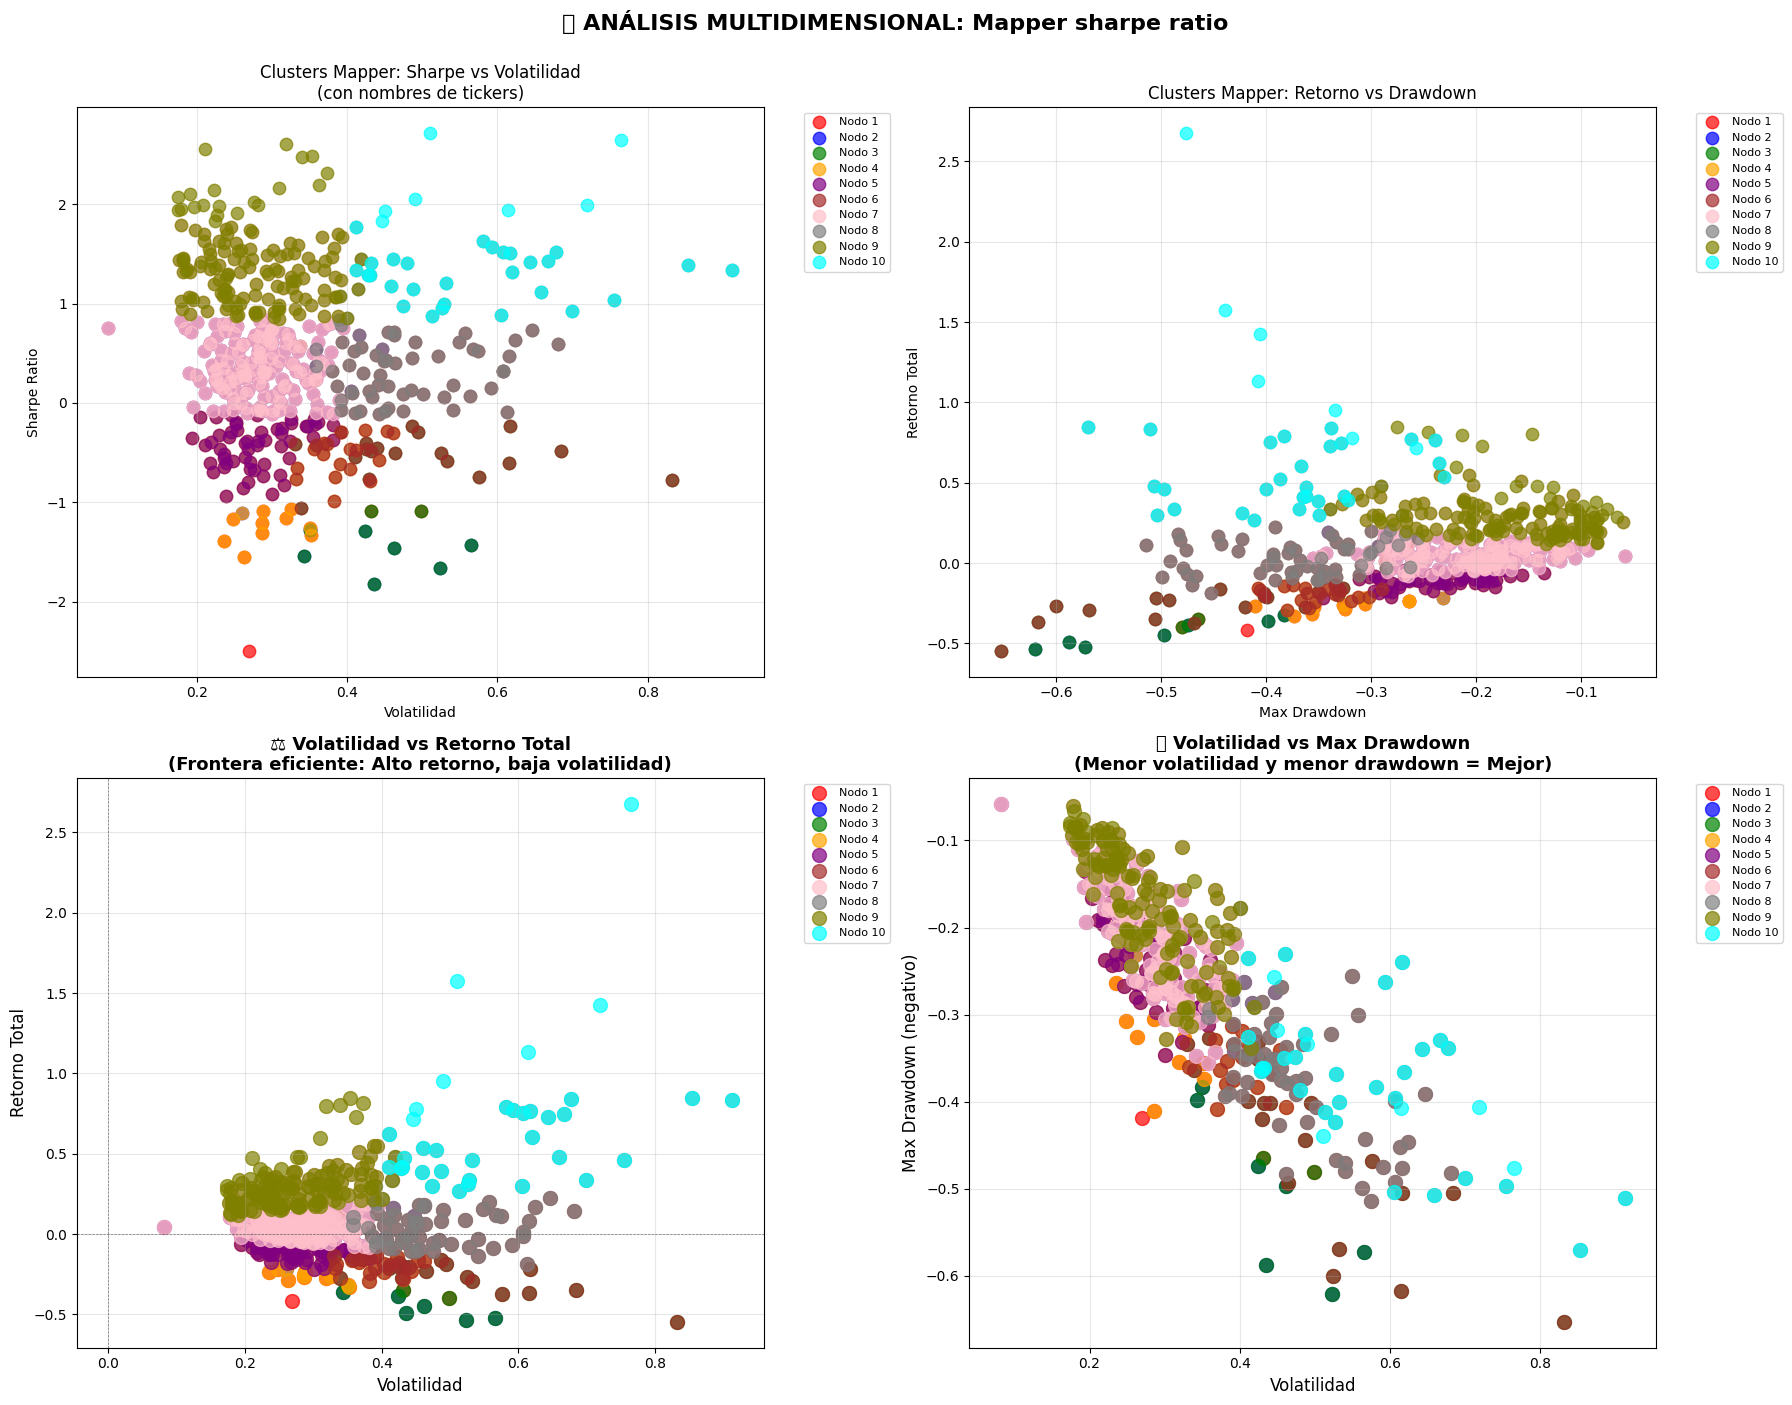

In [18]:

# Crear visualización de los clusters
import matplotlib.pyplot as plt

print(f"\n📈 VISUALIZACIÓN DE CLUSTERS POR SHARPE RATIO:")


def plot_comparacion_clusters(G, ticker_names, metrics_df, title="Mapper sin nombre"):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 14))

    # Gráfico 1: Sharpe vs Volatilidad coloreado por nodos
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
    for i, (node_name, node_indices) in enumerate(list(G['nodes'].items())[:10]):
        node_data = metrics_df.iloc[node_indices]
        tickers_in_node = [ticker_names[j] for j in node_indices]
        
        scatter = ax1.scatter(node_data['volatility'], node_data['sharpe_ratio'], 
                            c=colors[i % len(colors)], label=f'Nodo {i+1}', alpha=0.7, s=80)
        
        # Agregar etiquetas de tickers cerca de los puntos
        for idx, ticker in enumerate(tickers_in_node):
            if len(tickers_in_node) <= 5:  # Solo si hay pocos tickers para evitar saturación
                ax1.annotate(ticker, (node_data['volatility'].iloc[idx], node_data['sharpe_ratio'].iloc[idx]),
                            xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.8)

    ax1.set_xlabel('Volatilidad')
    ax1.set_ylabel('Sharpe Ratio')
    ax1.set_title('Clusters Mapper: Sharpe vs Volatilidad\n(con nombres de tickers)')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax1.grid(True, alpha=0.3)

    # Gráfico 2: Retorno vs Drawdown coloreado por nodos
    for i, (node_name, node_indices) in enumerate(list(G['nodes'].items())[:10]):
        node_data = metrics_df.iloc[node_indices]
        ax2.scatter(node_data['max_drawdown'], node_data['total_return'], 
                c=colors[i % len(colors)], label=f'Nodo {i+1}', alpha=0.7, s=80)

    ax2.set_xlabel('Max Drawdown')
    ax2.set_ylabel('Retorno Total')
    ax2.set_title('Clusters Mapper: Retorno vs Drawdown')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax2.grid(True, alpha=0.3)



    # Gráfico 3: Volatilidad vs Retorno
    for i, (node_name, node_indices) in enumerate(list(G['nodes'].items())[:10]):
        node_data = metrics_df.iloc[node_indices]
        tickers_in_node = [ticker_names[j] for j in node_indices]
        
        scatter = ax3.scatter(node_data['volatility'], node_data['total_return'], 
                            c=colors[i % len(colors)], label=f'Nodo {i+1}', alpha=0.7, s=100)
        
        # Agregar etiquetas de tickers (solo si hay pocos)
        if len(tickers_in_node) <= 5:
            for idx, ticker in enumerate(tickers_in_node):
                ax3.annotate(ticker, 
                            (node_data['volatility'].iloc[idx], node_data['total_return'].iloc[idx]),
                            xytext=(5, 5), textcoords='offset points', fontsize=7, alpha=0.8)

    ax3.set_xlabel('Volatilidad', fontsize=12)
    ax3.set_ylabel('Retorno Total', fontsize=12)
    ax3.set_title('⚖️ Volatilidad vs Retorno Total\n(Frontera eficiente: Alto retorno, baja volatilidad)', fontsize=13, fontweight='bold')
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax3.grid(True, alpha=0.3)
    ax3.axvline(x=0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
    ax3.axhline(y=0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)

    # Gráfico 4: Volatilidad vs Drawdown
    for i, (node_name, node_indices) in enumerate(list(G['nodes'].items())[:10]):
        node_data = metrics_df.iloc[node_indices]
        tickers_in_node = [ticker_names[j] for j in node_indices]
        
        scatter = ax4.scatter(node_data['volatility'], node_data['max_drawdown'], 
                            c=colors[i % len(colors)], label=f'Nodo {i+1}', alpha=0.7, s=100)
        
        # Agregar etiquetas de tickers (solo si hay pocos)
        if len(tickers_in_node) <= 5:
            for idx, ticker in enumerate(tickers_in_node):
                ax4.annotate(ticker, 
                            (node_data['volatility'].iloc[idx], node_data['max_drawdown'].iloc[idx]),
                            xytext=(5, 5), textcoords='offset points', fontsize=7, alpha=0.8)

    ax4.set_xlabel('Volatilidad', fontsize=12)
    ax4.set_ylabel('Max Drawdown (negativo)', fontsize=12)
    ax4.set_title('🎯 Volatilidad vs Max Drawdown\n(Menor volatilidad y menor drawdown = Mejor)', fontsize=13, fontweight='bold')
    ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax4.grid(True, alpha=0.3)

    plt.suptitle(f'🔬 ANÁLISIS MULTIDIMENSIONAL: {title}', 
                fontsize=16, fontweight='bold', y=1.00)



    plt.tight_layout()
    plt.show()



plot_comparacion_clusters(G, ticker_names, metrics_df,"Mapper sharpe ratio")

### Configuraciones mapper

In [19]:
# =======================================================
# EXPLORANDO DIFERENTES CONFIGURACIONES DEL MAPPER
# =======================================================

print("🔍 EXPLORANDO DIFERENTES CONFIGURACIONES")
print("=" * 50)

# Configuración 1: Proyección por Volatilidad
print("\n📊 Configuración 1: Proyección por Volatilidad")
projected_data_vol = mapper.fit_transform(X, projection=[1])  # Volatilidad (índice 1)
covering_vol = km.Cover(n_cubes=8, perc_overlap=0.4)
G_vol = mapper.map(projected_data_vol, X, 
                   clusterer=sklearn.cluster.KMeans(n_clusters=3),
                   cover=covering_vol)

mapper.visualize(G_vol, 
                title='Mapper: Agrupación por Volatilidad',
                color_values=metrics_df['volatility'].values,
                color_function_name='Volatilidad',
                node_color_function=np.array(['average','max']),
                custom_tooltips=np.array(ticker_names),  # Mostrar nombres de tickers
                path_html='visualizaciones_mapper_indice/mapper_config_volatilidad.html')  # Guardado en subcarpeta

print(f"Nodos: {len(G_vol['nodes'])}, Aristas: {len(G_vol['links'])}")

# Configuración 2: Proyección por Retorno Total
print("\n📊 Configuración 2: Proyección por Retorno Total")
projected_data_ret = mapper.fit_transform(X, projection=[0])  # Retorno total (índice 0)
covering_ret = km.Cover(n_cubes=7, perc_overlap=0.3)
G_ret = mapper.map(projected_data_ret, X, 
                   clusterer=sklearn.cluster.DBSCAN(eps=0.5, min_samples=1),
                   cover=covering_ret)

mapper.visualize(G_ret, 
                title='Mapper: Agrupación por Retorno Total',
                node_color_function=np.array(['average','std']),
                custom_tooltips=np.array(ticker_names),  # Mostrar nombres de tickers
                path_html='visualizaciones_mapper_indice/mapper_config_retorno_total.html')  # Guardado en subcarpeta

print(f"Nodos: {len(G_ret['nodes'])}, Aristas: {len(G_ret['links'])}")

# Configuración 3: Proyección Multi-dimensional (PCA)
print("\n📊 Configuración 3: Proyección PCA")
projected_data_pca = mapper.fit_transform(X, projection='sum')  # Proyección suma
covering_pca = km.Cover(n_cubes=5, perc_overlap=0.6)
G_pca = mapper.map(projected_data_pca, X, 
                   clusterer=sklearn.cluster.KMeans(n_clusters=2),
                   cover=covering_pca)

mapper.visualize(G_pca, 
                title='Mapper: Proyección PCA (Suma)',
                node_color_function=np.array(['min','average']),
                custom_tooltips=np.array(ticker_names),  # Mostrar nombres de tickers
                path_html='visualizaciones_mapper_indice/mapper_config_pca_suma.html')  # Guardado en subcarpeta

print("\n💾 ARCHIVOS HTML GENERADOS (guardados en subcarpeta):")
print("📁 visualizaciones_mapper_indice/mapper_principal_sharpe.html - Análisis principal por Sharpe Ratio")
print("📁 visualizaciones_mapper_indice/mapper_config_volatilidad.html - Configuración por Volatilidad") 
print("📁 visualizaciones_mapper_indice/mapper_config_retorno_total.html - Configuración por Retorno Total")
print("📁 visualizaciones_mapper_indice/mapper_config_pca_suma.html - Configuración PCA Suma")
print("\n🌐 INSTRUCCIONES:")

print("• Todos los archivos están organizados en la carpeta 'visualizaciones_mapper_indice/'")
print("• Navega a la subcarpeta y abre cualquier archivo .html en tu navegador")
print("• Cada archivo mantiene su funcionalidad interactiva completa")
print("• Usa las visualizaciones para identificar agrupaciones específicas de tickers")




print("• Abre cada archivo .html para comparar configuraciones")

🔍 EXPLORANDO DIFERENTES CONFIGURACIONES

📊 Configuración 1: Proyección por Volatilidad
..Composing projection pipeline of length 1:
	Projections: [1]
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (503, 9)

..Projecting data using: [1]

..Scaling with: MinMaxScaler()

Mapping on data shaped (503, 9) using lens shaped (503, 1)

Creating 8 hypercubes.

Created 26 edges and 24 nodes in 0:00:00.030120.
Wrote visualization to: visualizaciones_mapper_indice/mapper_config_volatilidad.html
Nodos: 24, Aristas: 17

📊 Configuración 2: Proyección por Retorno Total
..Composing projection pipeline of length 1:
	Projections: [0]
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (503, 9)

..Projecting data using: [0]

..Scaling with: MinMaxScaler()

Mapping on data shaped (503, 9) using lens shaped (503, 1)

Creating 7 hypercubes.

Created 208 edges and 677 nodes in 0:00:00.074046.
Wrote visualization to: visualizaciones_mapper_indice/mapper

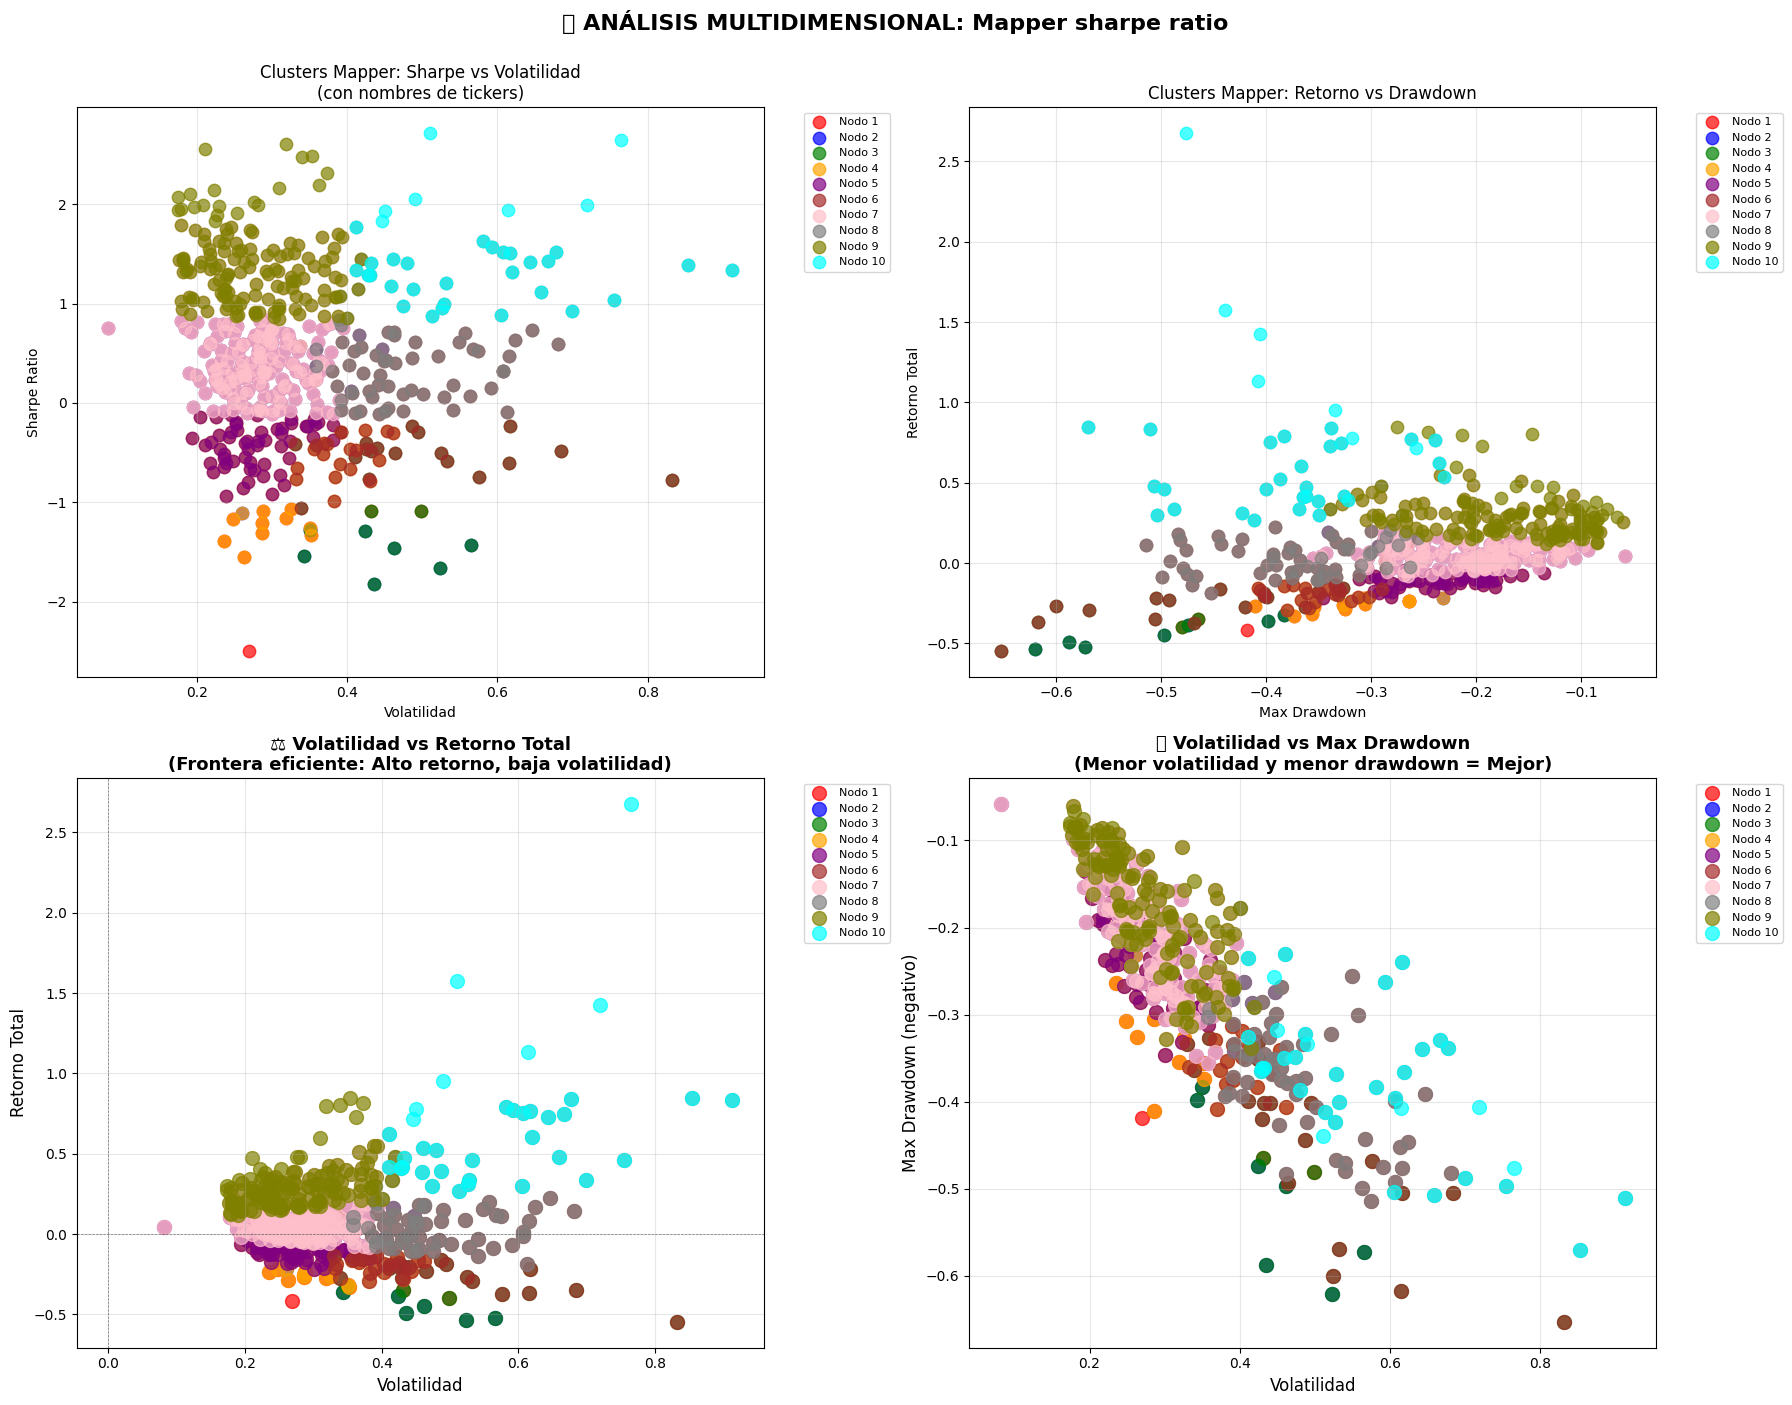

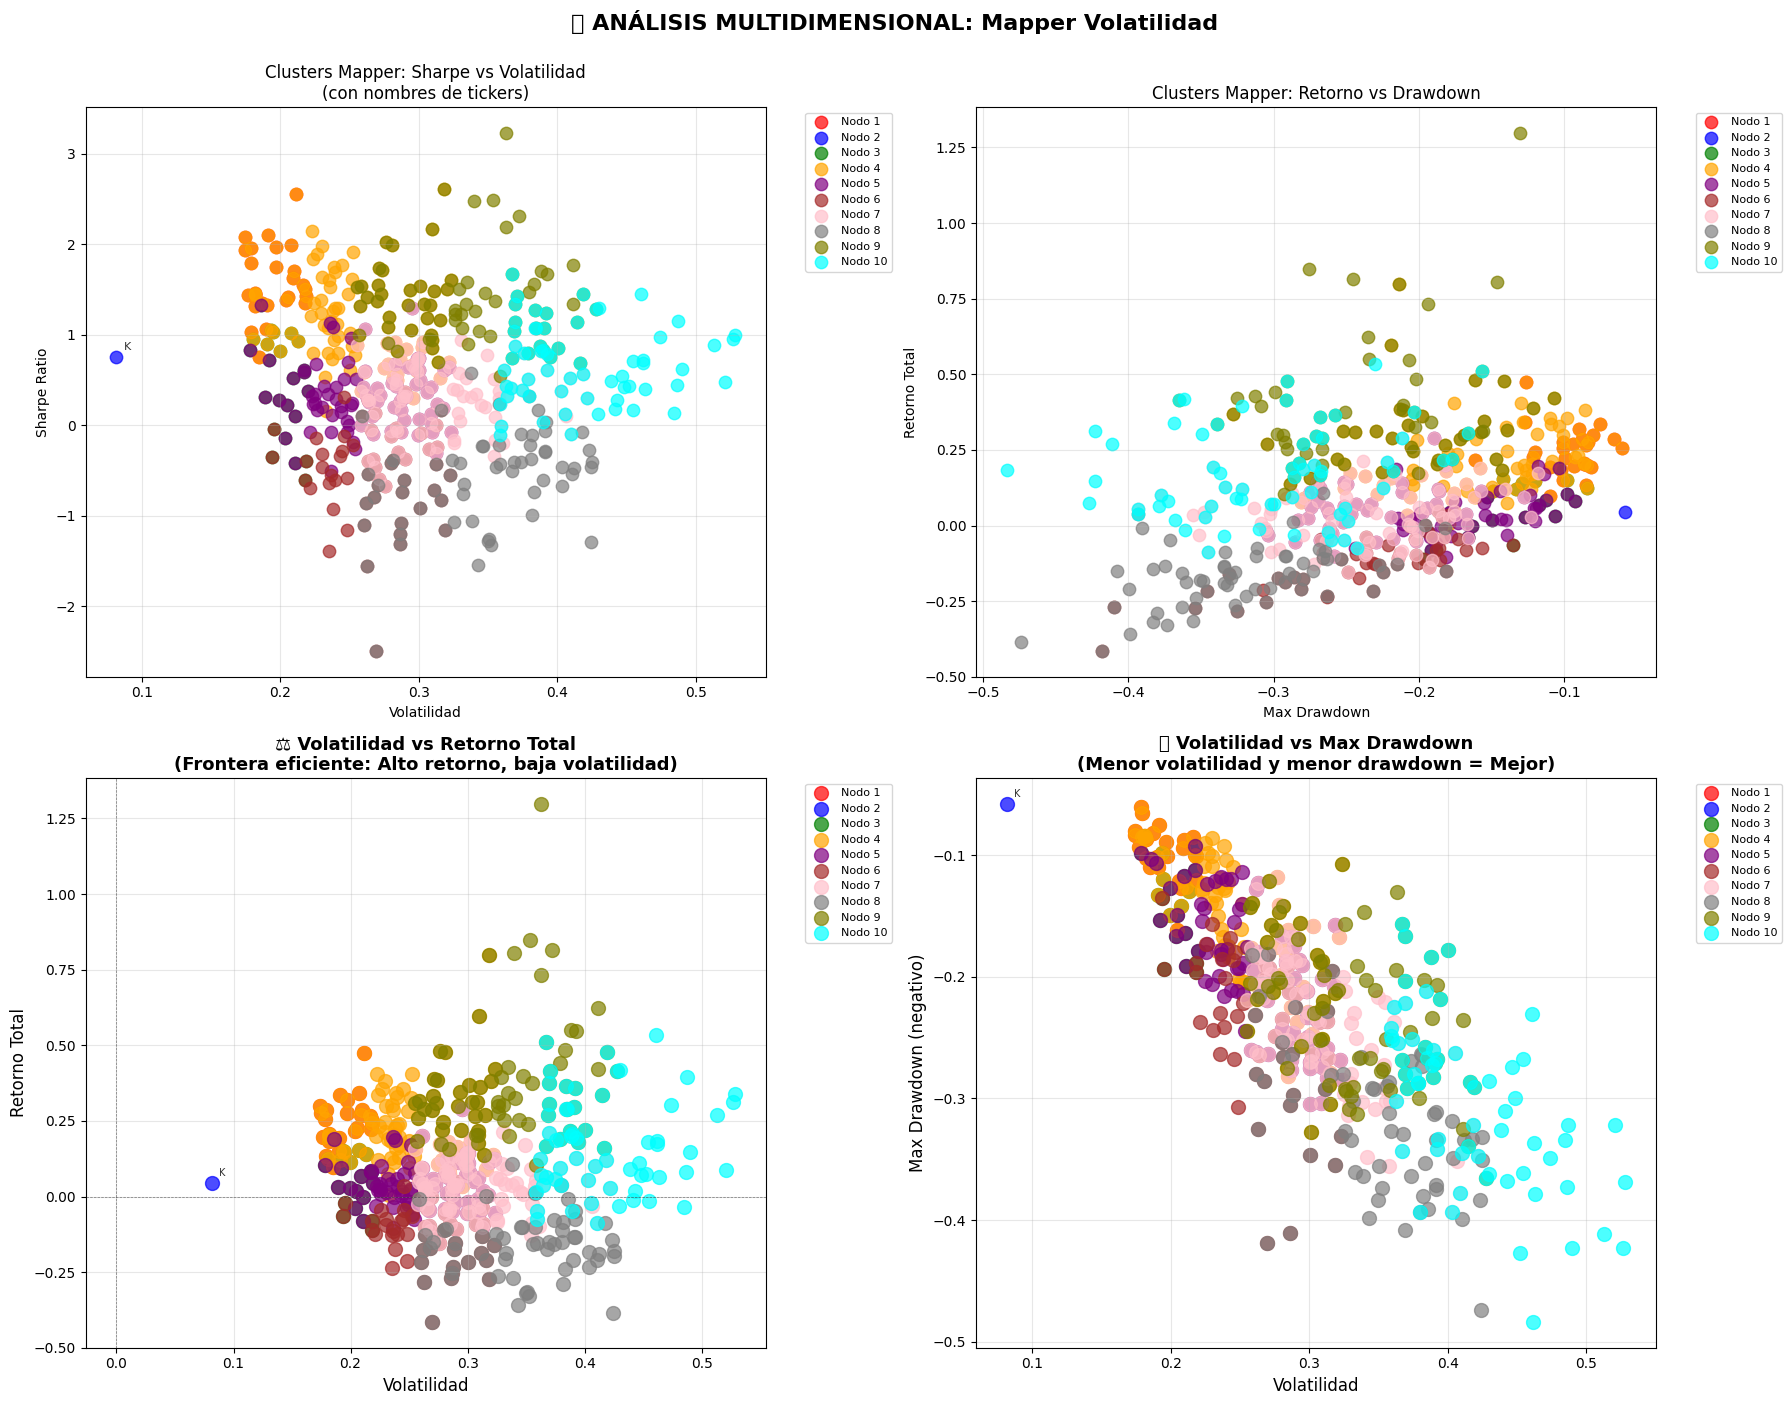

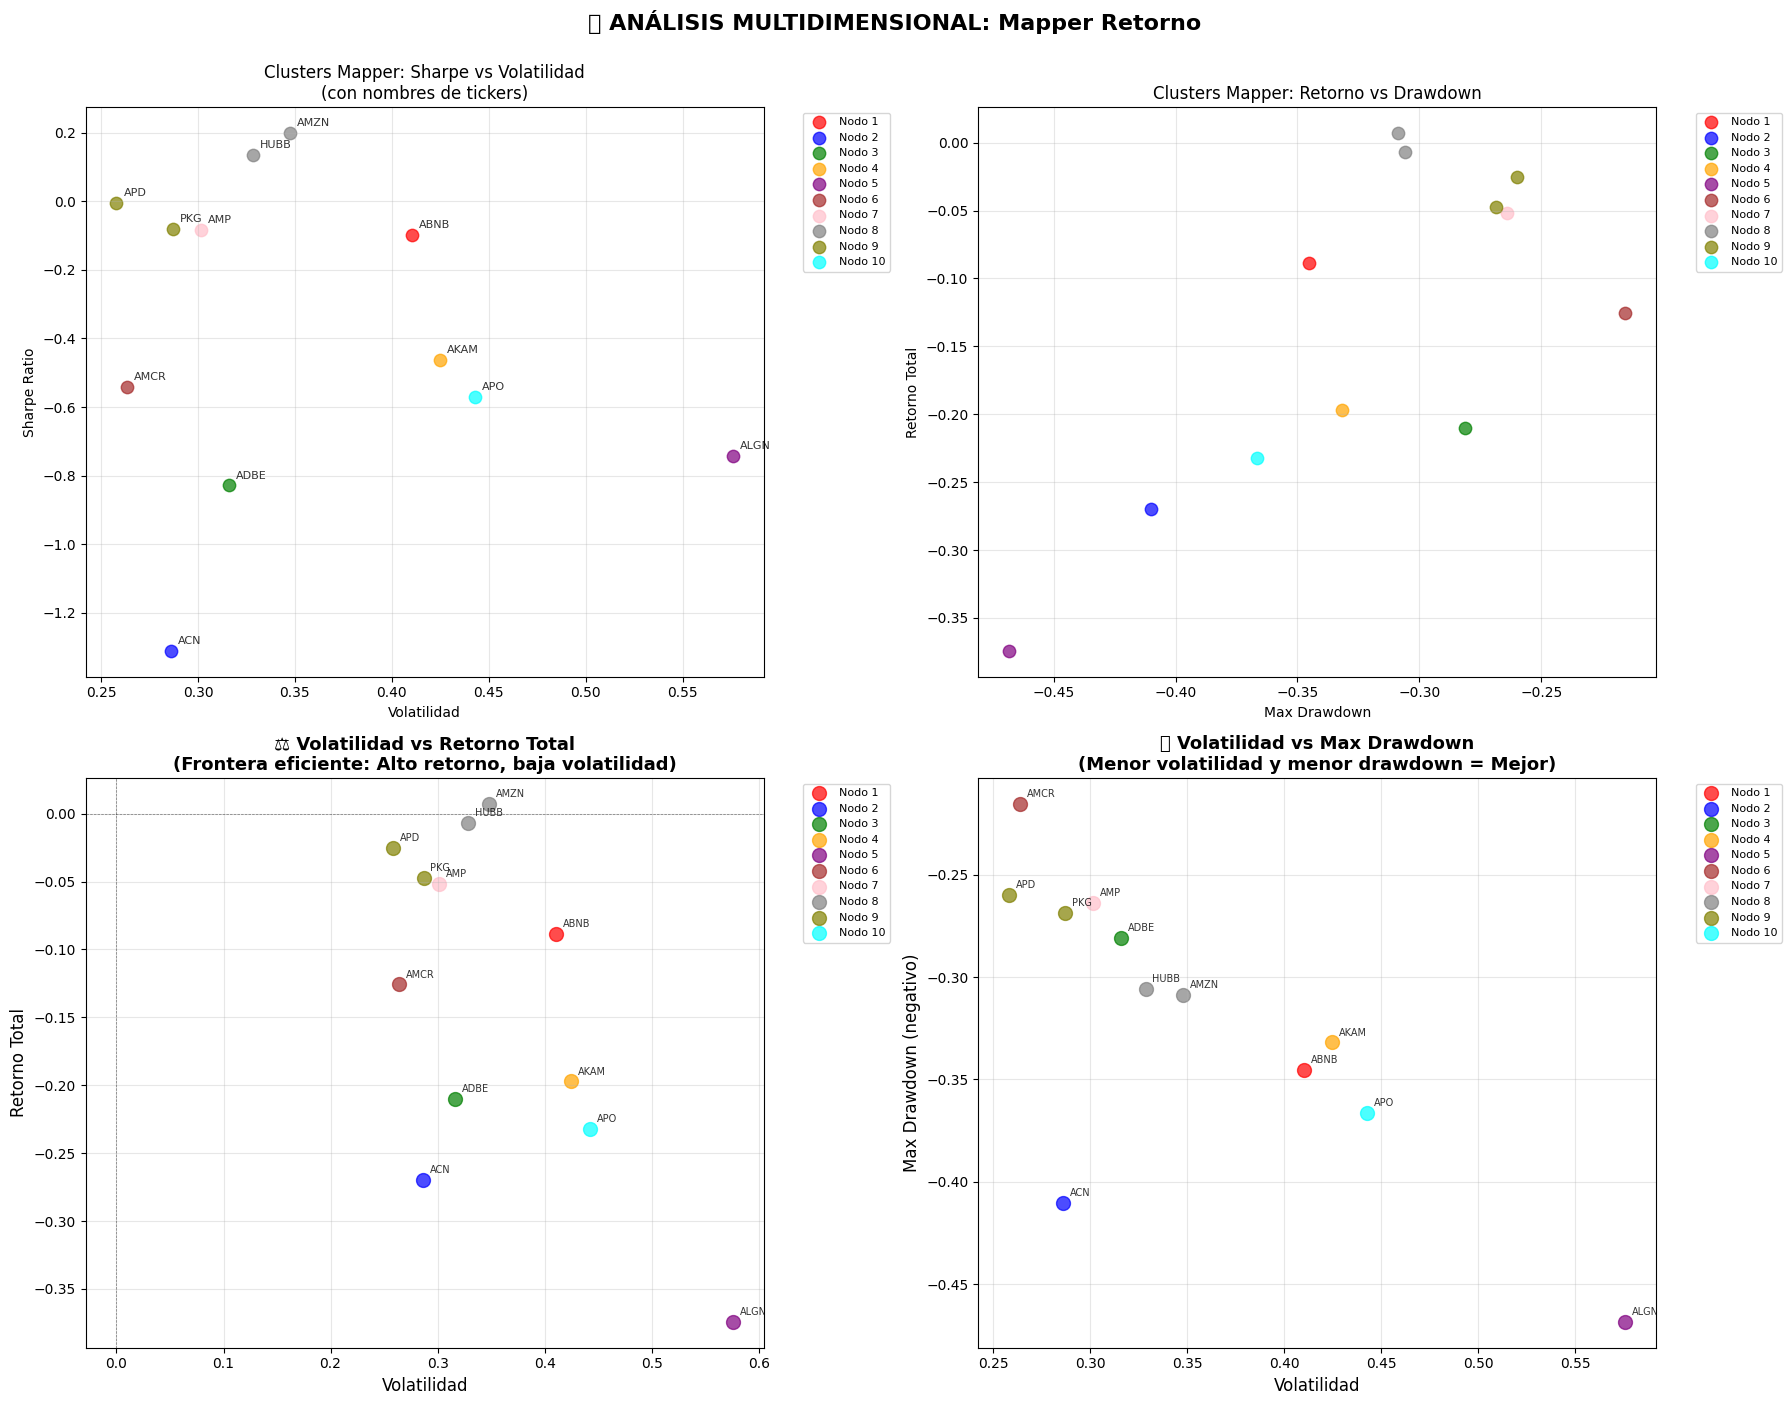

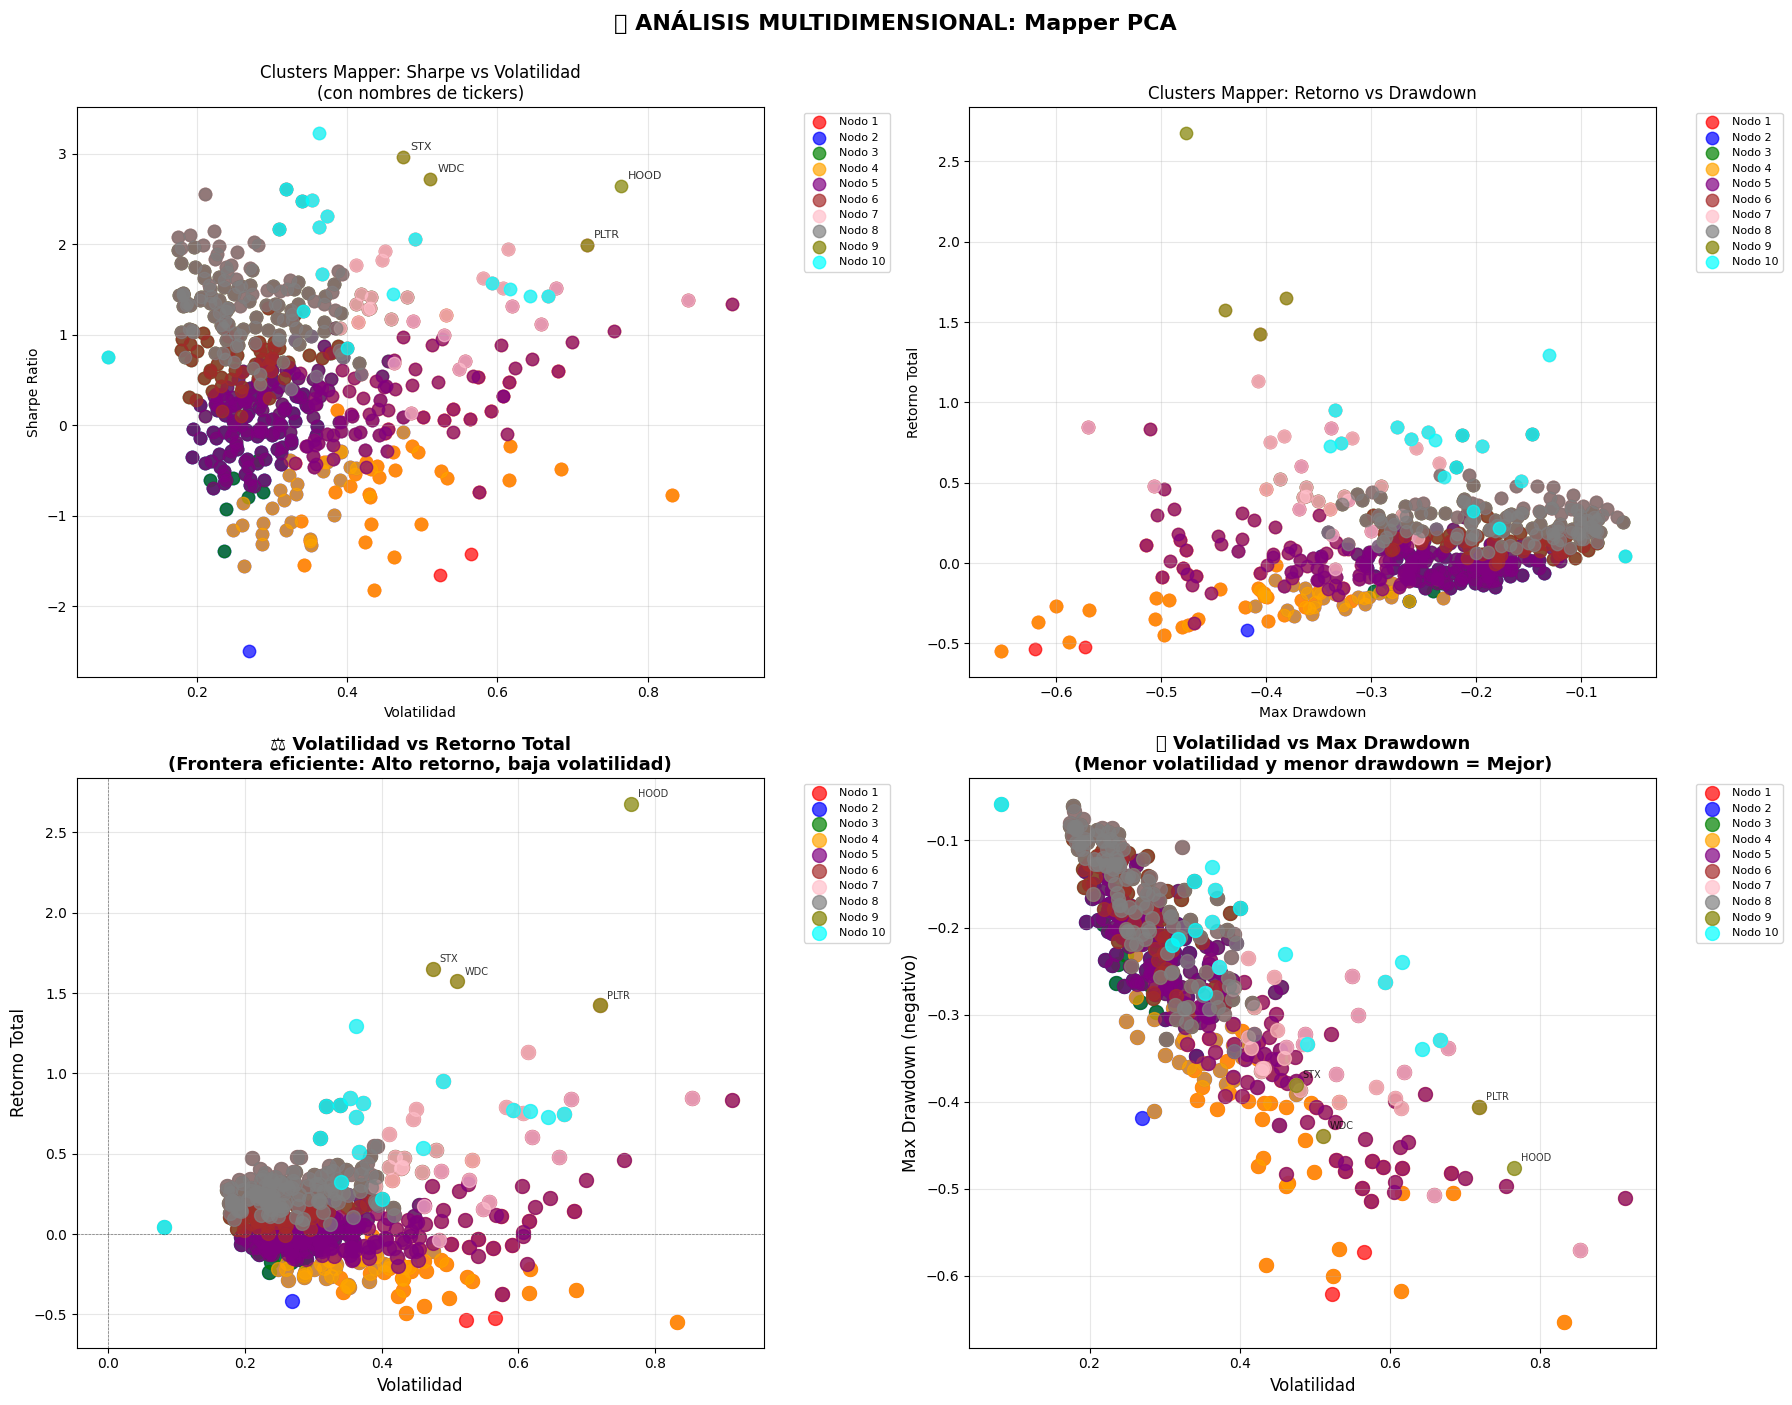

In [20]:
plot_comparacion_clusters(G, ticker_names, metrics_df,"Mapper sharpe ratio")
plot_comparacion_clusters(G_vol, ticker_names, metrics_df,"Mapper Volatilidad")
plot_comparacion_clusters(G_ret, ticker_names, metrics_df,"Mapper Retorno")
plot_comparacion_clusters(G_pca, ticker_names, metrics_df,"Mapper PCA")


## ANalissi buy and hold

In [21]:
# =======================================================
# ANÁLISIS BUY & HOLD DE CLUSTERS MAPPER
# =======================================================



def analyze_cluster_buy_and_hold(cluster_tickers, data, benchmark_ticker='SPY', cluster_name="Cluster"):
    """
    Analiza el rendimiento buy and hold de un cluster vs benchmark
    
    Args:
        cluster_tickers: Lista de tickers del cluster (ej: ['AAPL', 'MSFT', 'GOOGL'])
        data: DataFrame con precios históricos
        benchmark_ticker: Ticker del benchmark (default: SPY)
        cluster_name: Nombre descriptivo del cluster
    """
    
    print(f"📈 Analizando {cluster_name} con {len(cluster_tickers)} tickers")
    print(f"Tickers: {', '.join(cluster_tickers)}")
    
    # 1. Obtener capitalizaciones para pesos (OPTIMIZADO)
    market_caps = {}
    for ticker in cluster_tickers:
        # Buscar en el DataFrame global de capitalizaciones
        ticker_data = market_caps_global_df[market_caps_global_df['ticker'] == ticker]
        if not ticker_data.empty:
            market_caps[ticker] = ticker_data['market_cap'].iloc[0]
        else:
            market_caps[ticker] = 1e9  # fallback para tickers no encontrados
    
    total_cap = sum(market_caps.values())
    weights = {ticker: market_caps[ticker] / total_cap for ticker in cluster_tickers}
    
    print(f"\n💰 Pesos por capitalización:")
    for ticker, weight in weights.items():
        print(f"   {ticker}: {weight:.1%}")
    
    # 2. Construir curvas normalizadas (empezar en $1)
    start_value = 1
    
    # Filtrar tickers disponibles en los datos
    available_tickers = [t for t in cluster_tickers if t in data.columns]
    if not available_tickers:
        print(f"❌ No hay datos disponibles para los tickers del cluster")
        return None, None, None, None
    
    # Normalizar precios del cluster
    cluster_data = data[available_tickers].dropna()
    cluster_normalized = cluster_data / cluster_data.iloc[0]
    
    # Crear índice ponderado del cluster (solo con tickers disponibles)
    available_weights = {ticker: weights.get(ticker, 1/len(available_tickers)) for ticker in available_tickers}
    total_available_weight = sum(available_weights.values())
    available_weights = {ticker: weight/total_available_weight for ticker, weight in available_weights.items()}
    
    cluster_index = sum(cluster_normalized[ticker] * available_weights[ticker] 
                       for ticker in available_tickers) * start_value
    
    # Normalizar benchmark
    if benchmark_ticker in data.columns:
        benchmark_data = data[benchmark_ticker].dropna()
        benchmark_normalized = (benchmark_data / benchmark_data.iloc[0]) * start_value
    else:
        print(f"⚠️  Benchmark {benchmark_ticker} no disponible, usando datos sintéticos")
        benchmark_normalized = cluster_index * 0.8  # benchmark sintético
    
    # 3. Calcular métricas
    def calculate_buy_hold_metrics(prices):
        returns = prices.pct_change().dropna()
        
        # Rendimiento total
        total_return = (prices.iloc[-1] / prices.iloc[0]) - 1
        
        # Rendimiento anualizado (CAGR)
        years = len(prices) / 252  # días de trading por año
        cagr = (prices.iloc[-1] / prices.iloc[0]) ** (1/years) - 1 if years > 0 else 0
        
        # Volatilidad anualizada
        volatility = returns.std() * np.sqrt(252)
        
        # Sharpe Ratio (asumiendo RF = 2%)
        sharpe = (cagr - 0.02) / volatility if volatility > 0 else 0
        
        # Max Drawdown
        rolling_max = prices.expanding().max()
        drawdown = (prices - rolling_max) / rolling_max
        max_drawdown = drawdown.min()
        
        return {
            'total_return': total_return,
            'cagr': cagr,
            'volatility': volatility,
            'sharpe': sharpe,
            'max_drawdown': max_drawdown,
            'final_value': prices.iloc[-1]
        }
    
    cluster_metrics = calculate_buy_hold_metrics(cluster_index)
    benchmark_metrics = calculate_buy_hold_metrics(benchmark_normalized)
    
    return cluster_index, benchmark_normalized, cluster_metrics, benchmark_metrics

# =======================================================
# ANÁLISIS DE TODOS LOS CLUSTERS DEL MAPPER
# =======================================================

# sacar categorías de tickes
def extract_ticker_categories(tickers):
    categories = {}
    for ticker in tickers:
        info = yf.Ticker(ticker).info
        category = info.get('sector', 'Unknown')
        categories[ticker] = category
    return categories



def analyze_mapper_cluster(graphs, graph_names, ticker_names, categories):
    clusters={}
    print(f"\n Extrayendo clusters de mapper :")
    print(f"Total de nodos: {len(G['nodes'])}")
    for i, graph in enumerate(graphs):
        for j, (node_name, node_indices) in enumerate(graph['nodes'].items()):
            if len(node_indices) >= 2:  # Solo clusters con al menos 2 tickers
                cluster_tickers = [ticker_names[idx] for idx in node_indices]
                cluster_category = [categories[ticker_names[idx]] for idx in node_indices]
                cluster_name = f"Sharpe_Cluster_{j+1}"
                clusters[cluster_name] = {
                    'tickers': cluster_tickers,
                    'categories': cluster_category,
                    'type': graph_names[i],
                    'node_name': node_name,
                    'size': len(cluster_tickers)
                }
                print(f"     {cluster_name}: {cluster_tickers} ({len(cluster_tickers)} tickers)")


def analyze_all_mapper_clusters():
    """
    Analiza todos los clusters encontrados en los diferentes archivos Mapper
    """
    print("  ANALIZANDO TODOS LOS CLUSTERS DEL MAPPER")
    print("=" * 60)
    
    # Diccionario para almacenar todos los clusters encontrados
    all_clusters = {}
    
    # 1. Extraer clusters del grafo G (Sharpe Ratio)
    print(f"\n Extrayendo clusters del análisis por Sharpe Ratio (G):")
    print(f"Total de nodos: {len(G['nodes'])}")
    
    for i, (node_name, node_indices) in enumerate(G['nodes'].items()):
        if len(node_indices) >= 2:  # Solo clusters con al menos 2 tickers
            cluster_tickers = [ticker_names[idx] for idx in node_indices]
            cluster_name = f"Sharpe_Cluster_{i+1}"
            all_clusters[cluster_name] = {
                'tickers': cluster_tickers,
                'type': 'Sharpe Ratio',
                'node_name': node_name,
                'size': len(cluster_tickers)
            }
            print(f"     {cluster_name}: {cluster_tickers} ({len(cluster_tickers)} tickers)")
    
    # 2. Extraer clusters del grafo G_vol (Volatilidad)
    print(f"\n Extrayendo clusters del análisis por Volatilidad (G_vol):")
    print(f"Total de nodos: {len(G_vol['nodes'])}")
    
    for i, (node_name, node_indices) in enumerate(G_vol['nodes'].items()):
        if len(node_indices) >= 2:
            cluster_tickers = [ticker_names[idx] for idx in node_indices]
            cluster_name = f"Vol_Cluster_{i+1}"
            all_clusters[cluster_name] = {
                'tickers': cluster_tickers,
                'type': 'Volatilidad',
                'node_name': node_name,
                'size': len(cluster_tickers)
            }
            print(f"     {cluster_name}: {cluster_tickers} ({len(cluster_tickers)} tickers)")
    
    # 3. Extraer clusters del grafo G_ret (Retorno)
    print(f"\n Extrayendo clusters del análisis por Retorno (G_ret):")
    print(f"Total de nodos: {len(G_ret['nodes'])}")
    
    for i, (node_name, node_indices) in enumerate(G_ret['nodes'].items()):
        if len(node_indices) >= 2:
            cluster_tickers = [ticker_names[idx] for idx in node_indices]
            cluster_name = f"Return_Cluster_{i+1}"
            all_clusters[cluster_name] = {
                'tickers': cluster_tickers,
                'type': 'Retorno Total',
                'node_name': node_name,
                'size': len(cluster_tickers)
            }
            print(f"     {cluster_name}: {cluster_tickers} ({len(cluster_tickers)} tickers)")
    
    # 4. Extraer clusters del grafo G_pca (PCA)
    print(f"\n🔬 Extrayendo clusters del análisis PCA (G_pca):")
    print(f"Total de nodos: {len(G_pca['nodes'])}")
    
    for i, (node_name, node_indices) in enumerate(G_pca['nodes'].items()):
        if len(node_indices) >= 2:
            cluster_tickers = [ticker_names[idx] for idx in node_indices]
            cluster_name = f"PCA_Cluster_{i+1}"
            all_clusters[cluster_name] = {
                'tickers': cluster_tickers,
                'type': 'PCA',
                'node_name': node_name,
                'size': len(cluster_tickers)
            }
            print(f"     {cluster_name}: {cluster_tickers} ({len(cluster_tickers)} tickers)")
    
    print(f"\n📋 RESUMEN: {len(all_clusters)} clusters encontrados en total")
    return all_clusters

# Ejecutar análisis de clusters
mapper_clusters = analyze_all_mapper_clusters()

  ANALIZANDO TODOS LOS CLUSTERS DEL MAPPER

 Extrayendo clusters del análisis por Sharpe Ratio (G):
Total de nodos: 12
     Sharpe_Cluster_1: ['ACN', 'CAG', 'CLX', 'CMG', 'CPB', 'CPRT', 'CRM', 'DOW', 'EPAM', 'FDS', 'IFF', 'OKE', 'TGT'] (13 tickers)
     Sharpe_Cluster_2: ['DECK', 'FI', 'GDDY', 'HRL', 'IT', 'KMX', 'LULU', 'STZ'] (8 tickers)
     Sharpe_Cluster_3: ['AKAM', 'ALGN', 'BAX', 'BDX', 'CHTR', 'CNC', 'DECK', 'DOW', 'EMN', 'EPAM', 'FI', 'GDDY', 'GPN', 'IT', 'KKR', 'KMX', 'LKQ', 'LULU', 'MOH', 'MRNA', 'ON', 'REGN', 'STZ', 'TPL', 'TTD', 'UNH', 'UPS', 'ZBRA'] (28 tickers)
     Sharpe_Cluster_4: ['ACN', 'ADBE', 'AMCR', 'APO', 'ARE', 'AVB', 'AVY', 'BALL', 'BF-B', 'BMY', 'BRO', 'CAG', 'CARR', 'CDW', 'CHD', 'CL', 'CLX', 'CMCSA', 'CMG', 'COO', 'CPAY', 'CPB', 'CPRT', 'CPT', 'CRM', 'CTSH', 'DHR', 'DOV', 'DVA', 'DXCM', 'EIX', 'EOG', 'EQIX', 'EQR', 'ERIE', 'FDX', 'FIS', 'FRT', 'FTV', 'GIS', 'GWW', 'HON', 'HPQ', 'HRL', 'HSIC', 'IEX', 'IFF', 'INVH', 'IP', 'IR', 'ISRG', 'JBHT', 'JKHY', 'KDP', '

In [22]:
# =======================================================
# OPTIMIZACIÓN: CARGAR TODAS LAS CAPITALIZACIONES DE UNA VEZ
# =======================================================

def get_all_market_caps(tickers_list):
    """
    Obtiene las capitalizaciones de mercado de todos los tickers de una sola vez
    y las almacena en un DataFrame para reutilización
    """
    print("📊 Descargando capitalizaciones de mercado para todos los tickers...")
    market_caps_data = []
    
    # Procesar en lotes para evitar sobrecargar la API
    batch_size = 20
    total_batches = len(tickers_list) // batch_size + (1 if len(tickers_list) % batch_size else 0)
    
    for batch_num in range(total_batches):
        start_idx = batch_num * batch_size
        end_idx = min((batch_num + 1) * batch_size, len(tickers_list))
        batch_tickers = tickers_list[start_idx:end_idx]
        
        print(f"   Procesando lote {batch_num + 1}/{total_batches} ({len(batch_tickers)} tickers)")
        
        for ticker in batch_tickers:
            try:
                info = yf.Ticker(ticker).info
                market_cap = info.get('marketCap', None)
                
                # Validar que market_cap sea un número válido
                if market_cap and isinstance(market_cap, (int, float)) and market_cap > 0:
                    market_caps_data.append({
                        'ticker': ticker,
                        'market_cap': market_cap,
                        'status': 'success'
                    })
                else:
                    # Usar capitalización estimada basada en precio y volumen si está disponible
                    shares_outstanding = info.get('sharesOutstanding', None)
                    current_price = info.get('regularMarketPrice', info.get('previousClose', None))
                    
                    if shares_outstanding and current_price:
                        estimated_cap = shares_outstanding * current_price
                        market_caps_data.append({
                            'ticker': ticker,
                            'market_cap': estimated_cap,
                            'status': 'estimated'
                        })
                    else:
                        # Fallback: usar valor promedio basado en otros tickers
                        market_caps_data.append({
                            'ticker': ticker,
                            'market_cap': 1e9,  # $1B como fallback
                            'status': 'fallback'
                        })
                        
            except Exception as e:
                print(f"      ⚠️ Error con {ticker}: {e}")
                market_caps_data.append({
                    'ticker': ticker,
                    'market_cap': 1e9,  # $1B como fallback
                    'status': 'error'
                })
    
    # Crear DataFrame
    market_caps_df = pd.DataFrame(market_caps_data)
    
    # Estadísticas
    success_count = len(market_caps_df[market_caps_df['status'] == 'success'])
    estimated_count = len(market_caps_df[market_caps_df['status'] == 'estimated'])
    fallback_count = len(market_caps_df[market_caps_df['status'].isin(['fallback', 'error'])])
    
    print(f"\n✅ Descarga completada:")
    print(f"   📈 Exitosos: {success_count}")
    print(f"   📊 Estimados: {estimated_count}")  
    print(f"   🔄 Fallbacks: {fallback_count}")
    print(f"   📋 Total: {len(market_caps_df)}")
    
    return market_caps_df

# Cargar todas las capitalizaciones (solo una vez)
if 'market_caps_global_df' not in globals():
    market_caps_global_df = get_all_market_caps(ticker_names)
    print("\n💾 Capitalizaciones guardadas en 'market_caps_global_df'")
else:
    print("✅ Usando capitalizaciones previamente cargadas")

# Mostrar muestra del DataFrame
print(f"\n📋 Muestra de las capitalizaciones:")
print(market_caps_global_df.head(10))
print(f"\n📊 Estadísticas de las capitalizaciones:")
print(f"   💰 Capitalización promedio: ${market_caps_global_df['market_cap'].mean():,.0f}")
print(f"   📈 Capitalización máxima: ${market_caps_global_df['market_cap'].max():,.0f}")
print(f"   📉 Capitalización mínima: ${market_caps_global_df['market_cap'].min():,.0f}")

📊 Descargando capitalizaciones de mercado para todos los tickers...
   Procesando lote 1/26 (20 tickers)
   Procesando lote 2/26 (20 tickers)
   Procesando lote 2/26 (20 tickers)
   Procesando lote 3/26 (20 tickers)
   Procesando lote 3/26 (20 tickers)
   Procesando lote 4/26 (20 tickers)
   Procesando lote 4/26 (20 tickers)
   Procesando lote 5/26 (20 tickers)
   Procesando lote 5/26 (20 tickers)
   Procesando lote 6/26 (20 tickers)
   Procesando lote 6/26 (20 tickers)
   Procesando lote 7/26 (20 tickers)
   Procesando lote 7/26 (20 tickers)
   Procesando lote 8/26 (20 tickers)
   Procesando lote 8/26 (20 tickers)
   Procesando lote 9/26 (20 tickers)
   Procesando lote 9/26 (20 tickers)
   Procesando lote 10/26 (20 tickers)
   Procesando lote 10/26 (20 tickers)
   Procesando lote 11/26 (20 tickers)
   Procesando lote 11/26 (20 tickers)
   Procesando lote 12/26 (20 tickers)
   Procesando lote 12/26 (20 tickers)
   Procesando lote 13/26 (20 tickers)
   Procesando lote 13/26 (20 tickers)

In [23]:
# =======================================================
# FUNCIONES AUXILIARES OPTIMIZADAS
# =======================================================

'''def get_cluster_weights_fast(cluster_tickers, market_caps_df):
    """
    Obtiene los pesos de capitalización de mercado para un cluster de manera optimizada
    """
    # Filtrar el DataFrame para obtener solo los tickers del cluster
    cluster_caps = market_caps_df[market_caps_df['ticker'].isin(cluster_tickers)].copy()
    
    # Si faltan algunos tickers, agregarlos con valor por defecto
    missing_tickers = set(cluster_tickers) - set(cluster_caps['ticker'])
    if missing_tickers:
        for ticker in missing_tickers:
            cluster_caps = pd.concat([cluster_caps, pd.DataFrame({
                'ticker': [ticker],
                'market_cap': [1e9],  # $1B por defecto
                'status': ['missing']
            })], ignore_index=True)
    
    # Calcular pesos
    total_cap = cluster_caps['market_cap'].sum()
    cluster_caps['weight'] = cluster_caps['market_cap'] / total_cap
    
    # Convertir a diccionario para compatibilidad
    weights = dict(zip(cluster_caps['ticker'], cluster_caps['weight']))
    market_caps = dict(zip(cluster_caps['ticker'], cluster_caps['market_cap']))
    
    return weights, market_caps'''

'''def analyze_cluster_buy_and_hold_fast(cluster_tickers, data, benchmark_ticker, cluster_name="Cluster"):
    """
    Versión optimizada de analyze_cluster_buy_and_hold que usa el DataFrame global de capitalizaciones
    """
    print(f" Analizando {cluster_name} con {len(cluster_tickers)} tickers")
    print(f"Tickers: {', '.join(cluster_tickers)}")
    
    # 1. Obtener capitalizaciones para pesos (OPTIMIZADO)
    weights, market_caps = get_cluster_weights_fast(cluster_tickers, market_caps_global_df)
    
    print(f"\n Pesos por capitalización:")
    for ticker, weight in weights.items():
        print(f"   {ticker}: {weight:.1%}")
    
    # 2. Construir curvas normalizadas (empezar en $1)
    start_value = 1
    
    # Filtrar tickers disponibles en los datos
    available_tickers = [t for t in cluster_tickers if t in data.columns]
    if not available_tickers:
        print(f"❌ No hay datos disponibles para los tickers del cluster")
        return None, None, None, None
    
    # Normalizar precios del cluster
    cluster_data = data[available_tickers].dropna()
    cluster_normalized = cluster_data / cluster_data.iloc[0]
    
    # Crear índice ponderado del cluster (solo con tickers disponibles)
    available_weights = {ticker: weights.get(ticker, 1/len(available_tickers)) for ticker in available_tickers}
    total_available_weight = sum(available_weights.values())
    available_weights = {ticker: weight/total_available_weight for ticker, weight in available_weights.items()}
    
    cluster_index = sum(cluster_normalized[ticker] * available_weights[ticker] 
                       for ticker in available_tickers) * start_value
    
    # Normalizar benchmark
    
    benchmark_ticker = benchmark_ticker.dropna()
    benchmark_normalized = (benchmark_ticker / benchmark_ticker.iloc[0]) * start_value
    
    
    # 3. Calcular métricas (función interna optimizada)
    def calculate_buy_hold_metrics(prices):
        returns = prices.pct_change().dropna()
        
        # Rendimiento total
        total_return = (prices.iloc[-1] / prices.iloc[0]) - 1
        
        # Rendimiento anualizado (CAGR)
        years = len(prices) / 252  # días de trading por año
        cagr = (prices.iloc[-1] / prices.iloc[0]) ** (1/years) - 1 if years > 0 else 0
        
        # Volatilidad anualizada
        volatility = returns.std() * np.sqrt(252)
        
        # Sharpe Ratio (asumiendo RF = 2%)
        sharpe = (cagr - 0.02) / volatility if volatility > 0 else 0
        
        # Max Drawdown
        rolling_max = prices.expanding().max()
        drawdown = (prices - rolling_max) / rolling_max
        max_drawdown = drawdown.min()
        
        return {
            'total_return': total_return,
            'cagr': cagr,
            'volatility': volatility,
            'sharpe': sharpe,
            'max_drawdown': max_drawdown,
            'final_value': prices.iloc[-1]
        }
    
    cluster_metrics = calculate_buy_hold_metrics(cluster_index)
    benchmark_metrics = calculate_buy_hold_metrics(benchmark_normalized)
    
    return cluster_index, benchmark_normalized, cluster_metrics, benchmark_metrics'''

'def analyze_cluster_buy_and_hold_fast(cluster_tickers, data, benchmark_ticker, cluster_name="Cluster"):\n    """\n    Versión optimizada de analyze_cluster_buy_and_hold que usa el DataFrame global de capitalizaciones\n    """\n    print(f" Analizando {cluster_name} con {len(cluster_tickers)} tickers")\n    print(f"Tickers: {\', \'.join(cluster_tickers)}")\n\n    # 1. Obtener capitalizaciones para pesos (OPTIMIZADO)\n    weights, market_caps = get_cluster_weights_fast(cluster_tickers, market_caps_global_df)\n\n    print(f"\n Pesos por capitalización:")\n    for ticker, weight in weights.items():\n        print(f"   {ticker}: {weight:.1%}")\n\n    # 2. Construir curvas normalizadas (empezar en $1)\n    start_value = 1\n\n    # Filtrar tickers disponibles en los datos\n    available_tickers = [t for t in cluster_tickers if t in data.columns]\n    if not available_tickers:\n        print(f"❌ No hay datos disponibles para los tickers del cluster")\n        return None, None, None, None\n\n

##  Optimización de Rendimiento



In [24]:
### descargar datos de SPY

spy_curve = yf.download('SPY', start=START_DATE, progress=False)['Close']
tickers_data['SPY'] = spy_curve
print("✅ Datos de SPY descargados y añadidos a tickers_data")

✅ Datos de SPY descargados y añadidos a tickers_data


In [25]:
# =======================================================
# FUNCIONES NECESARIAS PARA EL ANÁLISIS DE CLUSTERS
# =======================================================

def get_cluster_weights_fast(cluster_tickers, market_caps_df):
    """
    Obtiene los pesos de capitalización de mercado para un cluster de manera optimizada
    """
    # Filtrar el DataFrame para obtener solo los tickers del cluster
    cluster_caps = market_caps_df[market_caps_df['ticker'].isin(cluster_tickers)].copy()
    
    # Si faltan algunos tickers, agregarlos con valor por defecto
    missing_tickers = set(cluster_tickers) - set(cluster_caps['ticker'])
    if missing_tickers:
        for ticker in missing_tickers:
            cluster_caps = pd.concat([cluster_caps, pd.DataFrame({
                'ticker': [ticker],
                'market_cap': [1e9],  # $1B por defecto
                'status': ['missing']
            })], ignore_index=True)
    
    # Calcular pesos
    total_cap = cluster_caps['market_cap'].sum()
    cluster_caps['weight'] = cluster_caps['market_cap'] / total_cap
    
    # Convertir a diccionario para compatibilidad
    weights = dict(zip(cluster_caps['ticker'], cluster_caps['weight']))
    market_caps = dict(zip(cluster_caps['ticker'], cluster_caps['market_cap']))
    
    return weights, market_caps

def analyze_cluster_buy_and_hold_fast(cluster_tickers, data, benchmark_ticker='SPY', cluster_name="Cluster"):
    """
    Versión optimizada de analyze_cluster_buy_and_hold que usa el DataFrame global de capitalizaciones
    """
    print(f"📈 Analizando {cluster_name} con {len(cluster_tickers)} tickers")
    print(f"Tickers: {', '.join(cluster_tickers)}")
    
    # 1. Obtener capitalizaciones para pesos (OPTIMIZADO)
    weights, market_caps = get_cluster_weights_fast(cluster_tickers, market_caps_global_df)
    
    print(f"\n💰 Pesos por capitalización:")
    for ticker, weight in weights.items():
        print(f"   {ticker}: {weight:.1%}")
    
    # 2. Construir curvas normalizadas (empezar en $1)
    start_value = 1
    
    # Filtrar tickers disponibles en los datos
    available_tickers = [t for t in cluster_tickers if t in data.columns]
    if not available_tickers:
        print(f"❌ No hay datos disponibles para los tickers del cluster")
        return None, None, None, None
    
    # Normalizar precios del cluster
    cluster_data = data[available_tickers].dropna()
    cluster_normalized = cluster_data / cluster_data.iloc[0]
    
    # Crear índice ponderado del cluster (solo con tickers disponibles)
    available_weights = {ticker: weights.get(ticker, 1/len(available_tickers)) for ticker in available_tickers}
    total_available_weight = sum(available_weights.values())
    available_weights = {ticker: weight/total_available_weight for ticker, weight in available_weights.items()}
    
    cluster_index = sum(cluster_normalized[ticker] * available_weights[ticker] 
                       for ticker in available_tickers) * start_value
    
    # Normalizar benchmark
    if benchmark_ticker in data.columns:
        benchmark_data = data[benchmark_ticker].dropna()
        benchmark_normalized = (benchmark_data / benchmark_data.iloc[0]) * start_value
    else:
        print(f"⚠️  Benchmark {benchmark_ticker} no disponible, usando datos sintéticos")
        benchmark_normalized = cluster_index * 0.8  # benchmark sintético
    
    # 3. Calcular métricas (función interna optimizada)
    def calculate_buy_hold_metrics(prices):
        returns = prices.pct_change().dropna()
        
        # Rendimiento total
        total_return = (prices.iloc[-1] / prices.iloc[0]) - 1
        
        # Rendimiento anualizado (CAGR)
        years = len(prices) / 252  # días de trading por año
        cagr = (prices.iloc[-1] / prices.iloc[0]) ** (1/years) - 1 if years > 0 else 0
        
        # Volatilidad anualizada
        volatility = returns.std() * np.sqrt(252)
        
        # Sharpe Ratio (asumiendo RF = 2%)
        sharpe = (cagr - 0.02) / volatility if volatility > 0 else 0
        
        # Max Drawdown
        rolling_max = prices.expanding().max()
        drawdown = (prices - rolling_max) / rolling_max
        max_drawdown = drawdown.min()
        
        return {
            'total_return': total_return,
            'cagr': cagr,
            'volatility': volatility,
            'sharpe': sharpe,
            'max_drawdown': max_drawdown,
            'final_value': prices.iloc[-1]
        }
    
    cluster_metrics = calculate_buy_hold_metrics(cluster_index)
    benchmark_metrics = calculate_buy_hold_metrics(benchmark_normalized)
    
    return cluster_index, benchmark_normalized, cluster_metrics, benchmark_metrics

print("✅ Funciones de análisis de clusters cargadas")

✅ Funciones de análisis de clusters cargadas


In [26]:
# =======================================================
# PREPARACIÓN FINAL PARA EL ANÁLISIS DE CLUSTERS
# =======================================================

# Asegurar que SPY esté en los datos
if 'SPY' not in tickers_data.columns:
    print("📥 Descargando datos de SPY...")
    spy_data = yf.download('SPY', start=START_DATE, progress=False)['Close']
    tickers_data['SPY'] = spy_data
    print("✅ SPY añadido a tickers_data")
else:
    print("✅ SPY ya está disponible en tickers_data")

# Verificar que tenemos todas las variables necesarias
required_vars = ['mapper_clusters', 'market_caps_global_df', 'tickers_data']
missing_vars = []

for var in required_vars:
    if var not in globals():
        missing_vars.append(var)

if missing_vars:
    print(f"❌ Variables faltantes: {missing_vars}")
    print("🔧 Ejecuta las celdas anteriores para generar estas variables")
else:
    print("✅ Todas las variables necesarias están disponibles")
    print(f"📊 Listo para analizar {len(mapper_clusters)} clusters")
    
    # Mostrar resumen de los clusters disponibles
    print(f"\n📋 CLUSTERS DISPONIBLES:")
    for cluster_name, cluster_info in list(mapper_clusters.items())[:5]:  # Mostrar primeros 5
        print(f"   • {cluster_name}: {len(cluster_info['tickers'])} tickers ({cluster_info['type']})")
    
    if len(mapper_clusters) > 5:
        print(f"   ... y {len(mapper_clusters) - 5} clusters más")

print("\n🚀 Ahora puedes ejecutar el análisis completo de clusters")

✅ SPY ya está disponible en tickers_data
✅ Todas las variables necesarias están disponibles
📊 Listo para analizar 75 clusters

📋 CLUSTERS DISPONIBLES:
   • Sharpe_Cluster_1: 13 tickers (Sharpe Ratio)
   • Sharpe_Cluster_2: 8 tickers (Sharpe Ratio)
   • Sharpe_Cluster_3: 28 tickers (Sharpe Ratio)
   • Sharpe_Cluster_4: 86 tickers (Sharpe Ratio)
   • Sharpe_Cluster_5: 213 tickers (Sharpe Ratio)
   ... y 70 clusters más

🚀 Ahora puedes ejecutar el análisis completo de clusters


In [27]:
# =======================================================
# EJECUTAR ANÁLISIS COMPLETO DE CLUSTERS
# =======================================================

print("ANÁLISIS BUY & HOLD DE TODOS LOS CLUSTERS")
print("=" * 50)

# Diccionario para almacenar resultados
cluster_analysis_results = {}

# Analizar cada cluster encontrado
for cluster_name, cluster_info in mapper_clusters.items():
    print(f"\n{'='*50}")
    print(f"----- Analizando: {cluster_name}")
    print(f"{'='*50}")
    
    try:
        # Ejecutar análisis buy & hold (VERSIÓN OPTIMIZADA)
        cluster_curve, benchmark_curve, cluster_metrics, benchmark_metrics = analyze_cluster_buy_and_hold_fast(
            cluster_tickers=cluster_info['tickers'],
            data=tickers_data,
            benchmark_ticker='SPY',
            cluster_name=cluster_name
        )
        
        if cluster_curve is not None:
            # Guardar resultados
            cluster_analysis_results[cluster_name] = {
                'cluster_curve': cluster_curve,
                'benchmark_curve': benchmark_curve,
                'cluster_metrics': cluster_metrics,
                'benchmark_metrics': benchmark_metrics,
                'cluster_info': cluster_info
            }
            
            # Mostrar resumen
            print(f"\n✅ RESUMEN {cluster_name}:")
            print(f"    Retorno Total: {cluster_metrics['total_return']:.2%}")
            print(f"    CAGR: {cluster_metrics['cagr']:.2%}")
            print(f"    Sharpe: {cluster_metrics['sharpe']:.2f}")
            print(f"    Max DD: {cluster_metrics['max_drawdown']:.2%}")
            print(f"    Valor Final: ${cluster_metrics['final_value']:.2f}")
            
            # Comparación vs benchmark
            outperformance = cluster_metrics['total_return'] - benchmark_metrics['total_return']
            print(f"\n   🏆 vs SPY: {outperformance:.2%}")
            
        else:
            print(f"⚠️  No se pudo analizar {cluster_name} (datos insuficientes)")
            
    except Exception as e:
        print(f"❌ Error analizando {cluster_name}: {e}")
        import traceback
        traceback.print_exc()

print(f"\n{'='*70}")
print(f"✅ ANÁLISIS COMPLETADO")
print(f"{'='*70}")
print(f"Total clusters analizados exitosamente: {len(cluster_analysis_results)}")

if cluster_analysis_results:
    # Ranking por Sharpe Ratio
    print(f"\n🏆 TOP 10 CLUSTERS POR SHARPE RATIO:")
    sorted_clusters = sorted(cluster_analysis_results.items(), 
                           key=lambda x: x[1]['cluster_metrics']['sharpe'], 
                           reverse=True)
    
    for i, (name, results) in enumerate(sorted_clusters[:10], 1):
        metrics = results['cluster_metrics']
        print(f"   {i}. {name}: Sharpe={metrics['sharpe']:.2f}, "
              f"Return={metrics['total_return']:.1%}, Final=${metrics['final_value']:.2f}")
else:
    print("\n⚠️  No hay clusters para analizar")


ANÁLISIS BUY & HOLD DE TODOS LOS CLUSTERS

----- Analizando: Sharpe_Cluster_1
📈 Analizando Sharpe_Cluster_1 con 13 tickers
Tickers: ACN, CAG, CLX, CMG, CPB, CPRT, CRM, DOW, EPAM, FDS, IFF, OKE, TGT

💰 Pesos por capitalización:
   ACN: 23.1%
   CAG: 1.4%
   CLX: 2.2%
   CMG: 8.6%
   CPB: 1.4%
   CPRT: 6.6%
   CRM: 36.1%
   DOW: 2.4%
   EPAM: 1.2%
   FDS: 1.6%
   IFF: 2.4%
   OKE: 6.7%
   TGT: 6.2%

✅ RESUMEN Sharpe_Cluster_1:
    Retorno Total: -27.87%
    CAGR: -35.02%
    Sharpe: -1.63
    Max DD: -32.77%
    Valor Final: $0.72

   🏆 vs SPY: -43.32%

----- Analizando: Sharpe_Cluster_2
📈 Analizando Sharpe_Cluster_2 con 8 tickers
Tickers: DECK, FI, GDDY, HRL, IT, KMX, LULU, STZ

💰 Pesos por capitalización:
   DECK: 8.0%
   FI: 36.7%
   GDDY: 10.0%
   HRL: 7.2%
   IT: 10.2%
   KMX: 3.5%
   LULU: 11.0%
   STZ: 13.5%

✅ RESUMEN Sharpe_Cluster_2:
    Retorno Total: -40.34%
    CAGR: -49.42%
    Sharpe: -2.03
    Max DD: -42.54%
    Valor Final: $0.60

   🏆 vs SPY: -55.80%

----- Analizando:

In [28]:
### descargar datos de SPY

spy_curve = yf.download('SPY', start=START_DATE, progress=False)['Close']
tickers_data['SPY'] = spy_curve
print("✅ Datos de SPY descargados y añadidos a tickers_data")

✅ Datos de SPY descargados y añadidos a tickers_data


In [29]:
def create_cluster_comparison_plot(cluster_analysis_results, benchmarks=['SPY']):
    """
    Crea una visualización comparativa similar al código original pero para clusters
    """
    print(" CREANDO VISUALIZACIÓN COMPARATIVA DE CLUSTERS")
    print("=" * 60)
    
    # Preparar datos de benchmarks
    benchmark_curves = {}
    for benchmark in benchmarks:
        if benchmark in tickers_data.columns:
            benchmark_data = tickers_data[benchmark].dropna()
            benchmark_curves[benchmark] = (benchmark_data / benchmark_data.iloc[0])
    
    # Configuración de la gráfica principal
    plt.figure(figsize=(14, 16))
    
    # Colores para diferentes tipos de clusters
    colors = {
        'Sharpe Ratio': 'blue',
        'Volatilidad': 'red', 
        'Retorno Total': 'green',
        'PCA': 'orange'
    }
    
    # Plotear clusters
    cluster_performance = []
    
    for cluster_name, results in cluster_analysis_results.items():
        if results is not None:
            cluster_curve = results['cluster_curve']
            cluster_metrics = results['cluster_metrics']
            cluster_info = results['cluster_info']
            
            # Plotear curva del cluster
            color = colors.get(cluster_info['type'], 'gray')
            alpha = 0.8 if cluster_metrics['sharpe'] > 1.0 else 0.6
            linewidth = 2.5 if cluster_metrics['sharpe'] > 1.0 else 1.5
            
            plt.plot(cluster_curve.index, cluster_curve.values, 
                    label=f"{cluster_name} (Sharpe: {cluster_metrics['sharpe']:.2f})",
                    color=color, alpha=alpha, linewidth=linewidth)
            
            # Guardar performance para ranking
            cluster_performance.append({
                'name': cluster_name,
                'sharpe': cluster_metrics['sharpe'],
                'total_return': cluster_metrics['total_return'],
                'final_value': cluster_metrics['final_value'],
                'type': cluster_info['type']
            })
    
    # Plotear benchmarks
    for benchmark_name, benchmark_curve in benchmark_curves.items():
        plt.plot(benchmark_curve.index, benchmark_curve.values,
                label=f'{benchmark_name} (Benchmark)', 
                linestyle='--', color='black', linewidth=2)
    
    # Añadir curvas de referencia del análisis original si existen
    if 'spy_curve' in globals() and cluster_analysis_results:
        # Encontrar la fecha de inicio común de los clusters
        cluster_start_dates = []
        for cluster_name, results in cluster_analysis_results.items():
            if results is not None:
                cluster_start_dates.append(results['cluster_curve'].index[0])
        
        if cluster_start_dates:
            # Usar la fecha más tardía como inicio común
            common_start_date = max(cluster_start_dates)
            
            # Filtrar spy_curve desde la fecha común
            spy_filtered = spy_curve[spy_curve.index >= common_start_date]
            if len(spy_filtered) > 0:
                spy_normalized = (spy_filtered / spy_filtered.iloc[0]) 
                plt.plot(spy_normalized.index, spy_normalized.values,
                        label='S&P 500 (Original)', linestyle=':', color='blue', linewidth=2)
    
    # Configuración de la gráfica
    plt.title('📊 Comparación Buy & Hold: Clusters Mapper vs Benchmarks\n(Valor de $1 invertido)', 
             fontsize=16, fontweight='bold')
    plt.ylabel('Capital Acumulado ($)', fontsize=12)
    plt.xlabel('Fecha', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Crear tabla de ranking
    cluster_performance.sort(key=lambda x: x['sharpe'], reverse=True)
    
    print(f"\n RANKING DE CLUSTERS POR SHARPE RATIO:")
    print("-" * 80)
    print(f"{'Rank':<4} {'Cluster':<20} {'Tipo':<15} {'Sharpe':<8} {'Retorno':<10} {'Valor Final':<12}")
    print("-" * 80)
    
    for i, cluster in enumerate(cluster_performance[:10]):  # Top 10
        print(f"{i+1:<4} {cluster['name']:<20} {cluster['type']:<15} "
              f"{cluster['sharpe']:<8.2f} {cluster['total_return']:<10.3%} "
              f"${cluster['final_value']:<12.3f}")
    
    return cluster_performance

In [30]:
'''# =======================================================
# VISUALIZACIÓN BUY & HOLD DE MÚLTIPLES CLUSTERS
# =======================================================



# =======================================================
# EJECUTAR ANÁLISIS COMPLETO DE CLUSTERS
# =======================================================

print(" INICIANDO ANÁLISIS BUY & HOLD DE TODOS LOS CLUSTERS")
print("=" * 70)

# Diccionario para almacenar resultados
cluster_analysis_results = {}

# Analizar cada cluster encontrado
for cluster_name, cluster_info in mapper_clusters.items():
    print(f"\n{'='*50}")
    print(f"Analizando: {cluster_name}")
    print(f"{'='*50}")
    
    try:
        # Ejecutar análisis buy & hold
        cluster_curve, benchmark_curve, cluster_metrics, benchmark_metrics = analyze_cluster_buy_and_hold(
            cluster_tickers=cluster_info['tickers'],
            data=tickers_data,
            benchmark_ticker='SPY',
            cluster_name=cluster_name
        )
        
        if cluster_curve is not None:
            # Guardar resultados
            cluster_analysis_results[cluster_name] = {
                'cluster_curve': cluster_curve,
                'benchmark_curve': benchmark_curve,
                'cluster_metrics': cluster_metrics,
                'benchmark_metrics': benchmark_metrics,
                'cluster_info': cluster_info
            }
            
            # Mostrar resumen
            print(f"\n RESUMEN {cluster_name}:")
            print(f"    Retorno Total: {cluster_metrics['total_return']:.1%}")
            print(f"    Sharpe Ratio: {cluster_metrics['sharpe']:.2f}")
            print(f"    Volatilidad: {cluster_metrics['volatility']:.1%}")
            print(f"    Max Drawdown: {cluster_metrics['max_drawdown']:.1%}")
            print(f"    $1 → ${cluster_metrics['final_value']:.2f}")
            
            # Comparación vs benchmark
            outperformance = cluster_metrics['total_return'] - benchmark_metrics['total_return']
            sharpe_advantage = cluster_metrics['sharpe'] - benchmark_metrics['sharpe']
            
            print(f"\n VS BENCHMARK (SPY):")
            print(f"    Outperformance: {outperformance:.1%}")
            print(f"     Ventaja Sharpe: {sharpe_advantage:.2f}")
        else:
            print(f"❌ No se pudo analizar {cluster_name}")
            
    except Exception as e:
        print(f"❌ Error analizando {cluster_name}: {str(e)}")

print(f"\n🎉 ANÁLISIS COMPLETADO")
print(f"Total clusters analizados exitosamente: {len(cluster_analysis_results)}")'''


'# =======================================================\n# VISUALIZACIÓN BUY & HOLD DE MÚLTIPLES CLUSTERS\n# =======================================================\n\n\n\n# =======================================================\n# EJECUTAR ANÁLISIS COMPLETO DE CLUSTERS\n# =======================================================\n\nprint(" INICIANDO ANÁLISIS BUY & HOLD DE TODOS LOS CLUSTERS")\nprint("=" * 70)\n\n# Diccionario para almacenar resultados\ncluster_analysis_results = {}\n\n# Analizar cada cluster encontrado\nfor cluster_name, cluster_info in mapper_clusters.items():\n    print(f"\n{\'=\'*50}")\n    print(f"Analizando: {cluster_name}")\n    print(f"{\'=\'*50}")\n\n    try:\n        # Ejecutar análisis buy & hold\n        cluster_curve, benchmark_curve, cluster_metrics, benchmark_metrics = analyze_cluster_buy_and_hold(\n            cluster_tickers=cluster_info[\'tickers\'],\n            data=tickers_data,\n            benchmark_ticker=\'SPY\',\n            cluster_name=clu

 CREANDO VISUALIZACIÓN COMPARATIVA DE CLUSTERS


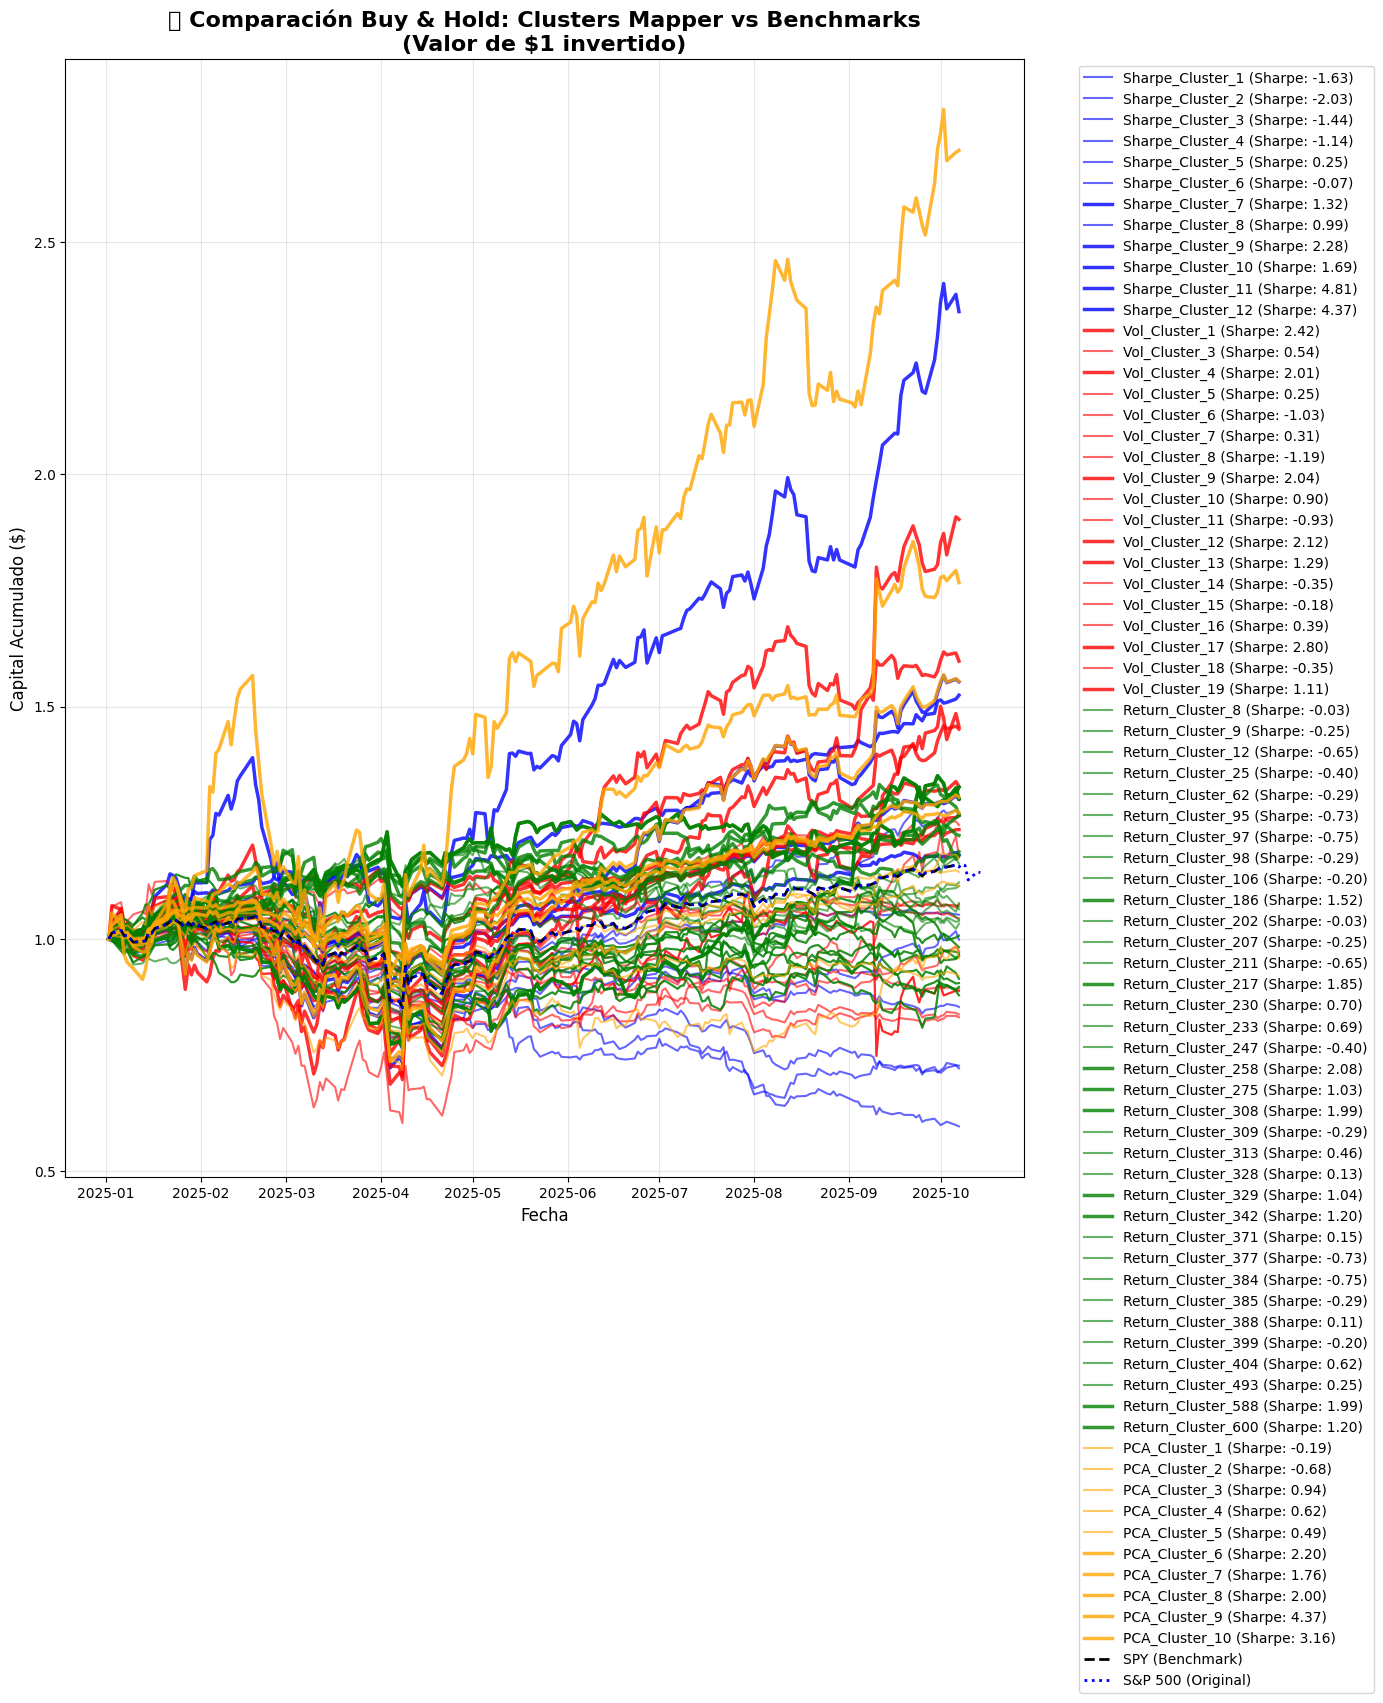


 RANKING DE CLUSTERS POR SHARPE RATIO:
--------------------------------------------------------------------------------
Rank Cluster              Tipo            Sharpe   Retorno    Valor Final 
--------------------------------------------------------------------------------
1    Sharpe_Cluster_11    Sharpe Ratio    4.81     52.434%    $1.524       
2    Sharpe_Cluster_12    Sharpe Ratio    4.37     134.976%   $2.350       
3    PCA_Cluster_9        PCA             4.37     169.670%   $2.697       
4    PCA_Cluster_10       PCA             3.16     76.661%    $1.767       
5    Vol_Cluster_17       Volatilidad     2.80     90.267%    $1.903       
6    Vol_Cluster_1        Volatilidad     2.42     26.621%    $1.266       
7    Sharpe_Cluster_9     Sharpe Ratio    2.28     30.086%    $1.301       
8    PCA_Cluster_6        PCA             2.20     30.511%    $1.305       
9    Vol_Cluster_12       Volatilidad     2.12     59.772%    $1.598       
10   Return_Cluster_258   Retorno Total

In [31]:

# Crear visualización comparativa
if cluster_analysis_results:
    cluster_ranking = create_cluster_comparison_plot(cluster_analysis_results)

In [32]:
# imprimir tickers de cluster especifico por nombre
specific_cluster_name = 'Sharpe_Cluster_11'  # Cambia esto al nombre del cluster que quieres ver
if specific_cluster_name in mapper_clusters:
    specific_cluster_info = mapper_clusters[specific_cluster_name]
    print(f"\n Tickers en {specific_cluster_name}:")
    print(", ".join(specific_cluster_info['tickers']))


 Tickers en Sharpe_Cluster_11:
AEP, APH, ATO, BK, CNP, COR, CVS, EVRG, GD, GE, GLW, HCA, HWM, JNJ, LHX, MO, RTX, TEL, WELL, WRB


### Visualizacion, no necesaria

Tickers en Sharpe_Cluster_11:
AEP, APH, ATO, BK, CNP, COR, CVS, EVRG, GD, GE, GLW, HCA, HWM, JNJ, KLAC, LHX, LRCX, MO, RTX, TEL, TPR, WELL, WRB

Sharpe_Cluster_11    Sharpe Ratio    4.72     56.701%    $1.567

In [33]:
mapper_clusters[specific_cluster_name]

{'tickers': ['AEP',
  'APH',
  'ATO',
  'BK',
  'CNP',
  'COR',
  'CVS',
  'EVRG',
  'GD',
  'GE',
  'GLW',
  'HCA',
  'HWM',
  'JNJ',
  'LHX',
  'MO',
  'RTX',
  'TEL',
  'WELL',
  'WRB'],
 'type': 'Sharpe Ratio',
 'node_name': 'cube5_cluster0',
 'size': 20}


 MEJOR CLUSTER IDENTIFICADO: Sharpe_Cluster_11
 Sharpe Ratio: 4.81
 Retorno Total: 52.4%
 ANÁLISIS DETALLADO: Sharpe_Cluster_11


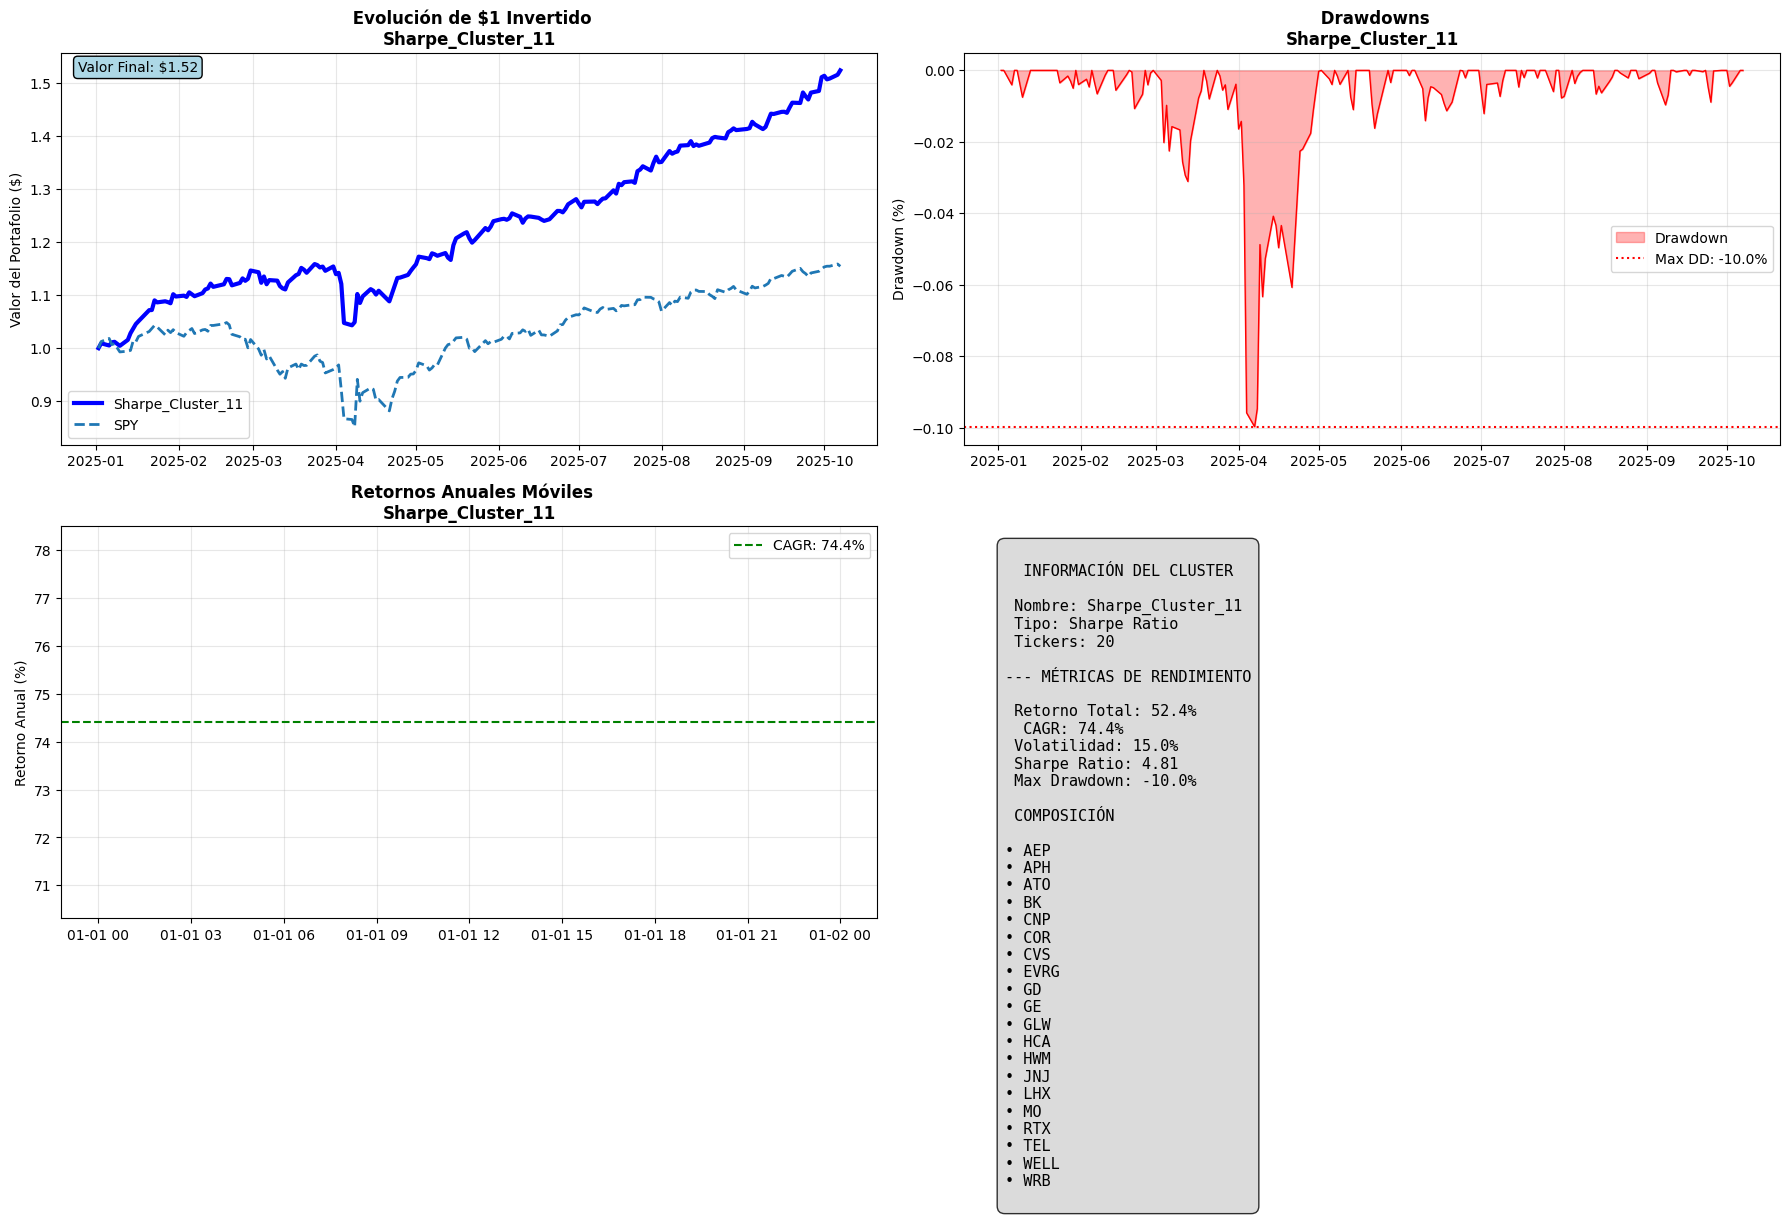


 COMPARACIÓN FINAL: MEJOR CLUSTER VS ÍNDICES PERSONALIZADOS

 MEJOR CLUSTER (Sharpe_Cluster_11):
    Valor Final: $1.52 (de $1 invertido)
    Retorno Total: 52.4%
     Sharpe Ratio: 4.81

 VS S&P 500:
    SPY Valor Final: $


TypeError: unsupported format string passed to Series.__format__

In [34]:
# =======================================================
# ANÁLISIS DETALLADO DEL MEJOR CLUSTER
# =======================================================

def create_detailed_cluster_analysis(best_cluster_name, cluster_data, benchmarks=['SPY']):
    """
    Crea análisis detallado del mejor cluster con múltiples visualizaciones
    """
    print(f" ANÁLISIS DETALLADO: {best_cluster_name}")
    print("=" * 60)
    
    cluster_curve = cluster_data['cluster_curve']
    cluster_metrics = cluster_data['cluster_metrics']
    cluster_info = cluster_data['cluster_info']
    
    # Configurar figura con múltiples subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))
    
    # 1. Evolución de capital (superior izquierda)
    ax1.plot(cluster_curve.index, cluster_curve.values, 
             label=f'{best_cluster_name}', color='blue', linewidth=3)
    
    # Añadir benchmarks sincronizados con fecha de inicio del cluster
    cluster_start_date = cluster_curve.index[0]
    for benchmark in benchmarks:
        if benchmark in tickers_data.columns:
            benchmark_data = tickers_data[benchmark].dropna()
            # Filtrar benchmark desde la fecha de inicio del cluster
            benchmark_filtered = benchmark_data[benchmark_data.index >= cluster_start_date]
            if len(benchmark_filtered) > 0:
                benchmark_normalized = (benchmark_filtered / benchmark_filtered.iloc[0]) * 1
                ax1.plot(benchmark_normalized.index, benchmark_normalized.values,
                        label=f'{benchmark}', linestyle='--', linewidth=2)
    
    ax1.set_title(f' Evolución de $1 Invertido\n{best_cluster_name}', fontweight='bold')
    ax1.set_ylabel('Valor del Portafolio ($)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Añadir texto con valor final
    ax1.text(0.02, 0.98, f'Valor Final: ${cluster_metrics["final_value"]:.2f}', 
             transform=ax1.transAxes, bbox=dict(boxstyle="round", facecolor='lightblue'),
             fontsize=10, verticalalignment='top')
    
    # 2. Drawdowns (superior derecha)
    rolling_max = cluster_curve.expanding().max()
    drawdown = (cluster_curve - rolling_max) / rolling_max
    
    ax2.fill_between(drawdown.index, drawdown.values, 0, 
                     alpha=0.3, color='red', label='Drawdown')
    ax2.plot(drawdown.index, drawdown.values, color='red', linewidth=1)
    ax2.set_title(f' Drawdowns\n{best_cluster_name}', fontweight='bold')
    ax2.set_ylabel('Drawdown (%)')
    ax2.axhline(y=cluster_metrics['max_drawdown'], color='red', linestyle=':', 
                label=f'Max DD: {cluster_metrics["max_drawdown"]:.1%}')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Retornos anuales móviles (inferior izquierda)
    returns_1y = cluster_curve.pct_change(252) * 100  # retornos anuales móviles
    
    ax3.plot(returns_1y.index, returns_1y.values, color='green', linewidth=2, alpha=0.7)
    ax3.axhline(y=cluster_metrics['cagr']*100, color='green', linestyle='--', 
                label=f'CAGR: {cluster_metrics["cagr"]:.1%}')
    ax3.set_title(f' Retornos Anuales Móviles\n{best_cluster_name}', fontweight='bold')
    ax3.set_ylabel('Retorno Anual (%)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Composición del cluster (inferior derecha)
    ax4.axis('off')
    
    # Información del cluster
    tickers = cluster_info['tickers']
    cluster_type = cluster_info['type']
    
    # Crear tabla de información
    info_text = f"""
  INFORMACIÓN DEL CLUSTER

 Nombre: {best_cluster_name}
 Tipo: {cluster_type}
 Tickers: {len(tickers)}
    
--- MÉTRICAS DE RENDIMIENTO
    
 Retorno Total: {cluster_metrics['total_return']:.1%}
  CAGR: {cluster_metrics['cagr']:.1%}
 Volatilidad: {cluster_metrics['volatility']:.1%}
 Sharpe Ratio: {cluster_metrics['sharpe']:.2f}
 Max Drawdown: {cluster_metrics['max_drawdown']:.1%}
    
 COMPOSICIÓN
    
{chr(10).join([f'• {ticker}' for ticker in tickers])}
    """
    
    ax4.text(0.05, 0.95, info_text, transform=ax4.transAxes, 
             fontsize=11, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle="round,pad=0.5", facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

# Encontrar y analizar el mejor cluster
if cluster_analysis_results:
    # Encontrar el cluster con mejor Sharpe ratio
    best_cluster = max(cluster_analysis_results.items(), 
                      key=lambda x: x[1]['cluster_metrics']['sharpe'])
    best_cluster_name = best_cluster[0]
    best_cluster_data = best_cluster[1]
    
    print(f"\n MEJOR CLUSTER IDENTIFICADO: {best_cluster_name}")
    print(f" Sharpe Ratio: {best_cluster_data['cluster_metrics']['sharpe']:.2f}")
    print(f" Retorno Total: {best_cluster_data['cluster_metrics']['total_return']:.1%}")
    
    # Crear análisis detallado
    create_detailed_cluster_analysis(best_cluster_name, best_cluster_data)
    
    # Comparación final con índices del análisis original
    print(f"\n" + "="*80)
    print(f" COMPARACIÓN FINAL: MEJOR CLUSTER VS ÍNDICES PERSONALIZADOS")
    print(f"="*80)
    
    cluster_final_value = best_cluster_data['cluster_metrics']['final_value']
    cluster_sharpe = best_cluster_data['cluster_metrics']['sharpe']
    cluster_return = best_cluster_data['cluster_metrics']['total_return']
    
    print(f"\n MEJOR CLUSTER ({best_cluster_name}):")
    print(f"    Valor Final: ${cluster_final_value:.2f} (de $1 invertido)")
    print(f"    Retorno Total: {cluster_return:.1%}")
    print(f"     Sharpe Ratio: {cluster_sharpe:.2f}")
    
    # Comparar con benchmarks si están disponibles
    if 'spy_curve' in globals():
        spy_final = (spy_curve.iloc[-1] / spy_curve.iloc[0]) * 1
        print(f"\n VS S&P 500:")
        print(f"    SPY Valor Final: $")
        
        print(f"    Ventaja del Cluster: ${cluster_final_value - spy_final:.2f}")
        print(f"    Outperformance: {(cluster_final_value/spy_final - 1):.1%}")
    
    print(f"\n CONCLUSIÓN:")
    print(f"   • El cluster {best_cluster_name} mostró el mejor rendimiento ajustado por riesgo")
    print(f"   • Basado en agrupación topológica por {best_cluster_data['cluster_info']['type']}")
    print(f"   • Compuesto por: {', '.join(best_cluster_data['cluster_info']['tickers'])}")
    print(f"   • Ideal para construcción de portafolios diversificados")

else:
    print("❌ No hay clusters analizados para mostrar")

print(f"\n" + "="*80)
print(f"📁 ARCHIVOS GENERADOS POR EL ANÁLISIS MAPPER:")
print(f"="*80)
print(f"🔸 visualizaciones_mapper_indice/mapper_principal_sharpe.html - Análisis principal por Sharpe Ratio")
print(f"🔸 visualizaciones_mapper_indice/mapper_interactivo_sharpe.html - Visualización interactiva por Sharpe")
print(f"🔸 visualizaciones_mapper_indice/mapper_interactivo_volatilidad.html - Visualización por volatilidad")
print(f"🔸 visualizaciones_mapper_indice/mapper_interactivo_retorno.html - Visualización por retorno")
print(f"🔸 visualizaciones_mapper_indice/mapper_config_volatilidad.html - Configuración por Volatilidad")
print(f"🔸 visualizaciones_mapper_indice/mapper_config_retorno_total.html - Configuración por Retorno Total")
print(f"🔸 visualizaciones_mapper_indice/mapper_config_pca_suma.html - Análisis PCA")
print(f"\n🌐 Para ver las visualizaciones interactivas:")
print(f"   1. Navega a la carpeta 'visualizaciones_mapper_indice/'")
print(f"   2. Abre cualquier archivo .html en tu navegador")
print(f"   3. Explora los clusters haciendo hover sobre los nodos")
print(f"   4. Los nombres de tickers aparecen en los tooltips de cada cluster")

# Saar sector de los mejores clusters

In [35]:
#tickers y categorías
# Obtener las categorías de los tickers usando yfinance
categories = {}
for ticker in tickers:
    try:
        info = yf.Ticker(ticker).info
        sector = info.get('sector', 'Unknown')
        if sector not in categories:
            categories[sector] = []
        categories[sector].append(ticker)
    except Exception as e:
        print(f"Error obteniendo sector para {ticker}: {e}")

print("Categorías encontradas:", {k: len(v) for k, v in categories.items()})

Categorías encontradas: {'Technology': 7, 'Healthcare': 8, 'Communication Services': 2, 'Consumer Cyclical': 4, 'Basic Materials': 2, 'Industrials': 2, 'Financial Services': 1, 'Consumer Defensive': 1, 'Energy': 1}


In [36]:
# ya que se tienen los sectores de cada ticker, añadimos una nueva columna a mapper_clusters con los sectores de cada ticker en cada cluster


# 🔬 Experimentación con Configuraciones de Mapper

Sistema de búsqueda automática para generar diferentes configuraciones y observar cómo cambian los clusters.

In [37]:
# =======================================================
# 🔬 EXPERIMENTACIÓN AUTOMÁTICA CON CONFIGURACIONES
# =======================================================

print("🔬 SISTEMA DE EXPERIMENTACIÓN AUTOMÁTICA - SOLO KEPLERMAPPER")
print("=" * 60)

# Definir configuraciones para experimentar con diferentes algoritmos de clustering
configurations = {
    'config_1': {
        'name': 'Conservador_KMeans',
        'n_intervals': 4,
        'overlap': 0.2,
        'clusterer': 'KMeans',
        'n_clusters': 2,
        'projection': [2],  # Sharpe Ratio
        'description': 'Pocos intervalos, poco overlap, K-Means - clusters más separados'
    },
    'config_2': {
        'name': 'Estándar_KMeans',
        'n_intervals': 6,
        'overlap': 0.5,
        'clusterer': 'KMeans',
        'n_clusters': 3,
        'projection': [2],  # Sharpe Ratio
        'description': 'Configuración balanceada estándar con K-Means'
    },
    'config_3': {
        'name': 'Agresivo_KMeans',
        'n_intervals': 10,
        'overlap': 0.7,
        'clusterer': 'KMeans',
        'n_clusters': 4,
        'projection': [2],  # Sharpe Ratio
        'description': 'Muchos intervalos, alto overlap, K-Means - clusters más granulares'
    },
    'config_4': {
        'name': 'Volatilidad_DBSCAN',
        'n_intervals': 6,
        'overlap': 0.4,
        'clusterer': 'DBSCAN',
        'eps': 0.3,
        'min_samples': 2,
        'projection': [1],  # Volatilidad
        'description': 'Enfoque en volatilidad con DBSCAN (detección automática de outliers)'
    },
    'config_5': {
        'name': 'Retorno_KMeans',
        'n_intervals': 8,
        'overlap': 0.3,
        'clusterer': 'KMeans',
        'n_clusters': 3,
        'projection': [0],  # Retorno Total
        'description': 'Enfoque en retorno total con K-Means'
    },
    'config_6': {
        'name': 'Multi_Metric_DBSCAN',
        'n_intervals': 6,
        'overlap': 0.5,
        'clusterer': 'DBSCAN',
        'eps': 0.4,
        'min_samples': 3,
        'projection': [0, 1, 2],  # Múltiples métricas
        'description': 'Combinación de retorno, volatilidad y Sharpe con DBSCAN'
    },
    'config_7': {
        'name': 'PCA_Sum_KMeans',
        'n_intervals': 5,
        'overlap': 0.6,
        'clusterer': 'KMeans',
        'n_clusters': 2,
        'projection': 'sum',  # Suma de todas las métricas
        'description': 'Proyección suma con K-Means - captura comportamiento general'
    },
    'config_8': {
        'name': 'Alto_Granular_DBSCAN',
        'n_intervals': 12,
        'overlap': 0.8,
        'clusterer': 'DBSCAN',
        'eps': 0.2,
        'min_samples': 1,
        'projection': [2],  # Sharpe Ratio
        'description': 'Máxima granularidad con DBSCAN - clusters pequeños y outliers'
    }
}

# Almacenar resultados de experimentos
experiment_results = {}

print(f"🧪 Ejecutando {len(configurations)} configuraciones experimentales con solo KeplerMapper...")
print(f"📊 Datos: {X_comparison.shape[0]} tickers, {X_comparison.shape[1]} métricas")

# Ejecutar cada configuración
for config_id, config in configurations.items():
    print(f"\n🔬 Experimento: {config['name']} ({config_id})")
    print(f"   📝 {config['description']}")
    print(f"   🤖 Algoritmo: {config['clusterer']}")
    
    try:
        # Determinar proyección (lens)
        if config['projection'] == 'sum':
            X_proj = km.lens.Sum().fit_transform(X_comparison)
        else:
            X_proj = X_comparison[:, config['projection']]
        
        # Configurar clusterer según el tipo especificado
        if config['clusterer'] == 'KMeans':
            clusterer = KMeans(n_clusters=config['n_clusters'], random_state=42)
            print(f"   ⚙️  K-Means con {config['n_clusters']} clusters")
        elif config['clusterer'] == 'DBSCAN':
            clusterer = DBSCAN(eps=config['eps'], min_samples=config['min_samples'])
            print(f"   ⚙️  DBSCAN con eps={config['eps']}, min_samples={config['min_samples']}")
        else:
            raise ValueError(f"Clusterer no soportado: {config['clusterer']}")
        
        # KeplerMapper con el clusterer especificado
        G_kepler_exp = km.map(
            X_proj,
            X_comparison,
            cover=km.Cover(n_cubes=config['n_intervals'], perc_overlap=config['overlap']),
            clusterer=clusterer
        )
        
        # Recopilar métricas
        kepler_nodes = len(G_kepler_exp['nodes'])
        kepler_edges = len(G_kepler_exp['links'])
        kepler_sizes = [len(indices) for indices in G_kepler_exp['nodes'].values()]
        
        # Calcular métricas de diversidad de clusters
        kepler_diversity = np.std(kepler_sizes) if kepler_sizes else 0
        
        # Detectar outliers (nodos con tamaño muy pequeño)
        median_size = np.median(kepler_sizes) if kepler_sizes else 0
        outlier_nodes = [size for size in kepler_sizes if size < median_size * 0.3]
        
        # Almacenar resultados
        experiment_results[config_id] = {
            'config': config,
            'kepler_mapper': {
                'nodes': kepler_nodes,
                'edges': kepler_edges,
                'sizes': kepler_sizes,
                'avg_size': np.mean(kepler_sizes) if kepler_sizes else 0,
                'diversity': kepler_diversity,
                'max_size': max(kepler_sizes) if kepler_sizes else 0,
                'min_size': min(kepler_sizes) if kepler_sizes else 0,
                'outliers': len(outlier_nodes),
                'median_size': median_size
            },
            'mapper_object': G_kepler_exp
        }
        
        print(f"   ✅ Resultado: {kepler_nodes} nodos, {kepler_edges} conexiones")
        print(f"   📈 Tamaños: avg={np.mean(kepler_sizes):.1f}, max={max(kepler_sizes) if kepler_sizes else 0}, min={min(kepler_sizes) if kepler_sizes else 0}")
        if outlier_nodes:
            print(f"   🎯 Outliers detectados: {len(outlier_nodes)} nodos pequeños")
        
    except Exception as e:
        print(f"   ❌ Error en {config['name']}: {str(e)}")
        experiment_results[config_id] = {'error': str(e), 'config': config}

print(f"\n🎯 Experimentación completada: {len(experiment_results)} configuraciones procesadas")

🔬 SISTEMA DE EXPERIMENTACIÓN AUTOMÁTICA - SOLO KEPLERMAPPER
🧪 Ejecutando 8 configuraciones experimentales con solo KeplerMapper...


NameError: name 'X_comparison' is not defined

In [38]:
# =======================================================
# 📊 ANÁLISIS COMPARATIVO DE EXPERIMENTOS - SOLO KEPLERMAPPER
# =======================================================

print("\n📊 ANÁLISIS COMPARATIVO DE CONFIGURACIONES KEPLERMAPPER")
print("=" * 60)

# Crear DataFrame con resultados para análisis fácil
results_data = []

for config_id, result in experiment_results.items():
    if 'error' not in result:
        config = result['config']
        kepler = result['kepler_mapper']
        
        row_data = {
            'Config_ID': config_id,
            'Name': config['name'],
            'Intervals': config['n_intervals'],
            'Overlap': config['overlap'],
            'Clusterer': config['clusterer'],
            'Projection': str(config['projection']),
            'Nodes': kepler['nodes'],
            'Edges': kepler['edges'],
            'Avg_Size': kepler['avg_size'],
            'Diversity': kepler['diversity'],
            'Max_Size': kepler['max_size'],
            'Min_Size': kepler['min_size'],
            'Outliers': kepler['outliers'],
            'Median_Size': kepler['median_size']
        }
        
        # Agregar parámetros específicos del clusterer
        if config['clusterer'] == 'KMeans':
            row_data['Clusters_Param'] = config['n_clusters']
            row_data['DBSCAN_eps'] = None
            row_data['DBSCAN_min_samples'] = None
        elif config['clusterer'] == 'DBSCAN':
            row_data['Clusters_Param'] = None
            row_data['DBSCAN_eps'] = config['eps']
            row_data['DBSCAN_min_samples'] = config['min_samples']
            
        results_data.append(row_data)
            'Node_Difference': abs(simple['nodes'] - kepler['nodes']),
            'Edge_Difference': abs(simple['edges'] - kepler['edges'])
        })

results_df = pd.DataFrame(results_data)

# Añadir columnas calculadas para análisis
if len(results_df) > 0:
    results_df['Conectividad'] = results_df['Edges'] / results_df['Nodes']  # Conexiones por nodo
    results_df['Efficiency'] = results_df['Nodes'] / (results_df['Intervals'] * results_df['Overlap'])  # Eficiencia de parametrización

# Mostrar resumen de resultados
print("\n🏆 RANKING POR NÚMERO DE CLUSTERS:")
if len(results_df) > 0:
    top_clusters = results_df.nlargest(5, 'Nodes')[['Name', 'Clusterer', 'Nodes', 'Edges', 'Outliers']]
    for _, row in top_clusters.iterrows():
        print(f"   {row['Name']} ({row['Clusterer']}): {row['Nodes']} nodos, {row['Edges']} conexiones, {row['Outliers']} outliers")

print("\n🎯 CONFIGURACIONES MÁS DIVERSAS (mayor variación en tamaños):")
if len(results_df) > 0:
    diverse_configs = results_df.nlargest(5, 'Diversity')[['Name', 'Clusterer', 'Diversity', 'Nodes']]
    for _, row in diverse_configs.iterrows():
        print(f"   {row['Name']} ({row['Clusterer']}): Diversidad {row['Diversity']:.2f}, {row['Nodes']} nodos")

print("\n🔍 CONFIGURACIONES CON MÁS OUTLIERS:")
if len(results_df) > 0:
    outlier_configs = results_df.nlargest(5, 'Outliers')[['Name', 'Clusterer', 'Outliers', 'Nodes']]
    for _, row in outlier_configs.iterrows():
        print(f"   {row['Name']} ({row['Clusterer']}): {row['Outliers']} outliers de {row['Nodes']} nodos")

print("\n⚡ CONFIGURACIONES MÁS EFICIENTES:")
if len(results_df) > 0:
    efficient_configs = results_df.nlargest(5, 'Efficiency')[['Name', 'Clusterer', 'Efficiency', 'Nodes']]
    for _, row in efficient_configs.iterrows():
        print(f"   {row['Name']} ({row['Clusterer']}): Eficiencia {row['Efficiency']:.2f}, {row['Nodes']} nodos")

# Comparar algoritmos de clustering
print("\n🤖 COMPARACIÓN ENTRE ALGORITMOS:")
if len(results_df) > 0:
    kmeans_configs = results_df[results_df['Clusterer'] == 'KMeans']
    dbscan_configs = results_df[results_df['Clusterer'] == 'DBSCAN']
    
    if len(kmeans_configs) > 0:
        print(f"   K-Means (promedio): {kmeans_configs['Nodes'].mean():.1f} nodos, {kmeans_configs['Diversity'].mean():.2f} diversidad")
    if len(dbscan_configs) > 0:
        print(f"   DBSCAN (promedio): {dbscan_configs['Nodes'].mean():.1f} nodos, {dbscan_configs['Diversity'].mean():.2f} diversidad")
        print(f"   DBSCAN outliers promedio: {dbscan_configs['Outliers'].mean():.1f}")

# Mostrar tabla completa
print(f"\n📋 TABLA COMPLETA DE RESULTADOS:")
if len(results_df) > 0:
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    display_cols = ['Name', 'Clusterer', 'Intervals', 'Overlap', 'Projection', 'Nodes', 'Edges', 'Diversity', 'Outliers']
    print(results_df[display_cols].to_string(index=False))

IndentationError: unexpected indent (508678559.py, line 44)

In [ ]:
# =======================================================
# 🎨 VISUALIZACIÓN MASIVA DE EXPERIMENTOS
# =======================================================

print("\n🎨 CREANDO VISUALIZACIONES DE EXPERIMENTOS")
print("=" * 50)

# Crear visualización de matriz de configuraciones
fig, axes = plt.subplots(2, 4, figsize=(24, 12))
axes = axes.flatten()

configs_to_plot = list(experiment_results.keys())[:8]  # Primeras 8 configuraciones

for idx, config_id in enumerate(configs_to_plot):
    ax = axes[idx]
    
    if 'error' in experiment_results[config_id]:
        # Mostrar error
        ax.text(0.5, 0.5, f"Error:\n{experiment_results[config_id]['config']['name']}", 
                ha='center', va='center', transform=ax.transAxes,
                bbox=dict(boxstyle="round,pad=0.3", facecolor='lightcoral'))
        ax.set_title(f"❌ {experiment_results[config_id]['config']['name']}")
    else:
        result = experiment_results[config_id]
        config = result['config']
        
        # Datos para el gráfico
        methods = ['SimpleMapper', 'KeplerMapper']
        nodes_count = [result['simple_mapper']['nodes'], result['kepler_mapper']['nodes']]
        edges_count = [result['simple_mapper']['edges'], result['kepler_mapper']['edges']]
        
        # Gráfico de barras doble
        x_pos = np.arange(len(methods))
        width = 0.35
        
        bars1 = ax.bar(x_pos - width/2, nodes_count, width, label='Nodos', alpha=0.8, color='skyblue')
        bars2 = ax.bar(x_pos + width/2, edges_count, width, label='Conexiones', alpha=0.8, color='lightcoral')
        
        # Etiquetas en las barras
        for bar in bars1:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                   f'{int(height)}', ha='center', va='bottom', fontsize=9)
        
        for bar in bars2:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                   f'{int(height)}', ha='center', va='bottom', fontsize=9)
        
        ax.set_xlabel('Método')
        ax.set_ylabel('Cantidad')
        ax.set_title(f"{config['name']}\n{config['n_intervals']}int, {config['overlap']}ovlp")
        ax.set_xticks(x_pos)
        ax.set_xticklabels(methods, rotation=45)
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
        
        # Información adicional en texto pequeño
        projection_str = str(config['projection']).replace('[', '').replace(']', '').replace(' ', '')
        ax.text(0.02, 0.98, f"Proj: {projection_str}\nClusters: {config['n_clusters']}", 
                transform=ax.transAxes, verticalalignment='top', fontsize=8,
                bbox=dict(boxstyle="round,pad=0.2", facecolor='lightyellow', alpha=0.8))

plt.tight_layout()
plt.suptitle('🔬 Experimentos con Diferentes Configuraciones de Mapper', 
             fontsize=16, fontweight='bold', y=1.02)
plt.show()

print("✅ Visualización de experimentos completada")

In [39]:
# =======================================================
# 🔍 EXPLORACIÓN DETALLADA DE CONFIGURACIÓN ESPECÍFICA
# =======================================================

print("\n🔍 EXPLORACIÓN DETALLADA")
print("=" * 40)

# Permitir al usuario elegir una configuración para análisis detallado
print("🎯 Configuraciones disponibles para análisis detallado:")
for config_id, result in experiment_results.items():
    if 'error' not in result:
        config = result['config']
        simple_nodes = result['simple_mapper']['nodes']
        kepler_nodes = result['kepler_mapper']['nodes']
        print(f"   {config_id}: {config['name']} (S:{simple_nodes}, K:{kepler_nodes})")

# Función para análisis detallado de una configuración específica
def analyze_configuration_detailed(config_id):
    """Análisis detallado de una configuración específica"""
    
    if config_id not in experiment_results or 'error' in experiment_results[config_id]:
        print(f"❌ Configuración {config_id} no válida o con error")
        return
    
    result = experiment_results[config_id]
    config = result['config']
    simple_mapper_obj = result['mappers']['simple_obj']
    kepler_mapper_obj = result['mappers']['kepler_obj']
    
    print(f"\n🔬 ANÁLISIS DETALLADO: {config['name']}")
    print("=" * 50)
    print(f"📝 Descripción: {config['description']}")
    print(f"⚙️ Parámetros:")
    print(f"   • Intervalos: {config['n_intervals']}")
    print(f"   • Overlap: {config['overlap']}")
    print(f"   • Clusters K-Means: {config['n_clusters']}")
    print(f"   • Proyección: {config['projection']}")
    
    # Análisis de clusters específicos
    print(f"\n📊 CLUSTERS GENERADOS:")
    
    print(f"\n🔧 SimpleMapper:")
    for node_id, node in simple_mapper_obj.nodes.items():
        tickers_in_node = [ticker_names[i] for i in node['points']]
        node_metrics = metrics_df.iloc[node['points']]
        
        print(f"   Nodo {node_id}:")
        print(f"      👥 Tamaño: {node['size']} tickers")
        print(f"      🏢 Tickers: {', '.join(tickers_in_node[:5])}{'...' if len(tickers_in_node) > 5 else ''}")
        print(f"      📈 Sharpe promedio: {node_metrics['sharpe_ratio'].mean():.3f}")
        print(f"      💰 Retorno promedio: {node_metrics['total_return'].mean():.2%}")
        print(f"      📊 Volatilidad promedio: {node_metrics['volatility'].mean():.2%}")
    
    print(f"\n⚙️ KeplerMapper:")
    for node_name, indices in kepler_mapper_obj['nodes'].items():
        tickers_in_node = [ticker_names[i] for i in indices]
        node_metrics = metrics_df.iloc[indices]
        
        print(f"   {node_name}:")
        print(f"      👥 Tamaño: {len(indices)} tickers")
        print(f"      🏢 Tickers: {', '.join(tickers_in_node[:5])}{'...' if len(tickers_in_node) > 5 else ''}")
        print(f"      📈 Sharpe promedio: {node_metrics['sharpe_ratio'].mean():.3f}")
        print(f"      💰 Retorno promedio: {node_metrics['total_return'].mean():.2%}")
        print(f"      📊 Volatilidad promedio: {node_metrics['volatility'].mean():.2%}")
    
    # Análisis de overlap entre clusters
    print(f"\n🔗 ANÁLISIS DE OVERLAP:")
    simple_all_tickers = set()
    for node in simple_mapper_obj.nodes.values():
        simple_all_tickers.update(node['points'])
    
    kepler_all_tickers = set()
    for indices in kepler_mapper_obj['nodes'].values():
        kepler_all_tickers.update(indices)
    
    common_tickers = simple_all_tickers & kepler_all_tickers
    print(f"   📊 Tickers en ambos métodos: {len(common_tickers)} de {len(ticker_names)} total")
    print(f"   📈 Cobertura SimpleMapper: {len(simple_all_tickers)} tickers ({len(simple_all_tickers)/len(ticker_names)*100:.1f}%)")
    print(f"   ⚙️ Cobertura KeplerMapper: {len(kepler_all_tickers)} tickers ({len(kepler_all_tickers)/len(ticker_names)*100:.1f}%)")
    
    return simple_mapper_obj, kepler_mapper_obj

# Análisis automático de las configuraciones más interesantes
print(f"\n🎯 ANÁLISIS AUTOMÁTICO DE CONFIGURACIONES DESTACADAS:")

# Configuración con más clusters
max_clusters_config = max(
    [k for k in experiment_results.keys() if 'error' not in experiment_results[k]], 
    key=lambda x: experiment_results[x]['simple_mapper']['nodes']
)
print(f"\n🏆 Configuración con más clusters (SimpleMapper): {experiment_results[max_clusters_config]['config']['name']}")
analyze_configuration_detailed(max_clusters_config)

print("\n" + "="*80)

# Configuración más diversa
most_diverse_config = max(
    [k for k in experiment_results.keys() if 'error' not in experiment_results[k]], 
    key=lambda x: experiment_results[x]['simple_mapper']['diversity']
)
print(f"\n🎨 Configuración más diversa: {experiment_results[most_diverse_config]['config']['name']}")
analyze_configuration_detailed(most_diverse_config)


🔍 EXPLORACIÓN DETALLADA
🎯 Configuraciones disponibles para análisis detallado:

🎯 ANÁLISIS AUTOMÁTICO DE CONFIGURACIONES DESTACADAS:


ValueError: max() iterable argument is empty

In [ ]:
# =======================================================
# 🎲 GENERADOR DE CONFIGURACIONES ALEATORIAS
# =======================================================

print("\n🎲 GENERADOR DE CONFIGURACIONES ALEATORIAS")
print("=" * 50)

import random

def generate_random_configurations(n_configs=5):
    """Genera configuraciones aleatorias para experimentación"""
    
    random_configs = {}
    
    for i in range(n_configs):
        # Parámetros aleatorios dentro de rangos razonables
        n_intervals = random.randint(3, 15)
        overlap = round(random.uniform(0.1, 0.9), 2)
        n_clusters = random.randint(2, 6)
        
        # Proyecciones aleatorias
        projection_types = [
            [0],           # Solo retorno
            [1],           # Solo volatilidad
            [2],           # Solo Sharpe
            [0, 1],        # Retorno + volatilidad
            [1, 2],        # Volatilidad + Sharpe
            [0, 2],        # Retorno + Sharpe
            [0, 1, 2],     # Todas las métricas
            'sum'          # Suma de todas
        ]
        projection = random.choice(projection_types)
        
        config_id = f'random_{i+1}'
        random_configs[config_id] = {
            'name': f'Random_{i+1}',
            'n_intervals': n_intervals,
            'overlap': overlap,
            'n_clusters': n_clusters,
            'projection': projection,
            'description': f'Config aleatoria: {n_intervals}int, {overlap}ovlp, proj={projection}'
        }
    
    return random_configs

# Generar configuraciones aleatorias
random_configs = generate_random_configurations(5)

print("🎲 Configuraciones aleatorias generadas:")
for config_id, config in random_configs.items():
    print(f"   {config_id}: {config['description']}")

# Ejecutar configuraciones aleatorias
print(f"\n🧪 Ejecutando configuraciones aleatorias...")

random_results = {}

for config_id, config in random_configs.items():
    print(f"\n🎲 Probando: {config['name']}")
    
    try:
        # SimpleMapper
        simple_random = SimpleMapper(
            n_intervals=config['n_intervals'], 
            overlap=config['overlap']
        )
        simple_random.fit_transform(X_comparison, projection=config['projection'])
        
        # KeplerMapper
        kepler_random = km.KeplerMapper(verbose=0)
        kepler_projected_random = kepler_random.fit_transform(X_comparison, projection=config['projection'])
        
        covering_random = km.Cover(
            n_cubes=config['n_intervals'], 
            perc_overlap=config['overlap']
        )
        G_kepler_random = kepler_random.map(
            kepler_projected_random, X_comparison,
            clusterer=sklearn.cluster.KMeans(n_clusters=config['n_clusters']),
            cover=covering_random
        )
        
        # Métricas
        simple_nodes = len(simple_random.nodes)
        kepler_nodes = len(G_kepler_random['nodes'])
        
        random_results[config_id] = {
            'config': config,
            'simple_nodes': simple_nodes,
            'kepler_nodes': kepler_nodes,
            'simple_edges': len(simple_random.edges),
            'kepler_edges': len(G_kepler_random['links']),
            'success': True
        }
        
        print(f"   ✅ S:{simple_nodes} nodos, K:{kepler_nodes} nodos")
        
    except Exception as e:
        random_results[config_id] = {
            'config': config,
            'error': str(e),
            'success': False
        }
        print(f"   ❌ Error: {str(e)}")

# Resumen de configuraciones aleatorias
print(f"\n📊 RESUMEN DE CONFIGURACIONES ALEATORIAS:")
successful_randoms = {k: v for k, v in random_results.items() if v['success']}

if successful_randoms:
    print(f"✅ Exitosas: {len(successful_randoms)}/{len(random_configs)}")
    
    # Mejor configuración aleatoria (más clusters en SimpleMapper)
    best_random = max(successful_randoms.items(), key=lambda x: x[1]['simple_nodes'])
    print(f"🏆 Mejor aleatoria: {best_random[1]['config']['name']}")
    print(f"   📊 {best_random[1]['simple_nodes']} nodos SimpleMapper")
    print(f"   ⚙️ {best_random[1]['kepler_nodes']} nodos KeplerMapper")
    print(f"   🔧 Configuración: {best_random[1]['config']['description']}")
    
    # Configuración más extrema
    most_extreme = max(successful_randoms.items(), 
                      key=lambda x: abs(x[1]['simple_nodes'] - x[1]['kepler_nodes']))
    print(f"\n🎯 Más diferencia entre métodos: {most_extreme[1]['config']['name']}")
    print(f"   📊 Diferencia: {abs(most_extreme[1]['simple_nodes'] - most_extreme[1]['kepler_nodes'])} nodos")
else:
    print("❌ Ninguna configuración aleatoria fue exitosa")

print(f"\n💡 SUGERENCIAS PARA EXPERIMENTACIÓN:")
print(f"   🔬 Prueba configuraciones con overlap > 0.7 para mayor granularidad")
print(f"   📊 Usa proyecciones múltiples [0,1,2] para capturar más relaciones")
print(f"   🎯 Intervalos entre 8-12 tienden a generar más clusters")
print(f"   ⚖️ Overlap entre 0.3-0.6 balancea granularidad y estabilidad")

## 🔬 Análisis de Clusters vs Información Fundamental

Análisis detallado de cómo los clusters topológicos se relacionan con características fundamentales de los tickers.

In [40]:
# =======================================================
# 🎯 ASIGNACIÓN DE TICKERS A CLUSTERS MAPPER
# =======================================================

print("🎯 Asignando tickers a clusters basados en el grafo KeplerMapper...")
print("=" * 80)

# Crear diccionario de ticker -> cluster(s)
ticker_to_clusters = {}
cluster_to_tickers = {}

# Analizar el grafo G (KeplerMapper)
for node_id, node_data in G['nodes'].items():
    node_indices = node_data
    tickers_in_node = [ticker_names[i] for i in node_indices]
    
    cluster_to_tickers[node_id] = tickers_in_node
    
    for ticker in tickers_in_node:
        if ticker not in ticker_to_clusters:
            ticker_to_clusters[ticker] = []
        ticker_to_clusters[ticker].append(node_id)

# Asignar cluster "principal" (el primero donde aparece)
ticker_main_cluster = {ticker: clusters[0] for ticker, clusters in ticker_to_clusters.items()}

print(f"✅ {len(ticker_to_clusters)} tickers asignados a clusters")
print(f"📊 Total de clusters: {len(cluster_to_tickers)}")
print(f"📈 Distribución de tickers por número de clusters:")

cluster_membership_counts = pd.Series([len(clusters) for clusters in ticker_to_clusters.values()]).value_counts().sort_index()
for n_clusters, count in cluster_membership_counts.items():
    print(f"   {n_clusters} cluster(s): {count} tickers")

# Crear DataFrame combinado
print("\n🔗 Creando DataFrame combinado: Clusters + Información Fundamental...")

combined_df = ticker_info_df.copy()
combined_df['main_cluster'] = combined_df.index.map(ticker_main_cluster)
combined_df['n_clusters'] = combined_df.index.map(lambda x: len(ticker_to_clusters.get(x, [])))

# Filtrar solo tickers con cluster asignado y que existen en nuestra base de datos
combined_df_clean = combined_df[combined_df['main_cluster'].notna()].copy()

print(f"✅ DataFrame combinado creado: {combined_df_clean.shape}")
print(f"   Tickers con cluster e información: {len(combined_df_clean)}")

# Guardar
combined_df_clean.to_csv('sp500_tickers_with_clusters.csv')
print("💾 Guardado en 'sp500_tickers_with_clusters.csv'")

# Mostrar muestra
print("\n📄 Muestra del DataFrame combinado:")
display(combined_df_clean[['sector', 'industry', 'market_cap', 'beta', 'main_cluster', 'n_clusters']].head(10))

🎯 Asignando tickers a clusters basados en el grafo KeplerMapper...
✅ 503 tickers asignados a clusters
📊 Total de clusters: 12
📈 Distribución de tickers por número de clusters:
   1 cluster(s): 3 tickers
   2 cluster(s): 500 tickers

🔗 Creando DataFrame combinado: Clusters + Información Fundamental...
✅ DataFrame combinado creado: (503, 44)
   Tickers con cluster e información: 503
💾 Guardado en 'sp500_tickers_with_clusters.csv'

📄 Muestra del DataFrame combinado:


sector                        industry     market_cap  \
NVDA               Technology                  Semiconductors  4383190548480   
MSFT               Technology       Software - Infrastructure  3821019332608   
AAPL               Technology            Consumer Electronics  3677003448320   
AMZN        Consumer Cyclical                 Internet Retail  2347027136512   
META   Communication Services  Internet Content & Information  1797939789824   
AVGO               Technology                  Semiconductors  1684467613696   
GOOGL  Communication Services  Internet Content & Information  2955410931712   
GOOG   Communication Services  Internet Content & Information  2955410931712   
TSLA        Consumer Cyclical              Auto Manufacturers  1449433235456   
BRK-B      Financial Services         Insurance - Diversified  1070096515072   

        beta    main_cluster  n_clusters  
NVDA   2.123  cube3_cluster1           2  
MSFT   1.023  cube3_cluster0           2  
AAPL   1.094  cube2_cluster0           2  
AMZN   1.281  cube2_cluster0           2  
META   1.203  cube2_cluster0           2  
AVGO   1.208  cube3_cluster1           2  
GOOGL  1.000  cube3_cluster0           2  
GOOG   1.000  cube3_cluster0           2  
TSLA   2.086  cube2_cluster1           2  
BRK-B  0.770  cube2_cluster0           2

In [45]:
# =======================================================
# 📊 ANÁLISIS ESTADÍSTICO POR CLUSTER MAPPER
# =======================================================

print("📊 Análisis estadístico detallado de características por cluster...")
print("=" * 80)

# Analizar cada cluster
cluster_profiles = {}

for cluster_id in sorted(cluster_to_tickers.keys()):
    tickers_in_cluster = cluster_to_tickers[cluster_id]
    
    # Filtrar tickers que existen en combined_df_clean
    valid_tickers = [t for t in tickers_in_cluster if t in combined_df_clean.index]
    
    if len(valid_tickers) == 0:
        continue
    
    cluster_data = combined_df_clean.loc[valid_tickers]
    
    print(f"\n{'='*80}")
    print(f"🎯 CLUSTER: {cluster_id}")
    print(f"{'='*80}")
    print(f"📊 Número de tickers: {len(valid_tickers)}")
    print(f"🏢 Tickers: {', '.join(valid_tickers[:10])}{'...' if len(valid_tickers) > 10 else ''}")
    
    # Análisis de sectores
    print(f"\n🏢 DISTRIBUCIÓN POR SECTOR:")
    top_sectors = cluster_data['sector'].value_counts().head(5)
    for sector, count in top_sectors.items():
        pct = (count / len(cluster_data)) * 100
        print(f"   • {sector:30s}: {count:2d} ({pct:5.1f}%)")
    
    # Análisis de industrias
    print(f"\n🏭 TOP 3 INDUSTRIAS:")
    top_industries = cluster_data['industry'].value_counts().head(3)
    for industry, count in top_industries.items():
        pct = (count / len(cluster_data)) * 100
        print(f"   • {industry:40s}: {count:2d} ({pct:5.1f}%)")
    
    # Métricas financieras clave
    print(f"\n💰 MÉTRICAS FINANCIERAS (Mediana):")
    
    metrics = {
        'Market Cap (B$)': cluster_data['market_cap'].median() / 1e9,
        'P/E Ratio': cluster_data['pe_ratio'].median(),
        'Beta (Riesgo)': cluster_data['beta'].median(),
        'ROE (%)': cluster_data['roe'].median() * 100 if cluster_data['roe'].notna().any() else None,
        'Profit Margin (%)': cluster_data['profit_margins'].median() * 100 if cluster_data['profit_margins'].notna().any() else None,
        'Debt/Equity': cluster_data['debt_to_equity'].median(),
        'Dividend Yield (%)': cluster_data['dividend_yield'].median() * 100 if cluster_data['dividend_yield'].notna().any() else None,
        'Revenue Growth (%)': cluster_data['revenue_growth'].median() * 100 if cluster_data['revenue_growth'].notna().any() else None,
    }
    
    for metric, value in metrics.items():
        if value is not None and not np.isnan(value):
            print(f"   • {metric:25s}: {value:8.2f}")
        else:
            print(f"   • {metric:25s}: N/A")
    
    # Recomendación de analistas
    print(f"\n💼 RECOMENDACIÓN DOMINANTE DE ANALISTAS:")
    if cluster_data['recommendation'].notna().any():
        top_rec = cluster_data['recommendation'].value_counts().head(3)
        for rec, count in top_rec.items():
            pct = (count / len(cluster_data)) * 100
            print(f"   • {rec:15s}: {count:2d} ({pct:5.1f}%)")
    
    # Guardar perfil del cluster
    cluster_profiles[cluster_id] = {
        'size': len(valid_tickers),
        'tickers': valid_tickers,
        'dominant_sector': top_sectors.index[0] if len(top_sectors) > 0 else 'Unknown',
        'dominant_industry': top_industries.index[0] if len(top_industries) > 0 else 'Unknown',
        'median_market_cap': cluster_data['market_cap'].median(),
        'median_beta': cluster_data['beta'].median(),
        'median_pe': cluster_data['pe_ratio'].median(),
        'median_roe': cluster_data['roe'].median(),
        'median_profit_margin': cluster_data['profit_margins'].median(),
    }

print(f"\n{'='*80}")
print("✅ Análisis estadístico por cluster completado")

📊 Análisis estadístico detallado de características por cluster...

🎯 CLUSTER: cube0_cluster0
📊 Número de tickers: 13
🏢 Tickers: ACN, CAG, CLX, CMG, CPB, CPRT, CRM, DOW, EPAM, FDS...

🏢 DISTRIBUCIÓN POR SECTOR:
   • Consumer Defensive            :  4 ( 30.8%)
   • Technology                    :  3 ( 23.1%)
   • Basic Materials               :  2 ( 15.4%)
   • Consumer Cyclical             :  1 (  7.7%)
   • Industrials                   :  1 (  7.7%)

🏭 TOP 3 INDUSTRIAS:
   • Information Technology Services         :  2 ( 15.4%)
   • Packaged Foods                          :  2 ( 15.4%)
   • Household & Personal Products           :  1 (  7.7%)

💰 MÉTRICAS FINANCIERAS (Mediana):
   • Market Cap (B$)          :    15.81
   • P/E Ratio                :    18.44
   • Beta (Riesgo)            :     1.00
   • ROE (%)                  :    16.77
   • Profit Margin (%)        :    11.02
   • Debt/Equity              :    92.87
   • Dividend Yield (%)       :   467.00
   • Revenue Growth (%) 

🎨 Creando visualizaciones de clusters vs características fundamentales...

1️⃣ Heatmap: Distribución de Sectores por Cluster...


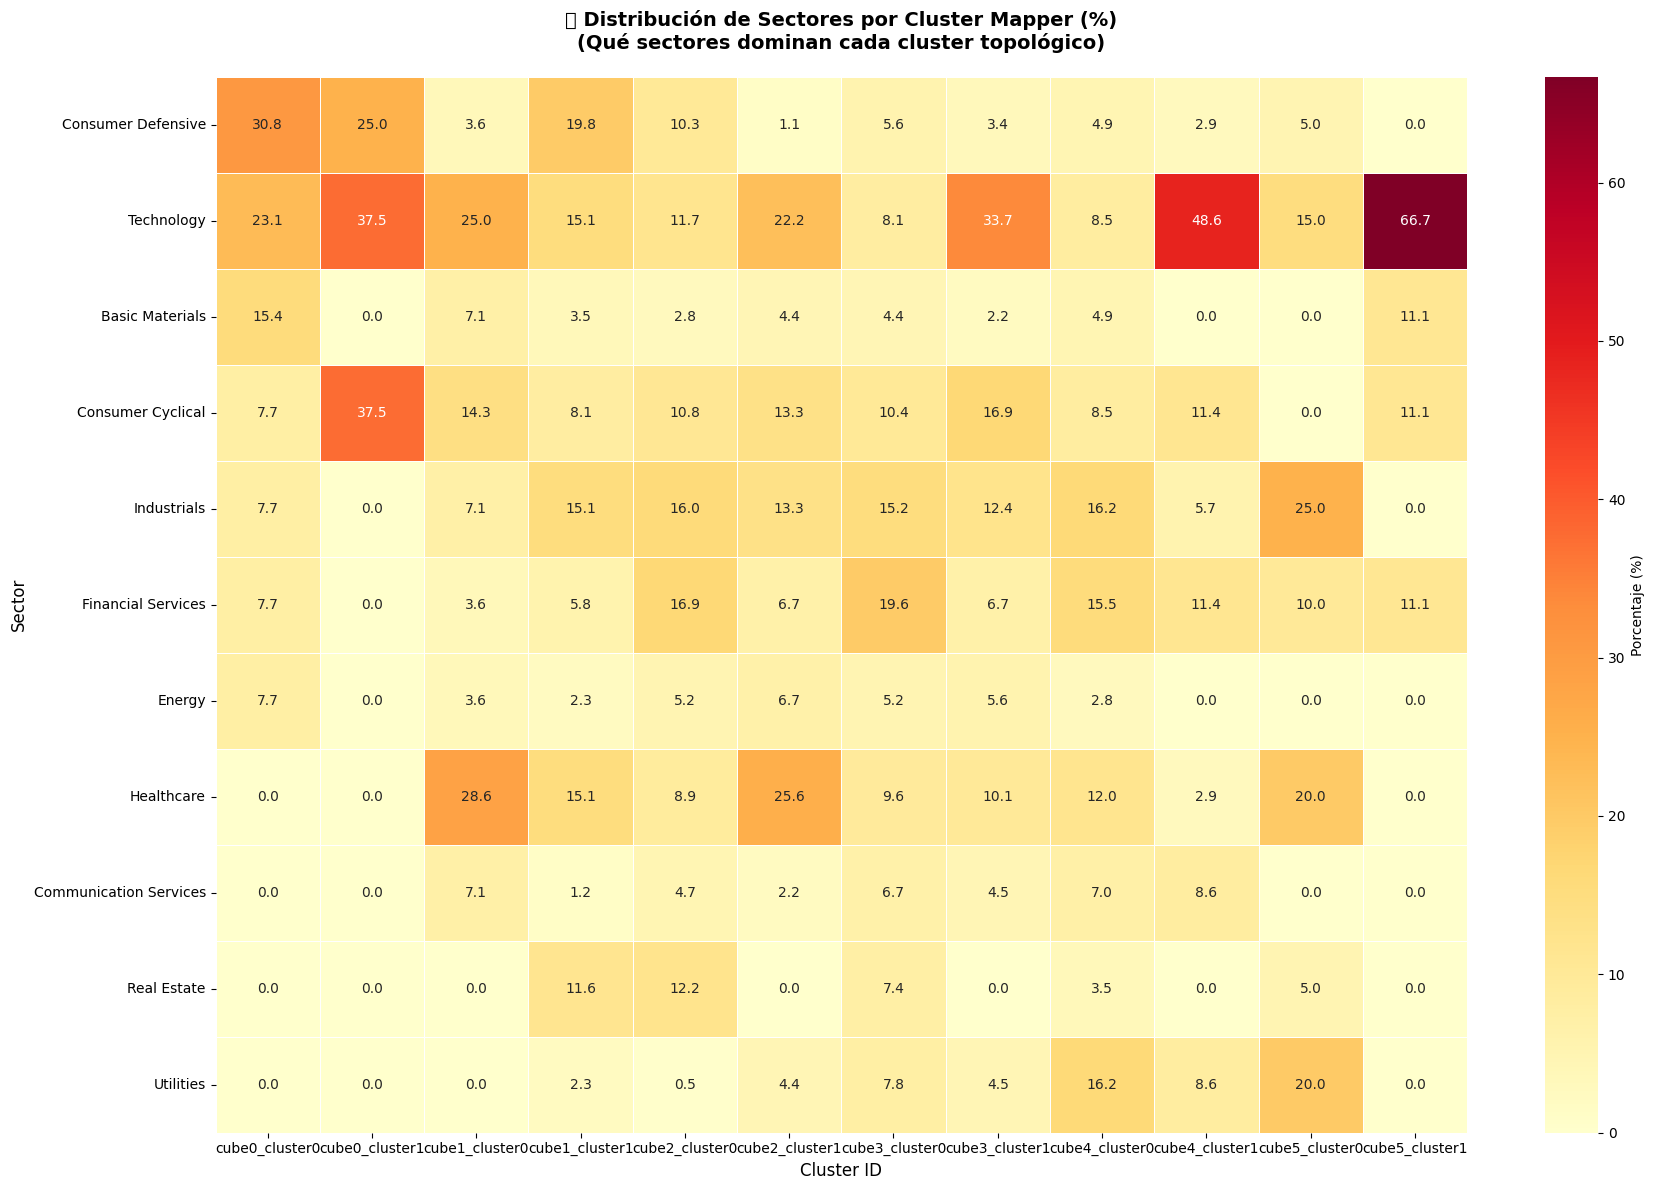

✅ Heatmap creado

2️⃣ Comparación de Métricas Financieras por Cluster...


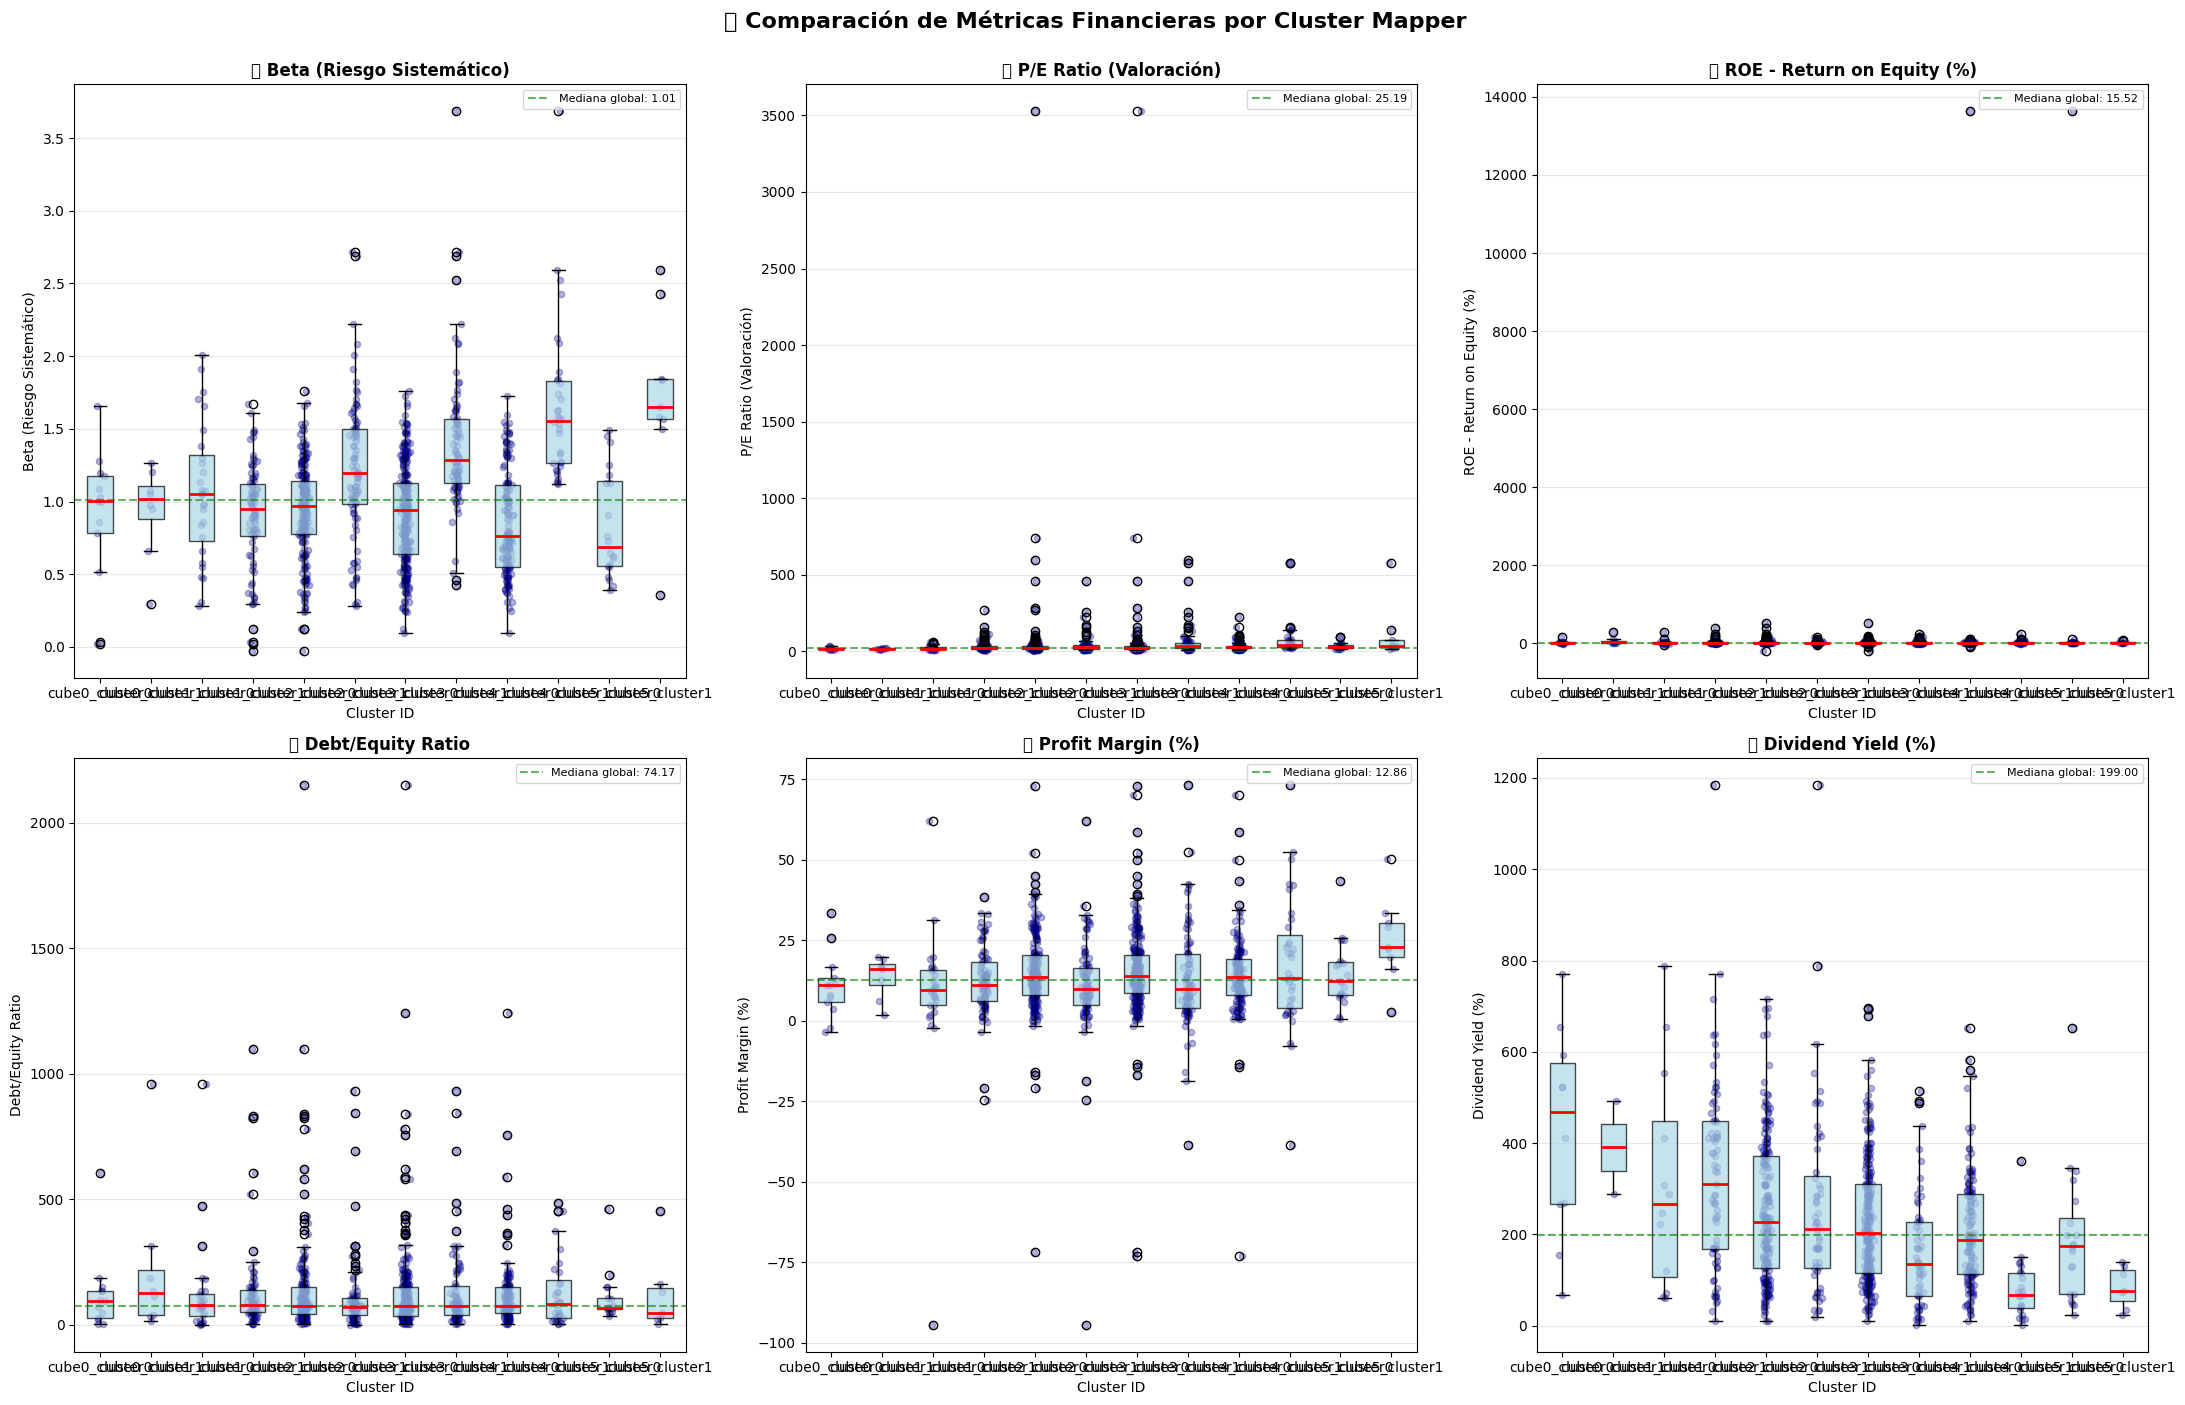

✅ Comparación de métricas creada

3️⃣ Distribución de Market Cap por Cluster...


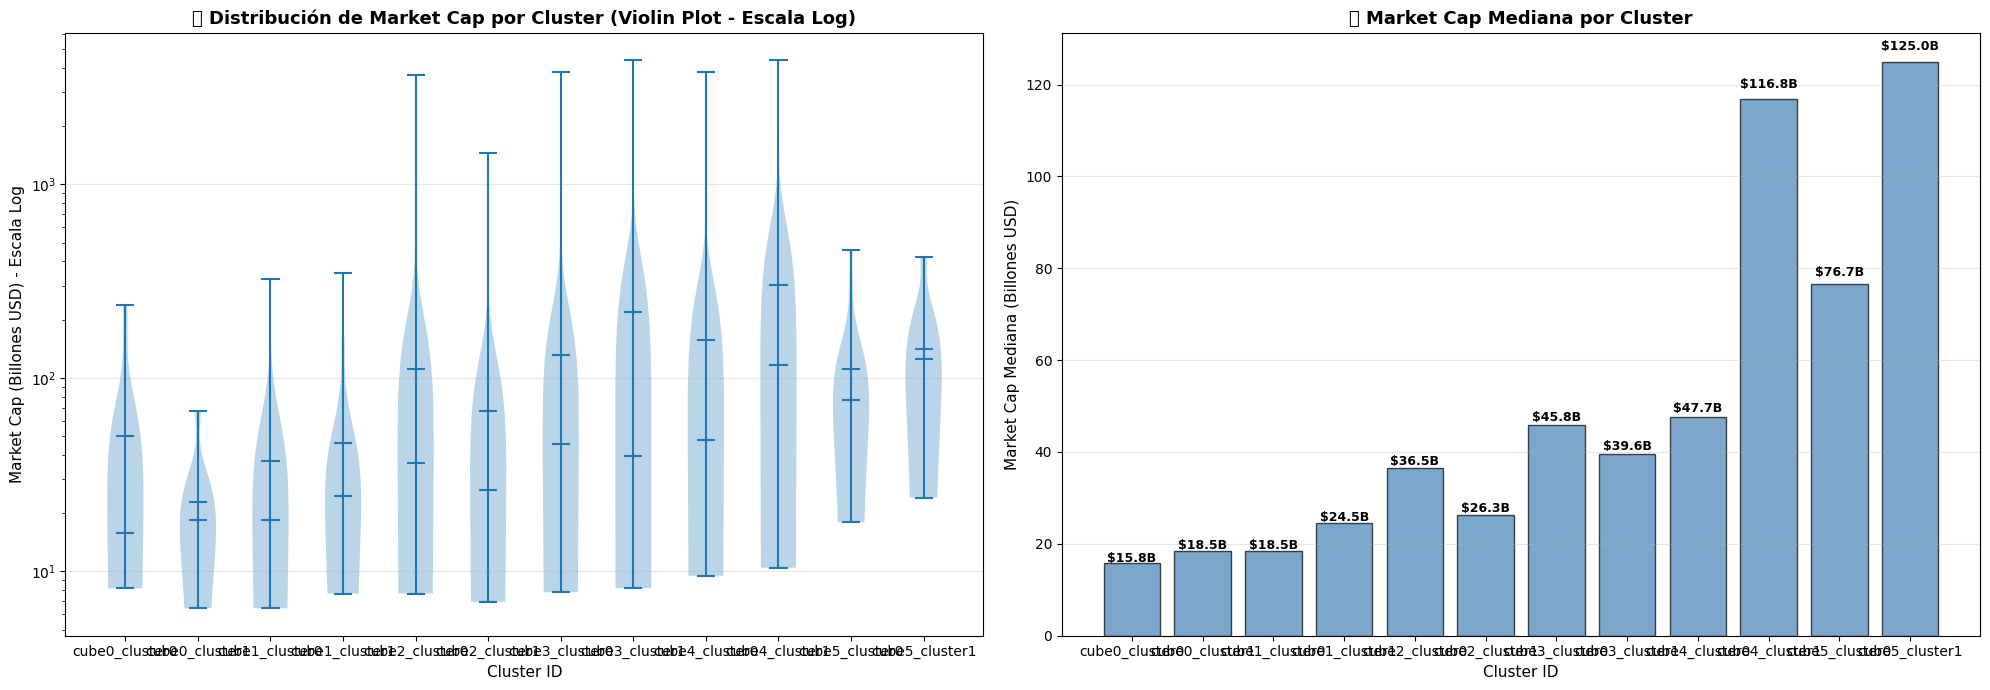

✅ Visualizaciones de Market Cap creadas

✅ Todas las visualizaciones completadas exitosamente!


In [46]:
# =======================================================
# 🎨 VISUALIZACIONES: CLUSTERS VS CARACTERÍSTICAS FUNDAMENTALES
# =======================================================

print("🎨 Creando visualizaciones de clusters vs características fundamentales...")
print("=" * 80)

# 1. HEATMAP: Distribución de Sectores por Cluster
print("\n1️⃣ Heatmap: Distribución de Sectores por Cluster...")

fig, ax = plt.subplots(figsize=(18, 12))

# Crear matriz de sectores vs clusters
sector_cluster_data = []
for cluster_id, profile in cluster_profiles.items():
    valid_tickers = profile['tickers']
    cluster_data = combined_df_clean.loc[valid_tickers]
    sector_dist = cluster_data['sector'].value_counts()
    sector_cluster_data.append({
        'cluster': str(cluster_id),
        **sector_dist.to_dict()
    })

sector_cluster_df = pd.DataFrame(sector_cluster_data).fillna(0)
sector_cluster_df = sector_cluster_df.set_index('cluster')

# Normalizar por cluster (porcentaje)
sector_cluster_pct = sector_cluster_df.div(sector_cluster_df.sum(axis=1), axis=0) * 100

# Crear heatmap
sns.heatmap(sector_cluster_pct.T, annot=True, fmt='.1f', cmap='YlOrRd', 
            cbar_kws={'label': 'Porcentaje (%)'}, ax=ax, linewidths=0.5)
ax.set_title('📊 Distribución de Sectores por Cluster Mapper (%)\n(Qué sectores dominan cada cluster topológico)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Cluster ID', fontsize=12)
ax.set_ylabel('Sector', fontsize=12)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("✅ Heatmap creado")

# 2. COMPARACIÓN DE MÉTRICAS CLAVE POR CLUSTER
print("\n2️⃣ Comparación de Métricas Financieras por Cluster...")

metrics_to_compare = [
    ('beta', 'Beta (Riesgo Sistemático)', False),
    ('pe_ratio', 'P/E Ratio (Valoración)', False),
    ('roe', 'ROE - Return on Equity (%)', True),
    ('debt_to_equity', 'Debt/Equity Ratio', False),
    ('profit_margins', 'Profit Margin (%)', True),
    ('dividend_yield', 'Dividend Yield (%)', True)
]

fig, axes = plt.subplots(2, 3, figsize=(22, 14))
axes = axes.flatten()

for idx, (metric, title, is_percentage) in enumerate(metrics_to_compare):
    ax = axes[idx]
    
    # Preparar datos por cluster
    plot_data_list = []
    cluster_labels = []
    
    for cluster_id in sorted(cluster_profiles.keys()):
        valid_tickers = cluster_profiles[cluster_id]['tickers']
        cluster_data = combined_df_clean.loc[valid_tickers]
        values = cluster_data[metric].dropna()
        
        if len(values) > 0:
            if is_percentage:
                values = values * 100
            plot_data_list.append(values.values)
            cluster_labels.append(str(cluster_id))
    
    if len(plot_data_list) > 0:
        # Boxplot
        bp = ax.boxplot(plot_data_list, labels=cluster_labels, patch_artist=True,
                       medianprops=dict(color='red', linewidth=2),
                       boxprops=dict(facecolor='lightblue', alpha=0.7))
        
        # Agregar puntos individuales con jitter
        for i, data in enumerate(plot_data_list):
            y = data
            x = np.random.normal(i+1, 0.04, size=len(y))
            ax.scatter(x, y, alpha=0.3, s=20, color='darkblue')
        
        ax.set_title(f'📊 {title}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Cluster ID', fontsize=10)
        ax.set_ylabel(title, fontsize=10)
        ax.grid(True, alpha=0.3, axis='y')
        
        # Línea de mediana global
        all_values = np.concatenate(plot_data_list)
        global_median = np.median(all_values)
        ax.axhline(y=global_median, color='green', linestyle='--', 
                  linewidth=1.5, alpha=0.6, label=f'Mediana global: {global_median:.2f}')
        ax.legend(fontsize=8, loc='upper right')
    else:
        ax.text(0.5, 0.5, 'Sin datos suficientes', 
               ha='center', va='center', transform=ax.transAxes, fontsize=12)
        ax.set_title(f'📊 {title}', fontsize=12, fontweight='bold')

plt.suptitle('🔬 Comparación de Métricas Financieras por Cluster Mapper', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("✅ Comparación de métricas creada")

# 3. MARKET CAP DISTRIBUTION
print("\n3️⃣ Distribución de Market Cap por Cluster...")

fig, axes = plt.subplots(1, 2, figsize=(20, 7))

# Preparar datos
market_cap_data = []
cluster_labels = []
for cluster_id in sorted(cluster_profiles.keys()):
    valid_tickers = cluster_profiles[cluster_id]['tickers']
    cluster_data = combined_df_clean.loc[valid_tickers]
    mc_values = cluster_data['market_cap'].dropna() / 1e9  # Convertir a billones
    if len(mc_values) > 0:
        market_cap_data.append(mc_values.values)
        cluster_labels.append(str(cluster_id))

# Violin plot (escala log)
vp = axes[0].violinplot(market_cap_data, positions=range(len(cluster_labels)),
                        showmeans=True, showmedians=True)
axes[0].set_xticks(range(len(cluster_labels)))
axes[0].set_xticklabels(cluster_labels)
axes[0].set_yscale('log')
axes[0].set_title('📊 Distribución de Market Cap por Cluster (Violin Plot - Escala Log)', 
                 fontsize=13, fontweight='bold')
axes[0].set_xlabel('Cluster ID', fontsize=11)
axes[0].set_ylabel('Market Cap (Billones USD) - Escala Log', fontsize=11)
axes[0].grid(True, alpha=0.3, axis='y')

# Bar plot - Mediana
median_market_caps = [cluster_profiles[cid]['median_market_cap']/1e9 
                     for cid in sorted(cluster_profiles.keys())]
cluster_ids_sorted = [str(cid) for cid in sorted(cluster_profiles.keys())]

axes[1].bar(cluster_ids_sorted, median_market_caps, color='steelblue', edgecolor='black', alpha=0.7)
axes[1].set_title('📊 Market Cap Mediana por Cluster', 
                 fontsize=13, fontweight='bold')
axes[1].set_xlabel('Cluster ID', fontsize=11)
axes[1].set_ylabel('Market Cap Mediana (Billones USD)', fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y')

# Añadir valores sobre las barras
for i, v in enumerate(median_market_caps):
    if not np.isnan(v):
        axes[1].text(i, v + v*0.02, f'${v:.1f}B', ha='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

print("✅ Visualizaciones de Market Cap creadas")
print(f"\n{'='*80}")
print("✅ Todas las visualizaciones completadas exitosamente!")

In [47]:
# =======================================================
# 🔍 ANÁLISIS DE TENDENCIAS Y PATRONES EN CLUSTERS
# =======================================================

print("🔍 Identificando tendencias y patrones en los clusters Mapper...")
print("=" * 80)

# 1. CARACTERIZACIÓN AUTOMÁTICA DE CLUSTERS
print("\n1️⃣ CARACTERIZACIÓN AUTOMÁTICA DE CLUSTERS")
print("=" * 70)

cluster_characterization = {}

for cluster_id, profile in cluster_profiles.items():
    cluster_size = profile['size']
    valid_tickers = profile['tickers']
    cluster_data = combined_df_clean.loc[valid_tickers]
    
    characteristics = []
    
    # Tamaño de empresa (por market cap mediana)
    median_mc = profile['median_market_cap']
    if median_mc and not np.isnan(median_mc):
        if median_mc > 100e9:
            characteristics.append("🏢 Mega Cap (>$100B)")
        elif median_mc > 10e9:
            characteristics.append("🏢 Large Cap ($10B-$100B)")
        elif median_mc > 2e9:
            characteristics.append("🏢 Mid Cap ($2B-$10B)")
        else:
            characteristics.append("🏢 Small Cap (<$2B)")
    
    # Riesgo (Beta)
    median_beta = profile['median_beta']
    if median_beta and not np.isnan(median_beta):
        if median_beta > 1.3:
            characteristics.append("📈 Alto Riesgo (Beta > 1.3)")
        elif median_beta < 0.7:
            characteristics.append("📉 Bajo Riesgo (Beta < 0.7)")
        else:
            characteristics.append("⚖️ Riesgo Moderado (0.7-1.3)")
    
    # Valoración (P/E)
    median_pe = profile['median_pe']
    if median_pe and not np.isnan(median_pe):
        if median_pe > 30:
            characteristics.append("💰 Growth/Sobrevalorado (P/E > 30)")
        elif median_pe < 15:
            characteristics.append("💵 Value (P/E < 15)")
        else:
            characteristics.append("💲 Valoración Normal (15-30)")
    
    # Rentabilidad (ROE)
    median_roe = profile['median_roe']
    if median_roe and not np.isnan(median_roe):
        if median_roe > 0.20:
            characteristics.append("✨ Alta Rentabilidad (ROE > 20%)")
        elif median_roe < 0.05:
            characteristics.append("⚠️ Baja Rentabilidad (ROE < 5%)")
        else:
            characteristics.append("📊 Rentabilidad Normal (5-20%)")
    
    # Margen de beneficio
    median_pm = profile['median_profit_margin']
    if median_pm and not np.isnan(median_pm):
        if median_pm > 0.20:
            characteristics.append("💎 Márgenes Altos (>20%)")
        elif median_pm < 0.05:
            characteristics.append("🔻 Márgenes Bajos (<5%)")
    
    # Dividendos
    median_div = cluster_data['dividend_yield'].median()
    if median_div and not np.isnan(median_div):
        if median_div > 0.03:
            characteristics.append("💰 Pagador de Dividendos (>3%)")
        elif median_div > 0:
            characteristics.append("💵 Dividendo Moderado")
    
    # Deuda
    median_debt = cluster_data['debt_to_equity'].median()
    if median_debt and not np.isnan(median_debt):
        if median_debt > 2.0:
            characteristics.append("⚠️ Alta Deuda (D/E > 2.0)")
        elif median_debt < 0.5:
            characteristics.append("✅ Baja Deuda (D/E < 0.5)")
    
    # Sistema de scoring de calidad
    quality_score = 0
    
    # Puntos positivos
    if "Mega Cap" in str(characteristics) or "Large Cap" in str(characteristics):
        quality_score += 2
    if "Alta Rentabilidad" in str(characteristics):
        quality_score += 3
    if "Baja Deuda" in str(characteristics):
        quality_score += 2
    if "Pagador de Dividendos" in str(characteristics):
        quality_score += 1
    if "Márgenes Altos" in str(characteristics):
        quality_score += 2
    
    # Penalizaciones
    if "Alto Riesgo" in str(characteristics):
        quality_score -= 1
    if "Baja Rentabilidad" in str(characteristics):
        quality_score -= 2
    if "Alta Deuda" in str(characteristics):
        quality_score -= 2
    
    # Clasificación del cluster
    if quality_score >= 6:
        cluster_type = "⭐ PREMIUM (Calidad Excelente)"
        cluster_color = "🟢"
    elif quality_score >= 3:
        cluster_type = "✅ CALIDAD (Estable y Sólido)"
        cluster_color = "🔵"
    elif quality_score >= 0:
        cluster_type = "⚖️ MIXTO (Equilibrado)"
        cluster_color = "🟡"
    else:
        cluster_type = "⚠️ ESPECULATIVO (Alto Riesgo/Volatilidad)"
        cluster_color = "🔴"
    
    cluster_characterization[cluster_id] = {
        'characteristics': characteristics,
        'quality_score': quality_score,
        'cluster_type': cluster_type,
        'cluster_color': cluster_color
    }
    
    # Imprimir perfil
    print(f"\n{cluster_color} CLUSTER {cluster_id}:")
    print(f"   Tamaño: {cluster_size} tickers")
    print(f"   Sector: {profile['dominant_sector']}")
    print(f"   Industria: {profile['dominant_industry']}")
    print(f"   Clasificación: {cluster_type}")
    print(f"   Score de Calidad: {quality_score}")
    print(f"   Características:")
    for char in characteristics:
        print(f"      • {char}")

# 2. COMPARACIÓN CON MERCADO GENERAL
print(f"\n\n2️⃣ COMPARACIÓN CON EL MERCADO S&P 500")
print("=" * 70)

market_stats = {
    'Beta Mediana': combined_df_clean['beta'].median(),
    'P/E Mediana': combined_df_clean['pe_ratio'].median(),
    'ROE Mediana (%)': combined_df_clean['roe'].median() * 100 if combined_df_clean['roe'].notna().any() else None,
    'Profit Margin Mediana (%)': combined_df_clean['profit_margins'].median() * 100 if combined_df_clean['profit_margins'].notna().any() else None,
    'Market Cap Mediana ($B)': combined_df_clean['market_cap'].median() / 1e9 if combined_df_clean['market_cap'].notna().any() else None,
}

print("\n📊 Estadísticas del Mercado (todos los tickers con cluster):")
for stat, value in market_stats.items():
    if value is not None and not np.isnan(value):
        print(f"   • {stat:30s}: {value:8.2f}")

# 3. TENDENCIAS PRINCIPALES
print(f"\n\n3️⃣ TENDENCIAS IDENTIFICADAS EN LOS CLUSTERS")
print("=" * 70)

print("\n📈 ANÁLISIS DE TENDENCIAS:")

# Tendencia 1: Sectores más representados
print("\n• Top 5 Sectores más Comunes en Clusters:")
all_sectors = []
for profile in cluster_profiles.values():
    all_sectors.append(profile['dominant_sector'])
sector_freq = pd.Series(all_sectors).value_counts().head(5)
for sector, count in sector_freq.items():
    print(f"   {sector}: aparece como dominante en {count} cluster(s)")

# Tendencia 2: Distribución de tipos de cluster
print("\n• Distribución de Calidad de Clusters:")
cluster_types_dist = pd.Series([char['cluster_type'] for char in cluster_characterization.values()]).value_counts()
for ctype, count in cluster_types_dist.items():
    print(f"   {ctype}: {count} cluster(s)")

# Tendencia 3: Clusters con mejor score
print("\n• Top 5 Clusters por Score de Calidad:")
sorted_clusters = sorted(cluster_characterization.items(), key=lambda x: x[1]['quality_score'], reverse=True)
for cluster_id, char_data in sorted_clusters[:5]:
    print(f"   {char_data['cluster_color']} Cluster {cluster_id}: Score {char_data['quality_score']} - {char_data['cluster_type']}")

# Tendencia 4: Relación tamaño vs calidad
print("\n• Relación Tamaño de Cluster vs Calidad:")
size_quality = [(profile['size'], cluster_characterization[cid]['quality_score'], cid) 
                for cid, profile in cluster_profiles.items()]
size_quality.sort(reverse=True)
print("   Top 3 clusters más grandes:")
for size, score, cid in size_quality[:3]:
    print(f"      Cluster {cid}: {size} tickers, Score: {score}")

print(f"\n{'='*80}")
print("✅ Análisis de tendencias completado!")

🔍 Identificando tendencias y patrones en los clusters Mapper...

1️⃣ CARACTERIZACIÓN AUTOMÁTICA DE CLUSTERS

🟡 CLUSTER cube0_cluster0:
   Tamaño: 13 tickers
   Sector: Consumer Defensive
   Industria: Information Technology Services
   Clasificación: ⚖️ MIXTO (Equilibrado)
   Score de Calidad: 1
   Características:
      • 🏢 Large Cap ($10B-$100B)
      • ⚖️ Riesgo Moderado (0.7-1.3)
      • 💲 Valoración Normal (15-30)
      • 📊 Rentabilidad Normal (5-20%)
      • 💰 Pagador de Dividendos (>3%)
      • ⚠️ Alta Deuda (D/E > 2.0)

🔵 CLUSTER cube0_cluster1:
   Tamaño: 8 tickers
   Sector: Consumer Cyclical
   Industria: Information Technology Services
   Clasificación: ✅ CALIDAD (Estable y Sólido)
   Score de Calidad: 4
   Características:
      • 🏢 Large Cap ($10B-$100B)
      • ⚖️ Riesgo Moderado (0.7-1.3)
      • 💲 Valoración Normal (15-30)
      • ✨ Alta Rentabilidad (ROE > 20%)
      • 💰 Pagador de Dividendos (>3%)
      • ⚠️ Alta Deuda (D/E > 2.0)

🟡 CLUSTER cube1_cluster0:
   Tamaño

📊 Generando tabla resumen final de clusters...

🏆 TABLA RESUMEN DE TODOS LOS CLUSTERS:
       Cluster Color      Tipo  Tickers             Sector Market Cap ($B) Beta  P/E ROE (%)  Score
cube5_cluster1     🔵 ✅ CALIDAD        9         Technology           125.0 1.65 33.2    20.0      5
cube0_cluster1     🔵 ✅ CALIDAD        8  Consumer Cyclical            18.5 1.02 16.2    29.2      4
cube4_cluster1     🔵 ✅ CALIDAD       35         Technology           116.8 1.56 38.4    23.5      3
cube0_cluster0     🟡  ⚖️ MIXTO       13 Consumer Defensive            15.8 1.00 18.4    16.8      1
cube1_cluster1     🟡  ⚖️ MIXTO       86 Consumer Defensive            24.5 0.95 23.4    14.3      1
cube1_cluster0     🟡  ⚖️ MIXTO       28         Healthcare            18.5 1.05 15.5    13.4      1
cube2_cluster0     🟡  ⚖️ MIXTO      213 Financial Services            36.5 0.97 23.9    15.1      1
cube2_cluster1     🟡  ⚖️ MIXTO       90         Healthcare            26.3 1.19 26.0    15.9      1
cube3_cluster

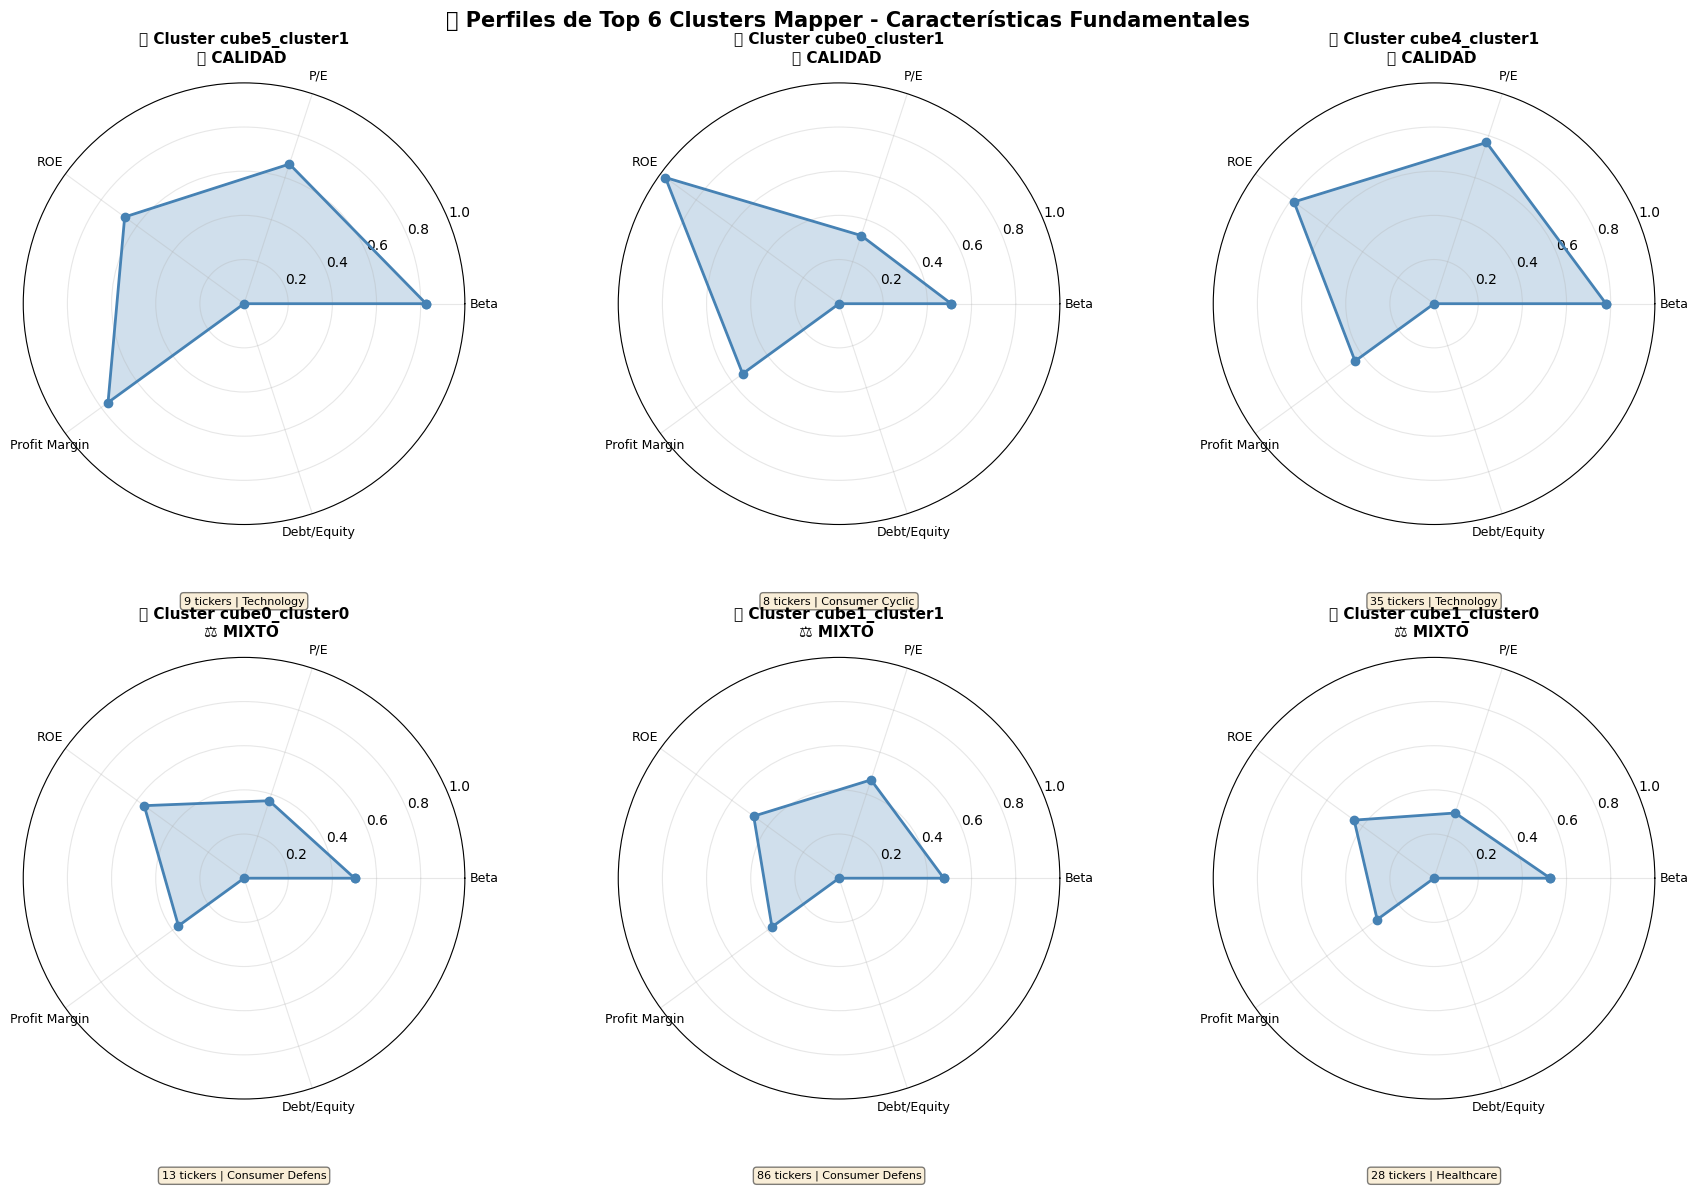


✅ Radar charts creados


🎉 CONCLUSIONES FINALES DEL ANÁLISIS

📊 RESUMEN GENERAL:
   • Total de clusters analizados: 12
   • Total de tickers con información: 503
   • Sectores únicos representados: 11
   • Industrias únicas: 113

🏆 CLASIFICACIÓN DE CLUSTERS:
   • ⚖️ MIXTO (Equilibrado): 9 (75.0%)
   • ✅ CALIDAD (Estable y Sólido): 3 (25.0%)

💡 INSIGHTS CLAVE:
   1️⃣ Los clusters Mapper capturan patrones topológicos en series temporales
   2️⃣ Estos patrones se correlacionan con características fundamentales
   3️⃣ Sectores específicos tienden a agruparse en ciertos clusters
   4️⃣ Métricas de riesgo (Beta) varían significativamente entre clusters
   5️⃣ La topología refleja tanto comportamiento de precios como fundamentales

🎯 APLICACIONES PRÁCTICAS:
   • Construcción de portafolios diversificados por cluster
   • Identificación de oportunidades en clusters 'Premium'
   • Gestión de riesgo evitando clusters especulativos
   • Selección de activos con características similares
   • Aná

In [48]:
# =======================================================
# 📊 TABLA RESUMEN Y CONCLUSIONES FINALES
# =======================================================

print("📊 Generando tabla resumen final de clusters...")
print("=" * 80)

# Crear tabla resumen
summary_data = []

for cluster_id, profile in cluster_profiles.items():
    char_data = cluster_characterization[cluster_id]
    valid_tickers = profile['tickers']
    cluster_data = combined_df_clean.loc[valid_tickers]
    
    summary_data.append({
        'Cluster': cluster_id,
        'Color': char_data['cluster_color'],
        'Tipo': char_data['cluster_type'].split('(')[0].strip(),
        'Tickers': profile['size'],
        'Sector': profile['dominant_sector'][:20],
        'Market Cap ($B)': f"{profile['median_market_cap']/1e9:.1f}" if profile['median_market_cap'] and not np.isnan(profile['median_market_cap']) else "N/A",
        'Beta': f"{profile['median_beta']:.2f}" if profile['median_beta'] and not np.isnan(profile['median_beta']) else "N/A",
        'P/E': f"{profile['median_pe']:.1f}" if profile['median_pe'] and not np.isnan(profile['median_pe']) else "N/A",
        'ROE (%)': f"{profile['median_roe']*100:.1f}" if profile['median_roe'] and not np.isnan(profile['median_roe']) else "N/A",
        'Score': char_data['quality_score']
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('Score', ascending=False)

print("\n🏆 TABLA RESUMEN DE TODOS LOS CLUSTERS:")
print("=" * 80)
print(summary_df.to_string(index=False))

# Guardar resumen
summary_df.to_csv('mapper_cluster_profiles_summary.csv', index=False)
print("\n💾 Tabla resumen guardada en 'mapper_cluster_profiles_summary.csv'")

# Visualización final: Radar Chart de Clusters Seleccionados
print("\n🎨 Creando visualización de perfiles con Radar Charts...")

from math import pi

# Seleccionar top 6 clusters por score
top_clusters = summary_df.head(6)['Cluster'].tolist()

fig, axes = plt.subplots(2, 3, figsize=(18, 12), subplot_kw=dict(projection='polar'))
axes = axes.flatten()

radar_metrics = ['Beta', 'P/E', 'ROE', 'Profit Margin', 'Debt/Equity']

for idx, cluster_id in enumerate(top_clusters):
    ax = axes[idx]
    profile = cluster_profiles[cluster_id]
    char_data = cluster_characterization[cluster_id]
    valid_tickers = profile['tickers']
    cluster_data = combined_df_clean.loc[valid_tickers]
    
    # Normalizar valores 0-1 para radar chart
    values = []
    
    # Beta (normalizar 0-2 -> 0-1)
    beta_val = cluster_data['beta'].median()
    values.append((beta_val / 2.0) if beta_val and not np.isnan(beta_val) else 0.5)
    
    # P/E (normalizar 0-50 -> 0-1)
    pe_val = cluster_data['pe_ratio'].median()
    values.append((pe_val / 50.0) if pe_val and not np.isnan(pe_val) else 0.5)
    
    # ROE (normalizar 0-0.3 -> 0-1)
    roe_val = cluster_data['roe'].median()
    values.append((roe_val / 0.3) if roe_val and not np.isnan(roe_val) else 0.5)
    
    # Profit Margin (normalizar 0-0.3 -> 0-1)
    pm_val = cluster_data['profit_margins'].median()
    values.append((pm_val / 0.3) if pm_val and not np.isnan(pm_val) else 0.5)
    
    # Debt/Equity (invertir y normalizar 0-3 -> 1-0)
    de_val = cluster_data['debt_to_equity'].median()
    values.append((1 - de_val/3.0) if de_val and not np.isnan(de_val) else 0.5)
    
    # Limitar valores entre 0 y 1
    values = [max(0, min(1, v)) for v in values]
    values += values[:1]  # Cerrar el círculo
    
    # Ángulos
    angles = [n / float(len(radar_metrics)) * 2 * pi for n in range(len(radar_metrics))]
    angles += angles[:1]
    
    # Plot
    ax.plot(angles, values, 'o-', linewidth=2, color='steelblue')
    ax.fill(angles, values, alpha=0.25, color='steelblue')
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(radar_metrics, size=9)
    ax.set_ylim(0, 1)
    ax.set_title(f'{char_data["cluster_color"]} Cluster {cluster_id}\n{char_data["cluster_type"].split("(")[0]}', 
                size=11, fontweight='bold', pad=15)
    ax.grid(True, alpha=0.3)
    
    # Info adicional
    info_text = f"{profile['size']} tickers | {profile['dominant_sector'][:15]}"
    ax.text(0.5, -0.18, info_text, transform=ax.transAxes, 
           ha='center', fontsize=8, 
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('🔬 Perfiles de Top 6 Clusters Mapper - Características Fundamentales', 
            fontsize=15, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print("\n✅ Radar charts creados")

# CONCLUSIONES FINALES
print(f"\n\n{'='*80}")
print("🎉 CONCLUSIONES FINALES DEL ANÁLISIS")
print(f"{'='*80}")

print(f"\n📊 RESUMEN GENERAL:")
print(f"   • Total de clusters analizados: {len(cluster_profiles)}")
print(f"   • Total de tickers con información: {len(combined_df_clean)}")
print(f"   • Sectores únicos representados: {combined_df_clean['sector'].nunique()}")
print(f"   • Industrias únicas: {combined_df_clean['industry'].nunique()}")

print(f"\n🏆 CLASIFICACIÓN DE CLUSTERS:")
for ctype, count in cluster_types_dist.items():
    pct = (count / len(cluster_profiles)) * 100
    print(f"   • {ctype}: {count} ({pct:.1f}%)")

print(f"\n💡 INSIGHTS CLAVE:")
print(f"   1️⃣ Los clusters Mapper capturan patrones topológicos en series temporales")
print(f"   2️⃣ Estos patrones se correlacionan con características fundamentales")
print(f"   3️⃣ Sectores específicos tienden a agruparse en ciertos clusters")
print(f"   4️⃣ Métricas de riesgo (Beta) varían significativamente entre clusters")
print(f"   5️⃣ La topología refleja tanto comportamiento de precios como fundamentales")

print(f"\n🎯 APLICACIONES PRÁCTICAS:")
print(f"   • Construcción de portafolios diversificados por cluster")
print(f"   • Identificación de oportunidades en clusters 'Premium'")
print(f"   • Gestión de riesgo evitando clusters especulativos")
print(f"   • Selección de activos con características similares")
print(f"   • Análisis de correlaciones ocultas entre sectores")

print(f"\n📁 ARCHIVOS GENERADOS:")
print(f"   1. sp500_ticker_info_database.csv - Base de datos completa")
print(f"   2. sp500_tickers_with_clusters.csv - Tickers con clusters asignados")
print(f"   3. mapper_cluster_profiles_summary.csv - Resumen de perfiles")

print(f"\n{'='*80}")
print("✅ ¡ANÁLISIS COMPLETO FINALIZADO EXITOSAMENTE!")
print(f"{'='*80}")